In [46]:
import os
# from os.path import exists
import pandas as pd
import numpy as np
import scipy.stats as st
# from scipy.stats import ttest_ind_from_stats
from itertools import combinations
import copy
import collections

## Variables

In [47]:
#Declare our variables
main_dir = '../Results'
sub_dir = '' #if we have another structure

dir = main_dir+sub_dir
outdir = f'{dir}/Data_Analysis'
files = {
    # 'survey_data':'results_cleaned.csv',
    # 'stimuli_ratings': f'{outdir}/data/ratings',
    # 'stimuli_demographics': f'{outdir}/demographics',
    'valid_answers':f'{outdir}/valid_answers',
    'comments':f'{outdir}/others/intial-results',
}

#list of conditions (used in questions' codes)
conditions = [
    'A',
    'B',
    'C',
    'D',
    'E',
    'F'
]

# we replace letters with numbers for R script - the files are numbered from 1 to 6 where 1 = stimuli A, 2 = stimuli B etc.
numbers = {
    'A':'1',
    'B':'2',
    'C':'3',
    'D':'4',
    'E':'5',
    'F':'6'
}

#different groups of column names

demographics = [
    'Age',
    'Gender',
    'Education',
    'English_primary',
    'English_fluent',
]

items = [
'answer',
'clearData',
'clearRepresent',
'complex',
'confid',
'confus',
'crowd',
'deciph',
'distinguish',
'distract',
'effect',
'find',
'identifi',
'inform',
'lost',
'meanElem',
'meanOveral',
'messi',
'obvious',
'organiz',
'read',
'readabl',
'represent',
'see',
'simpl',
'understandEasi',
'understandQuick',
'valu',
'visibl',
]

# Load answers

In [48]:
# we create a dictionary to hold clean dfs
stimuli_dfs = {}

def if_exists_load_df_in_dict(this_file, this_key, this_condition):
    global stimuli_dfs
    this_exists = os.path.exists(this_file)
    if this_exists == True:
        this_df = pd.read_csv(this_file)
        if 'seed' in this_df.columns: #then we reload with seed as str, otherwise it will become a float (INT64)
            this_df = pd.read_csv(this_file, converters = {'seed': str})
            this_df.dropna(subset=['seed'], how='any', inplace=True) #drop any NA in seed, just in case, before making it the index
            this_df.to_csv(this_file, index=False)
            this_df.set_index('seed', inplace=True)
        stimuli_dfs[this_condition].update({
            this_key : this_df
        })
        print(f'{len(this_df)} {this_key} retrieved for {condition}')
    else:
        print(f'No {this_key} file found for {condition}')


for condition in conditions:
    stimuli_dfs.update({
        condition:{}
    })

    #add ratings dfs
    # rating_file = f"{files['stimuli_ratings']}-{numbers[condition]}.csv"
    # if_exists_load_df_in_dict(rating_file, 'ratings', condition)

    #add full answers dfs
    answers_file = f"{files['valid_answers']}-{condition}.csv"
    if_exists_load_df_in_dict(answers_file, 'valid_answers', condition)

    #add comments dfs
    comments_file = f"{files['comments']}-{condition}_others_comments.csv"
    if_exists_load_df_in_dict(comments_file, 'comments', condition)

288 ratings retrieved for A
288 valid_answers retrieved for A
18 comments retrieved for A
288 ratings retrieved for B
288 valid_answers retrieved for B
14 comments retrieved for B
287 ratings retrieved for C
287 valid_answers retrieved for C
18 comments retrieved for C
309 ratings retrieved for D
309 valid_answers retrieved for D
25 comments retrieved for D
293 ratings retrieved for E
293 valid_answers retrieved for E
29 comments retrieved for E
293 ratings retrieved for F
293 valid_answers retrieved for F
22 comments retrieved for F


# Exporting comments in one df

In [49]:
def clean_name(col, condition):
    if col[-7:] == "_other_" and col[-8] == condition:
        new_col = col[:-8]
        return new_col
    elif col[:-7] == "_other_" and col[-8] != condition:
        print(f'{col} does not belong to {condition}')
        return col
    else:
        return col

def add_count_comments(condition, dfs_dict):
    this_comments_df = dfs_dict[condition]['comments'].T.reset_index().T
    
    print([f'Na found in {c}' for c in this_comments_df[0] if pd.isna(c)])
    list(this_comments_df[0])

    this_comments_df.set_index(0, inplace=True)

    print(list(this_comments_df.index))
    print([f'Na found in {c}' for c in list(this_comments_df.index) if pd.isna(c)])

    #Comments count per participants
    # retain content from "other" (= comment in a rating question was using the "other" field of the survey platform)
    mask_other = this_comments_df.index.str.contains("_other_")
    print(mask_other)
    # Create a new row with the sum of non-NA values for each participant
    this_comments_df.loc['Sum_rating_comments'] = this_comments_df[mask_other].count()
    # Replace NaN with 0 in the new row
    this_comments_df.loc['Sum_rating_comments'].fillna(0, inplace=True)
    # Move the 'Sum_other_comments' after the demographic data
    this_comments_df = pd.concat([this_comments_df.iloc[:, :6], this_comments_df.loc['Sum_rating_comments'], this_comments_df.iloc[:, 6:]], axis=1)

    this_comments_df.drop(columns=['Sum_rating_comments'], inplace=True)

    this_comments_df = this_comments_df.T
    this_comments_df.insert(6,'Stimuli',condition)

    #Comments count per stimulus condition
    this_comments_df.loc[f'Sum_rating_comments_{condition}'] = this_comments_df.filter(like='_other_').count()
    this_comments_df.loc[f'Sum_rating_comments_{condition}'].fillna(0, inplace=True)
    this_comments_df.at[f'Sum_rating_comments_{condition}','Stimuli'] = condition

    this_comments_df.drop(columns=[col for col in this_comments_df.columns if isinstance(col, int)], inplace=True)
    for col in this_comments_df.columns:
        this_comments_df.rename(columns={col : clean_name(col, condition)}, inplace=True)
    return this_comments_df

comments_df_list = []
for condition in conditions:
    this_comment_df = add_count_comments(condition, stimuli_dfs)
    stimuli_dfs[condition].update({
        'comments' : this_comment_df
    })
    comments_df_list += [this_comment_df]

[]
['Age', 'Gender', 'Education', 'English_primary', 'English_fluent', 'colorDeficiency', 'colorDeficiency_comment_', 'answerA_other_', 'clearDataA_other_', 'clearRepresentA_other_', 'distinguishA_other_', 'effectA_other_', 'findA_other_', 'identifiA_other_', 'organizA_other_', 'readA_other_', 'readablA_other_', 'simplA_other_', 'valuA_other_']
[]
[False False False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True]
[]
['Age', 'Gender', 'Education', 'English_primary', 'English_fluent', 'colorDeficiency', 'colorDeficiency_comment_', 'answerB_other_', 'complexB_other_', 'deciphB_other_', 'distractB_other_', 'lostB_other_', 'messiB_other_', 'readablB_other_', 'seeB_other_']
[]
[False False False False False False False  True  True  True  True  True
  True  True  True]
[]
['Age', 'Gender', 'Education', 'English_primary', 'English_fluent', 'colorDeficiency', 'colorDeficiency_comment_', 'clearRepresentC_other_', 'confusC_other_', 'distinguishC_o

C:\Users\Anne-Flore\AppData\Local\Temp\ipykernel_17860\380317870.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_comments_df.loc['Sum_rating_comments'].fillna(0, inplace=True)
C:\Users\Anne-Flore\AppData\Local\Temp\ipykernel_17860\380317870.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_comments_df.loc[f'Sum_rating_comments_{condition}'].fillna(0, inplace=True)
C:\Users\Anne-Flore\AppData\Local\Temp\ipykernel_17860\380317870.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [50]:
all_comments = pd.concat(comments_df_list, axis = 0)
all_comments.to_csv(f'{outdir}/all_comments_by_individual.csv')

In [51]:
all_comments

Age                                      Gender   
1                        26.0        Man (including Trans Male/Trans Man)  \
2                      26.0.1        Man (including Trans Male/Trans Man)   
3                        24.0        Man (including Trans Male/Trans Man)   
4                        69.0        Man (including Trans Male/Trans Man)   
5                        45.0  Woman (including Trans Female/Trans Woman)   
...                       ...                                         ...   
6                        36.0        Man (including Trans Male/Trans Man)   
7                        29.0        Man (including Trans Male/Trans Man)   
8                        32.0        Man (including Trans Male/Trans Man)   
9                        28.0  Woman (including Trans Female/Trans Woman)   
Sum_rating_comments_F     NaN                                         NaN   

                                                  Education English_primary   
1                       Undergraduate degree (BA/BSc/other)           False  \
2                      Graduate degree (MA/MSc/MPhil/other)           False   
3                              High school diploma/A-levels            True   
4                       Undergraduate degree (BA/BSc/other)            True   
5                              High school diploma/A-levels            True   
...                                                     ...             ...   
6                       Undergraduate degree (BA/BSc/other)            True   
7                               Technical/community college            True   
8                      Graduate degree (MA/MSc/MPhil/other)            True   
9                      Graduate degree (MA/MSc/MPhil/other)           False   
Sum_rating_comments_F                                   NaN             NaN   

                      English_fluent colorDeficiency Stimuli   
1                               True              No       A  \
2                               True              No       A   
3                               True              No       A   
4                               True              No       A   
5                               True              No       A   
...                              ...             ...     ...   
6                               True              No       F   
7                               True              No       F   
8                               True              No       F   
9                               True              No       F   
Sum_rating_comments_F            NaN             NaN       F   

                      colorDeficiency_comment_ answer   
1                                          NaN    NaN  \
2                                          NaN    NaN   
3                                          NaN    NaN   
4                                          NaN    NaN   
5                                          NaN    NaN   
...                                        ...    ...   
6                                          NaN    NaN   
7                                          NaN    NaN   
8                                          NaN    NaN   
9                                          NaN    NaN   
Sum_rating_comments_F                      NaN    1.0   

                                                               clearData  ...   
1                                                                    NaN  ...  \
2                                                                    NaN  ...   
3                                                                    NaN  ...   
4                                                                    NaN  ...   
5                      please see my previous answer  I'll probably t...  ...   
...                                                                  ...  ...   
6                                                                    NaN  ...   
7                                                 

In [52]:
# Define a custom aggregation function to concatenate the comments
def custom_agg(series):
    non_na_values = series.dropna()
    if not non_na_values.empty:
        string = '.\n\n'.join(map(str, non_na_values)) + '.\n\n'
        string = string.replace('..', '.')
        string = string[:-2]
        return string 
    return ''

agg_comments_df_list = []

df_all = all_comments.drop(columns=['Age','Gender','Education','English_primary','English_fluent','colorDeficiency','colorDeficiency_comment_'])
for condition in conditions:
    print('=======\n' + condition + '\n=======\n')
    df = df_all[df_all['Stimuli'] == condition]
    df.drop([i for i in df.index if isinstance(i, str) and f'Sum_rating_comments_' in i], axis=0, inplace=True)
    
    df.dropna(how='all')
    
    # Create a new DataFrame to add the results
    result_df = pd.DataFrame()

    # Iterate over each column
    for col in df.columns[1:]:  # Skip the first column ('Stimuli')
        # Aggregate comments, discard NaNs, and add dots at the end of each string
        aggregated_comments = df[col].dropna().astype(str).agg(custom_agg)
        
        # Add the aggregated comments as a new row for each column
        if isinstance(aggregated_comments, str):
            print(col)
            print('=======\n' + aggregated_comments)
            result_df[col] = [aggregated_comments]

    # Add the 'Sum_rating_comments_{condition}' row from the original df
    sum_rating_row = df_all[df_all.index == f'Sum_rating_comments_{condition}'].copy()
    result_df = pd.concat([result_df, sum_rating_row]).rename(index={0 : f'All_comments_{condition}'}).drop(columns=['Sum_rating_comments','Stimuli'])
    agg_comments_df_list.append(result_df)

all_comments_aggregated = pd.concat(agg_comments_df_list, axis = 0)



A

answer
hard to see the exact number.
clearData
please see my previous answer  I'll probably time out if I have to type it again but it said something isn't right here these increments are supposed to be fine tuned Right? Because that's Mbps And you already know that's clear so that's not what's going on in this study LOL right i'm not going crazy here right? .
clearRepresent
Kind of since most of the results have decimal numbers that cannot be deduced with accuracy.
distinguish
It just erased my answer and I just spent this time and wrote it out i'm I'm an overthinker and I'm starting to overthink this and I'm probably gonna end up timing out the way I'm seeing it is of course you know already it's clear to see but what are you really asking is my question..Mbps  Even a small tiny increment is a significant difference is that what we're getting out here because it's not labeled by little increment I think that's what we're getting at if not I'm sorry but I've been overthinking this 

C:\Users\Anne-Flore\AppData\Local\Temp\ipykernel_17860\3196975614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop([i for i in df.index if isinstance(i, str) and f'Sum_rating_comments_' in i], axis=0, inplace=True)
C:\Users\Anne-Flore\AppData\Local\Temp\ipykernel_17860\3196975614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop([i for i in df.index if isinstance(i, str) and f'Sum_rating_comments_' in i], axis=0, inplace=True)
C:\Users\Anne-Flore\AppData\Local\Temp\ipykernel_17860\3196975614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

In [53]:
#Add sum of comments counts
comment_counts = all_comments_aggregated.filter(items = [i for i in all_comments_aggregated.index if 'Sum_rating_comments' in i], axis=0).fillna(0)
# Sum of comment per stimulus
comment_counts.insert(0,'Sum_rating_comments_stimuli', comment_counts.sum(axis=1))
# Sum of comments across stimuli
comment_count_row = comment_counts.sum(axis=0)
all_comments_aggregated.loc['Sum_rating_comments_total'] = comment_count_row
all_comments_aggregated.insert(0, 'Sum_rating_comments_stimuli', comment_counts['Sum_rating_comments_stimuli'])
all_comments_aggregated.at['Sum_rating_comments_total','Sum_rating_comments_stimuli'] = all_comments_aggregated['Sum_rating_comments_stimuli'].sum()

# rotate the df and change column order so that cols of "Sum_rating" are first
all_comments_aggregated = all_comments_aggregated.T
print(all_comments_aggregated.columns)
new_col_order = [col for col in list(all_comments_aggregated.columns)]
new_col_order.sort(reverse = True)
all_comments_aggregated = all_comments_aggregated[new_col_order]

# export
all_comments_aggregated.to_csv(f'{outdir}/all_comments_by_stimulus.csv')
all_comments_aggregated

Index(['All_comments_A', 'Sum_rating_comments_A', 'All_comments_B',
       'Sum_rating_comments_B', 'All_comments_C', 'Sum_rating_comments_C',
       'All_comments_D', 'Sum_rating_comments_D', 'All_comments_E',
       'Sum_rating_comments_E', 'All_comments_F', 'Sum_rating_comments_F',
       'Sum_rating_comments_total'],
      dtype='object')


Sum_rating_comments_total Sum_rating_comments_F   
Sum_rating_comments_stimuli                     140.0                  20.0  \
answer                                            5.0                   1.0   
clearData                                         3.0                   1.0   
clearRepresent                                    3.0                   NaN   
distinguish                                      11.0                   3.0   
effect                                            4.0                   NaN   
find                                              2.0                   1.0   
identifi                                          3.0                   NaN   
organiz                                           5.0                   2.0   
read                                              9.0                   1.0   
readabl                                           6.0                   NaN   
simpl                                             6.0                   1.0   
valu                                             11.0                   NaN   
complex                                           7.0                   NaN   
deciph                                            4.0                   1.0   
distract                                          4.0                   NaN   
lost                                              4.0                   1.0   
messi                                             2.0                   1.0   
see                                               6.0                   1.0   
confus                                            4.0                   2.0   
inform                                            2.0                   NaN   
obvious                                           7.0                   NaN   
represent                                         5.0                   NaN   
understandQuick                                   6.0                   1.0   
visibl                                            6.0                   1.0   
confid                                            4.0                   1.0   
crowd                                             2.0                   NaN   
meanElem                                          3.0                   NaN   
meanOveral                                        3.0                   1.0   
understandEasi                                    3.0                   NaN   

                            Sum_rating_comments_E Sum_rating_comments_D   
Sum_rating_comments_stimuli                  45.0                  37.0  \
answer                                        2.0                   NaN   
clearData                                     1.0                   NaN   
clearRepresent                                1.0                   NaN   
distinguish                                   2.0                   2.0   
effect                                        2.0                   1.0   
find                                          NaN                   NaN   
identifi                                      NaN                   2.0   
organiz                                       1.0                   1.0   
read                                          2.0                   4.0   
readabl                                       2.0                   2.0   
simpl                                         2.0                   2.0   
valu                                          4.0                   3.0   
complex                                       3.0                   3.0   
deciph                                        NaN                   2.0   
distract                                      1.0                   NaN   
lost                                          2.0                   NaN   
messi                                         NaN                   NaN   
see                                           2.0                   NaN   
confus                                        NaN                   1.0   
inf

# Looking at raw data before modeling

In [54]:
# Compute some central values

def make_central_values(df, target_df, letter):
    (print("df columns:"))
    print(df.columns)
    cols ={
        "Mean":df.mean(),
        #"Mode":df.mode(),
        "Median":df.median(),
        "Std":df.std(),
        "N":df.count()
    }
    central_df = pd.DataFrame.from_dict(cols, orient='index')
    print(f'Central values of {target_df} for stimuli {letter}')
    print(f'{central_df.T.mean()}')
    return central_df.T

# Frequencies for heatmaps
def make_frequencies(df):
    items_df_collection = {}
    for item in list(df):
        temp_df = pd.DataFrame(df[item])
        this_item_frequencies = pd.DataFrame(temp_df.groupby(by=item).value_counts()).rename_axis('likert')
        this_item_frequencies.columns = [item]
        items_df_collection.update({
            item:this_item_frequencies
        })
    all_frequencies = pd.concat(list(items_df_collection.values()), axis=1)
    all_frequencies.fillna(0, inplace=True)
    return all_frequencies

def make_frequencies_percentages(df):
    for col in df.columns:
        total = sum(df[col])
        df[col] = df[col]/total
    return df

# Utils
def get_df(all_dfs, target_df, letter, score_correction):
    this_df = all_dfs[letter][target_df] + score_correction
    all_dfs[letter][target_df] = this_df
    return this_df

# Look at data
def look_at_data(all_dfs, target_df, letter, score_correction=0):
    df = get_df(all_dfs, target_df, letter, score_correction)
    df = df
    central_df = make_central_values(df, target_df, letter)
    frequencies_df = make_frequencies(df)
    frequencies_percents_df = make_frequencies_percentages(frequencies_df)

    return central_df, frequencies_df, frequencies_percents_df

In [55]:
for condition in conditions:
    look_results = look_at_data(stimuli_dfs, 'ratings', condition, score_correction = 4) #score correction prevents allows 
    look_results[0].to_csv(f'{outdir}/ratings-central-values-{condition}.csv')
    stimuli_dfs[condition].update({
        'central_values':look_results[0],
        'answers_frequencies':look_results[1],
        'answers_frequencies_percentages':look_results[2]
    })



df columns:
Index(['answer', 'clearData', 'clearRepresent', 'complex', 'confid', 'confus',
       'crowd', 'deciph', 'distinguish', 'distract', 'effect', 'find',
       'identifi', 'inform', 'lost', 'meanElem', 'meanOveral', 'messi',
       'obvious', 'organiz', 'read', 'readabl', 'represent', 'see', 'simpl',
       'understandEasi', 'understandQuick', 'valu', 'visibl'],
      dtype='object')
Central values of ratings for stimuli A
Mean        6.178467
Median      6.258621
Std         1.008137
N         287.275862
dtype: float64
df columns:
Index(['answer', 'clearData', 'clearRepresent', 'complex', 'confid', 'confus',
       'crowd', 'deciph', 'distinguish', 'distract', 'effect', 'find',
       'identifi', 'inform', 'lost', 'meanElem', 'meanOveral', 'messi',
       'obvious', 'organiz', 'read', 'readabl', 'represent', 'see', 'simpl',
       'understandEasi', 'understandQuick', 'valu', 'visibl'],
      dtype='object')
Central values of ratings for stimuli B
Mean        6.089315
Median  

df columns:
Index(['answer', 'clearData', 'clearRepresent', 'complex', 'confid', 'confus',
       'crowd', 'deciph', 'distinguish', 'distract', 'effect', 'find',
       'identifi', 'inform', 'lost', 'meanElem', 'meanOveral', 'messi',
       'obvious', 'organiz', 'read', 'readabl', 'represent', 'see', 'simpl',
       'understandEasi', 'understandQuick', 'valu', 'visibl'],
      dtype='object')
Central values of ratings for stimuli D
Mean        3.858623
Median      3.655172
Std         1.710501
N         307.620690
dtype: float64
df columns:
Index(['answer', 'clearData', 'clearRepresent', 'complex', 'confid', 'confus',
       'crowd', 'deciph', 'distinguish', 'distract', 'effect', 'find',
       'identifi', 'inform', 'lost', 'meanElem', 'meanOveral', 'messi',
       'obvious', 'organiz', 'read', 'readabl', 'represent', 'see', 'simpl',
       'understandEasi', 'understandQuick', 'valu', 'visibl'],
      dtype='object')
Central values of ratings for stimuli E
Mean        4.178457
Median  

In [56]:
p_values_dfs = []
all_pairs = list(combinations(conditions, 2))
for pair in all_pairs:
    print(f'p value of means between {pair[0]} and {pair[1]}')
    df1 = stimuli_dfs[pair[0]]['central_values']
    df2 = stimuli_dfs[pair[1]]['central_values']

    n1 = df1['N'].min()
    print(f'{n1} people in {pair[0]}')
    n2 = df2['N'].min()
    print(f'{n2} people in {pair[1]}')

    mean1 = df1['Mean'].mean()
    mean2 = df2['Mean'].mean()

    std1 = df1['Std'].mean()
    std2 = df2['Std'].mean()

    tstat, pvalue = st.ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2)
    print(pvalue)
    print("\n----------------------\n")

#p_values_dict = {}
#for index, row in df1.iterrows():
    

p value of means between A and B
285.0 people in A
285.0 people in B
0.2915607817406253

----------------------

p value of means between A and C
285.0 people in A
283.0 people in C
0.3663160752270528

----------------------

p value of means between A and D
285.0 people in A
305.0 people in D
1.0089080282169423e-67

----------------------

p value of means between A and E
285.0 people in A
277.0 people in E
3.873795529156693e-52

----------------------

p value of means between A and F
285.0 people in A
290.0 people in F
2.030755022173425e-59

----------------------

p value of means between B and C
285.0 people in B
283.0 people in C
0.8821302850386632

----------------------

p value of means between B and D
285.0 people in B
305.0 people in D
8.795664897624274e-64

----------------------

p value of means between B and E
285.0 people in B
277.0 people in E
1.726090516528239e-48

----------------------

p value of means between B and F
285.0 people in B
290.0 people in F
2.315222881

## Are answers significantly different for people with color vision deficiency?

In [57]:
#load demographic data

### Simple ttests

In [58]:
all_color_vision_sign_dfs = [] #to concat at the end
significant_ones = {}

for condition in conditions:
    print("\n----------------------\n")
    print(f'Testing for condition {condition}')
    
    # get the data
    ratings = stimuli_dfs[condition]['ratings']
    answers = stimuli_dfs[condition]['valid_answers']

    # extract paticipants with color vision deficiency
    vision_def_participants = answers[answers['colorDeficiency'] == "Yes"]
    vision_def_ratings = ratings.loc[vision_def_participants.index]

    df1 = pd.DataFrame(vision_def_ratings.mean(), columns=["Mean ratings"]).join(pd.DataFrame(vision_def_ratings.std(), columns=["Std ratings"]))

    # extract paticipants with NO color vision deficiency
    no_vision_def_participants = answers[answers['colorDeficiency'] == "No"]
    no_vision_def_ratings = ratings.loc[no_vision_def_participants.index]

    df2 = pd.DataFrame(no_vision_def_ratings.mean(), columns=["Mean ratings"]).join(pd.DataFrame(no_vision_def_ratings.std(), columns=["Std ratings"]))

    #ttests
    p_values_dict = {}

    n1 = len(vision_def_ratings)
    print(f'{n1} people with vision deficiency')
    n2 = len(no_vision_def_ratings)
    print(f'{n2} people without vision deficiency')
    
    # item by item
    for item in df1.index:    

        mean1 = df1.at[item,'Mean ratings']
        mean2 = df2.at[item,'Mean ratings']

        std1 = df1.at[item,'Std ratings']
        std2 = df2.at[item,'Std ratings']

        tstat, pvalue = st.ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2)

        p_values_dict.update({
            item: pvalue
        })

        if pvalue < 0.05:
            print(f'* Significant difference found for {item} in {condition}')
            if item not in significant_ones.keys():
                significant_ones.update({
                    item:{
                        condition:pvalue
                    }
                })
            else:
                significant_ones[item].update({
                    condition:pvalue
                })
    
    color_vision_ttest_df = pd.DataFrame.from_dict(p_values_dict, orient='index', columns=[f'Color vision deficiency significance in {condition}'])
    
    # we store in the 
    stimuli_dfs[condition].update({
        'color_vision_significance': color_vision_ttest_df
    })

    all_color_vision_sign_dfs += [color_vision_ttest_df]

color_vision_significances = pd.concat(all_color_vision_sign_dfs, axis=1)
color_vision_significances


----------------------

Testing for condition A
6 people with vision deficiency
282 people without vision deficiency
* Significant difference found for answer in A
* Significant difference found for distract in A
* Significant difference found for meanElem in A

----------------------

Testing for condition B
7 people with vision deficiency
281 people without vision deficiency
* Significant difference found for confus in B
* Significant difference found for crowd in B
* Significant difference found for deciph in B
* Significant difference found for distract in B
* Significant difference found for lost in B

----------------------

Testing for condition C
6 people with vision deficiency
281 people without vision deficiency

----------------------

Testing for condition D
9 people with vision deficiency
300 people without vision deficiency

----------------------

Testing for condition E
12 people with vision deficiency
281 people without vision deficiency
* Significant difference found

Color vision deficiency significance in A   
answer                                            0.028439  \
clearData                                         0.237938   
clearRepresent                                    0.621206   
complex                                           0.883970   
confid                                            0.144059   
confus                                            0.137446   
crowd                                             0.364419   
deciph                                            0.478588   
distinguish                                       0.316827   
distract                                          0.012358   
effect                                            0.831693   
find                                              0.929086   
identifi                                          0.409062   
inform                                            0.600127   
lost                                              0.928715   
meanElem                                          0.042236   
meanOveral                                        0.064579   
messi                                             0.305491   
obvious                                           0.068489   
organiz                                           0.214706   
read                                              0.083322   
readabl                                           0.620823   
represent                                         0.246357   
see                                               0.962284   
simpl                                             0.062818   
understandEasi                                    0.333671   
understandQuick                                   0.836161   
valu                                              0.947083   
visibl                                            0.228178   

                 Color vision deficiency significance in B   
answer                                            0.334922  \
clearData                                         0.302059   
clearRepresent                                    0.921507   
complex                                           0.080939   
confid                                            0.270089   
confus                                            0.036051   
crowd                                             0.035645   
deciph                                            0.002572   
distinguish                                       0.322641   
distract                                          0.002872   
effect                                            0.215043   
find                                              0.755300   
identifi                                          0.857711   
inform                                            0.209288   
lost                                              0.000081   
meanElem                                          0.590570   
meanOveral                                        0.141986   
messi                                             0.139258   
obvious                                           0.101496   
organiz                                           0.367636   
read                                              0.140925   
readabl                                           0.926406   
represent                                         0.130064   
see                                               0.580042   
simpl                                             0.147513   
understandEasi                                    0.217950   
understandQuick                                   0.322304   
valu                                              0.384841   
visibl                                            0.429455   

                 Color vision deficiency significance in C   
answer                                            0.701730  \
clearData                                         0.062129   
clearRepresent                                    0.504145   
complex                                        

# Plotting the answers

In [59]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

In [60]:
# Create the output folder if it doesn't exist
plots_outputdir = outdir+'/generatedPlots'
if not os.path.exists(plots_outputdir):
    os.makedirs(plots_outputdir)

In [61]:
def sort_clean_col_names(df):
    init_cols = list(df)
    init_cols.sort()
    df = df[init_cols]
    clean_cols = [int(col) for col in init_cols]
    df.columns = clean_cols
    return df

def plot_hist(this_df, letter):
    df = this_df.dropna()
    # hist2 = this_df.dropna().plot(kind='hist',bins=7, color="#348abd", sharex=False, figsize = (30,30), subplots=True, layout=(6,5), title=f'Stimuli {letter}')
    #with PdfPages(f"{outdir}/generatedPlots/test-{letter}.pdf") as pdf:
    f, axes = plt.subplots(29, 1, figsize=(5, 100), sharex=True)
    likert = [1,2,3,4,5,6,7,8]
    #cmap = plt.cm.RdYlGn
    cmap = plt.cm.RdYlBu #better w.r.t. color vision deficiencies
    plt.suptitle(f'Stimuli {letter}')
    
    ylim = 180 #we need to set the same y axis limit otherwise the comparison makes no sense. We observed from the frequencies calc that the max is aroun 60°% of people, out a 300 ppl sample that's 180

    for ax, item in zip(axes.flat, this_df.columns):
        ax.axis('off')
        ax.set_ylim(top=ylim)
        cnts, values, bars = ax.hist(this_df[item], edgecolor='k', bins=likert, linewidth=0)
        # ax.set_xticks(likert)
        for i, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
            bar.set_facecolor(cmap(value/7))

    #pdf.savefig()
    plt.show()
    f.savefig(f"{outdir}/generatedPlots/histo-{letter}.pdf", bbox_inches='tight')
    

def plot_heatmap(this_df, letter, clean_the_cols=False):
    if clean_the_cols:
        df = sort_clean_col_names(this_df.T)
    else:
        df = this_df
    f = plt.figure(figsize=(6,12))
    plt.title(f'Answers for stimulus {letter}')
    sns.heatmap(df, vmin=0, vmax=70, annot=True, fmt=".1f", cmap="Purples", linewidths=.5, cbar=False, square=True)
    f.savefig(f"{outdir}/generatedPlots/heatmap-{letter}.pdf", bbox_inches='tight')

    f2 = plt.figure(figsize=(12,12))
    plt.title(f'Answers for stimulus {letter}')
    sns.heatmap(df, vmin=0, vmax=70, annot=False, cmap="Purples", linewidths=0, cbar=False, square=True)
    f2.savefig(f"{outdir}/generatedPlots/heatmap_no_label-{letter}.pdf", bbox_inches='tight')

    

def plot_data(letter):
    plot_heatmap(stimuli_dfs[letter]['answers_frequencies_percentages']*100, letter, clean_the_cols=True)
    plot_hist(stimuli_dfs[letter]['ratings'], letter)

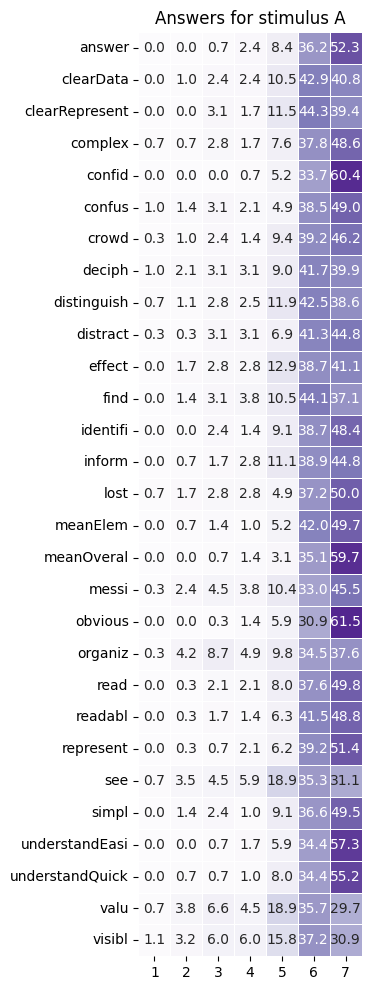

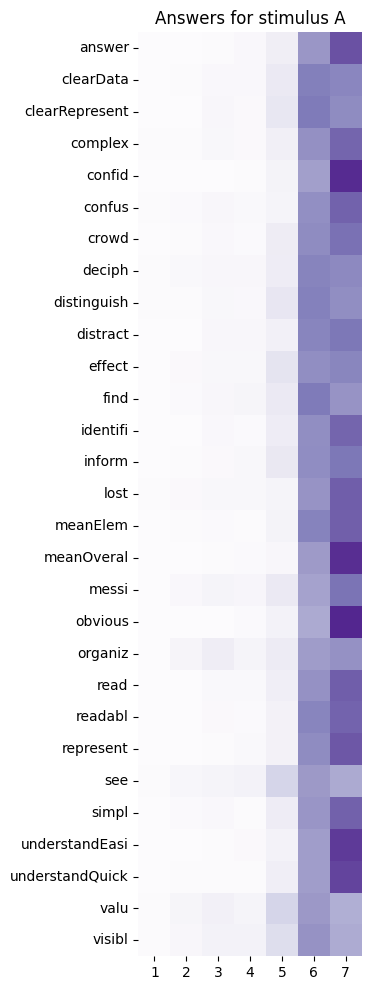

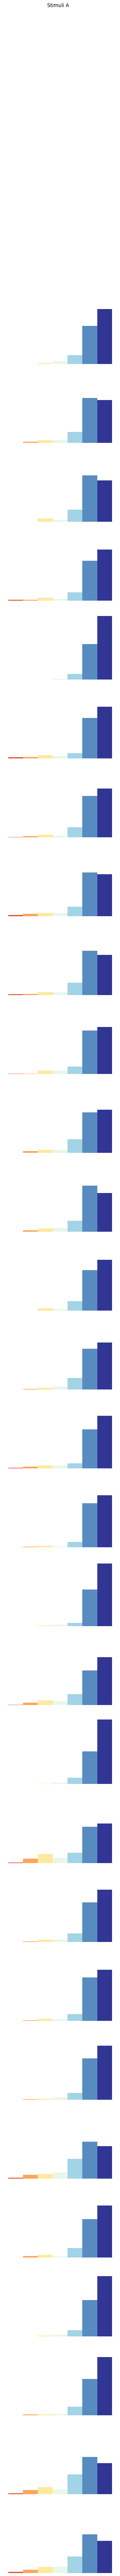

In [62]:
plot_data('A')

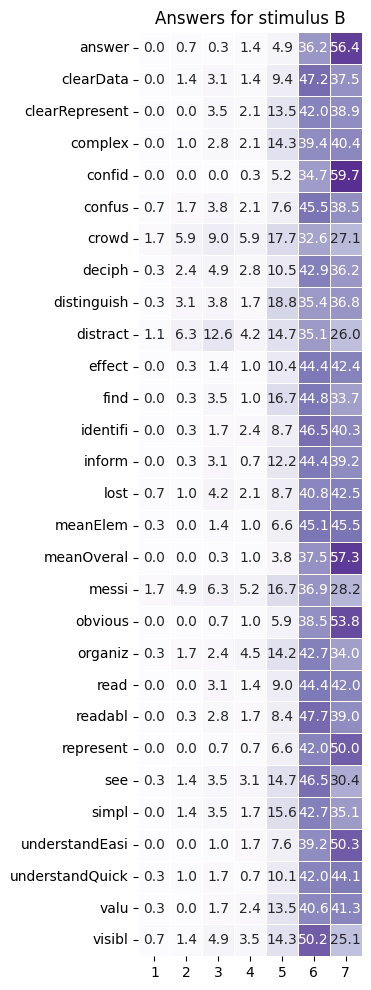

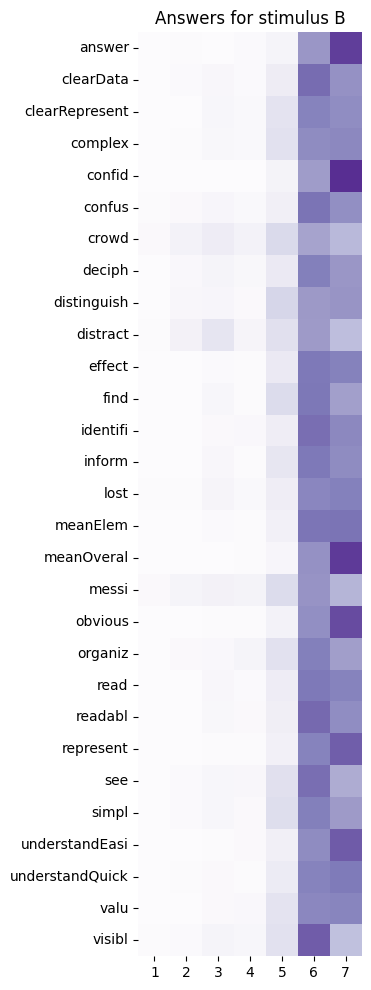

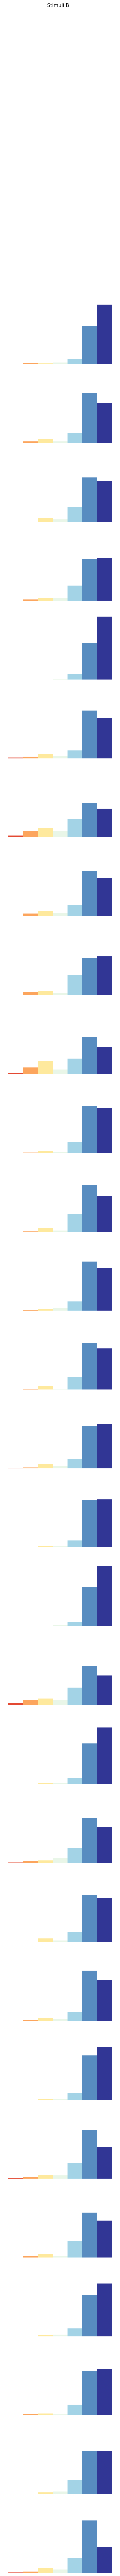

In [63]:
plot_data('B')

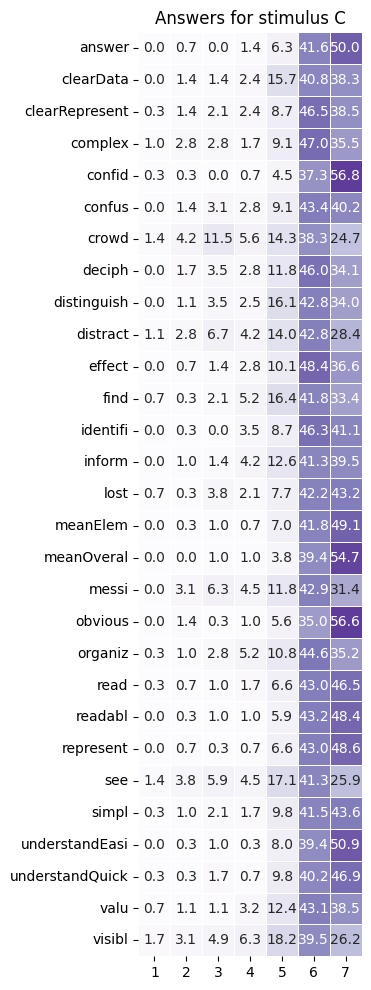

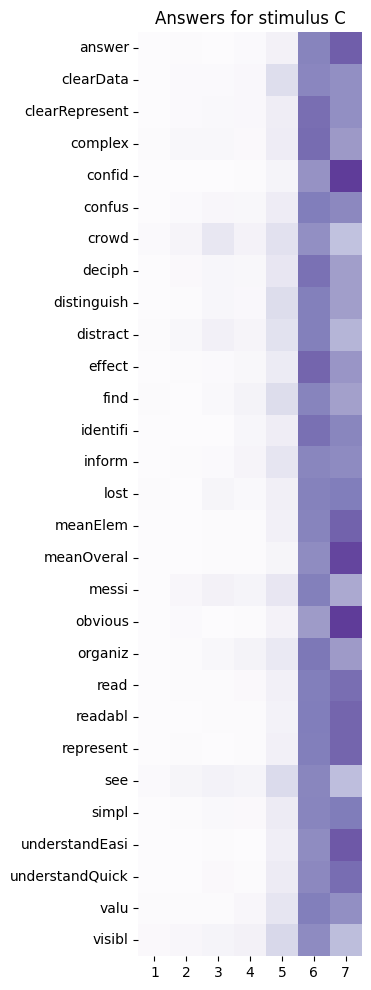

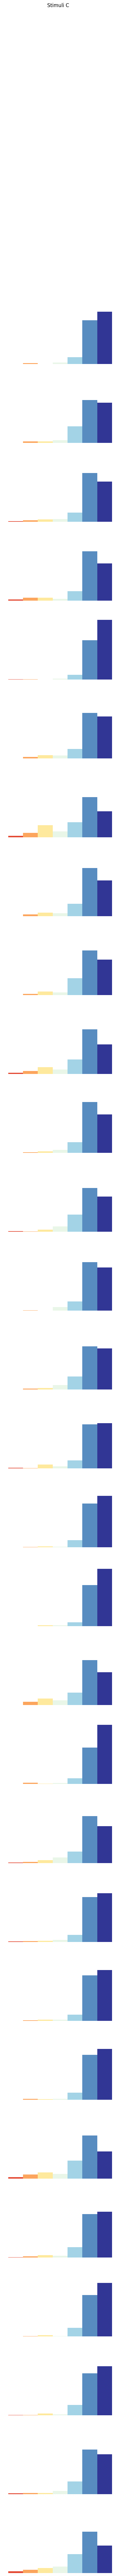

In [64]:
plot_data('C')

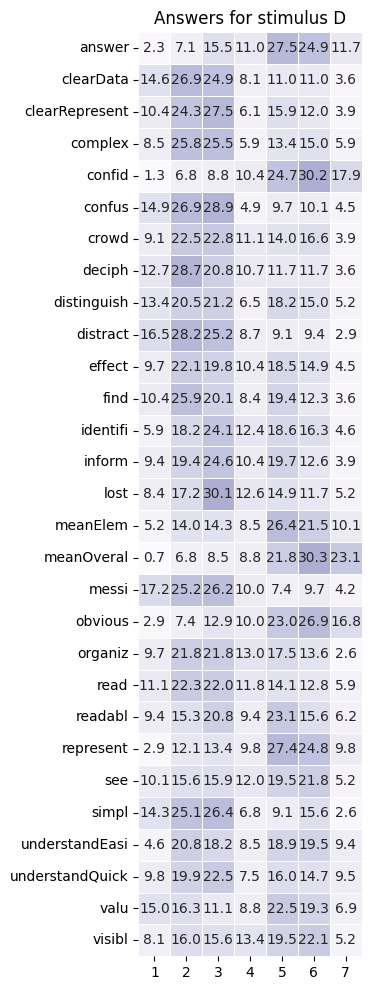

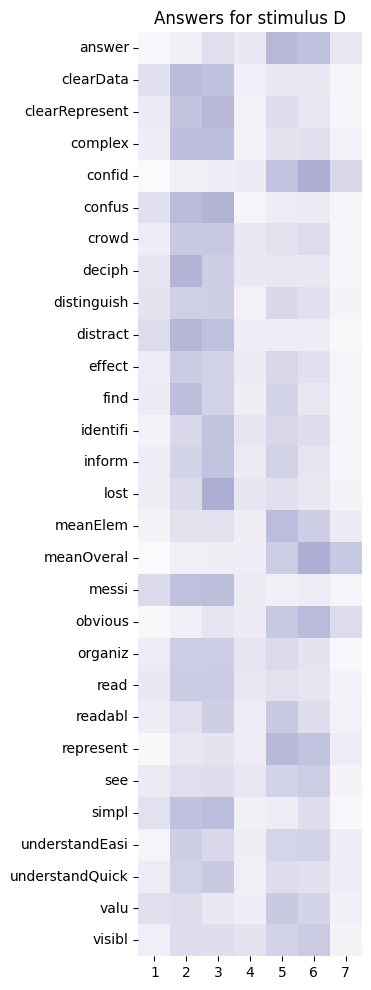

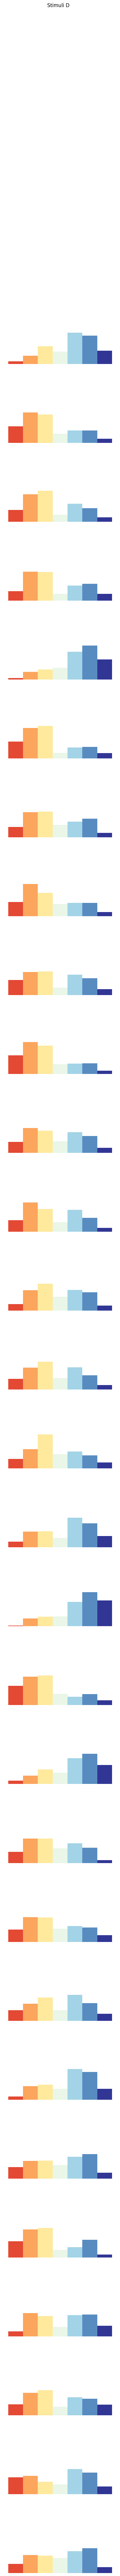

In [65]:
plot_data('D')

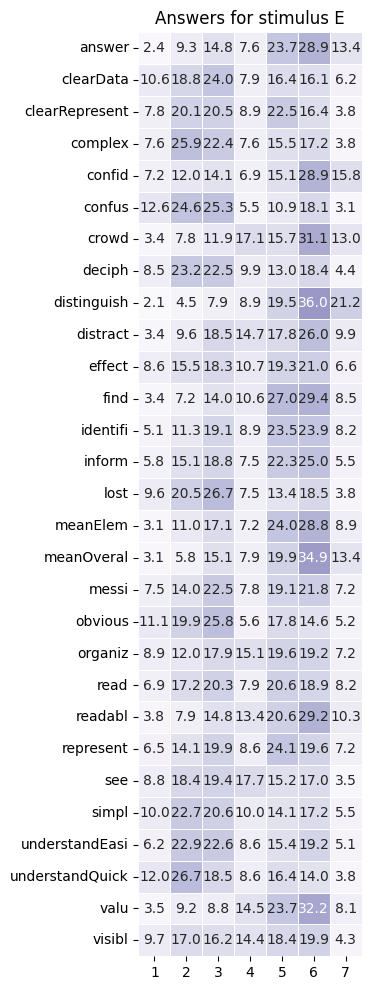

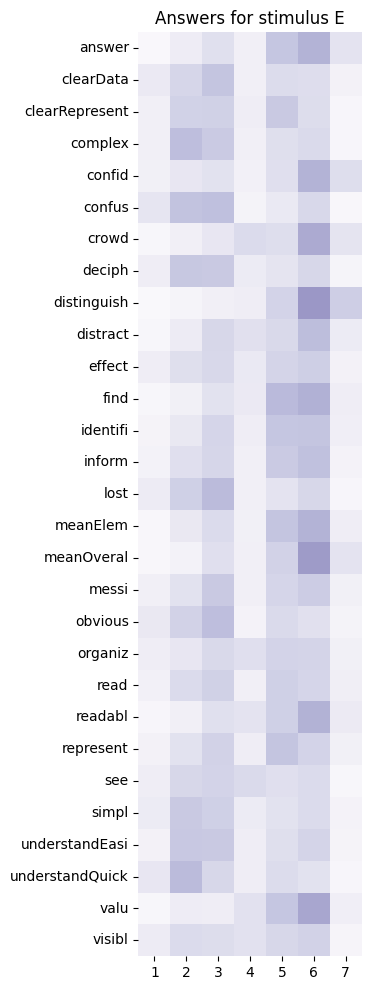

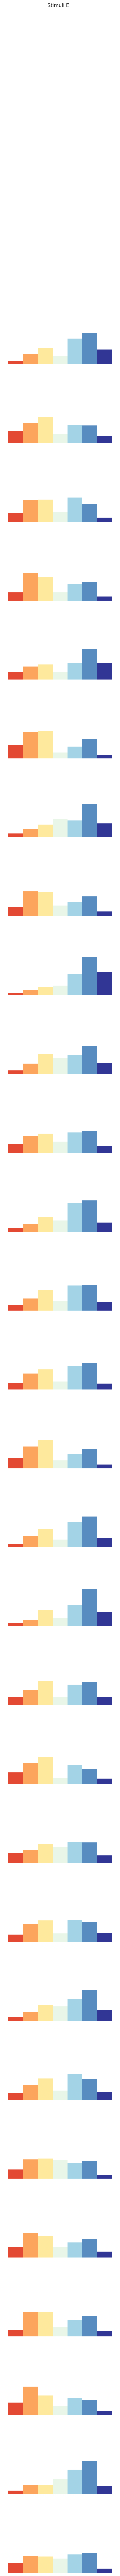

In [66]:
plot_data('E')

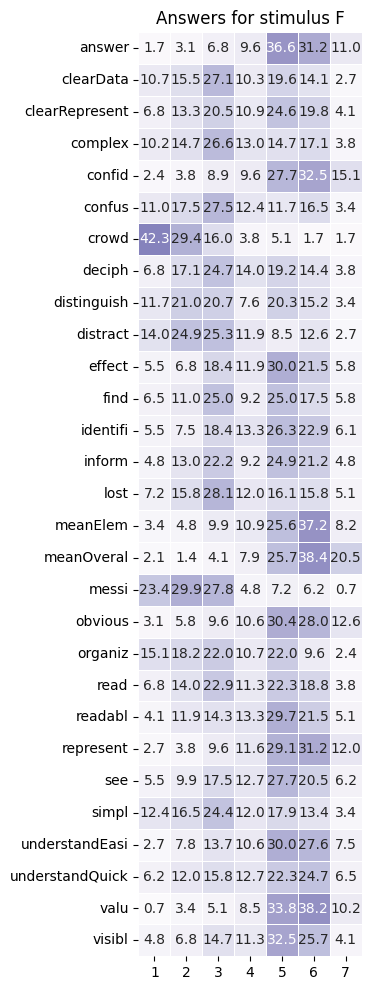

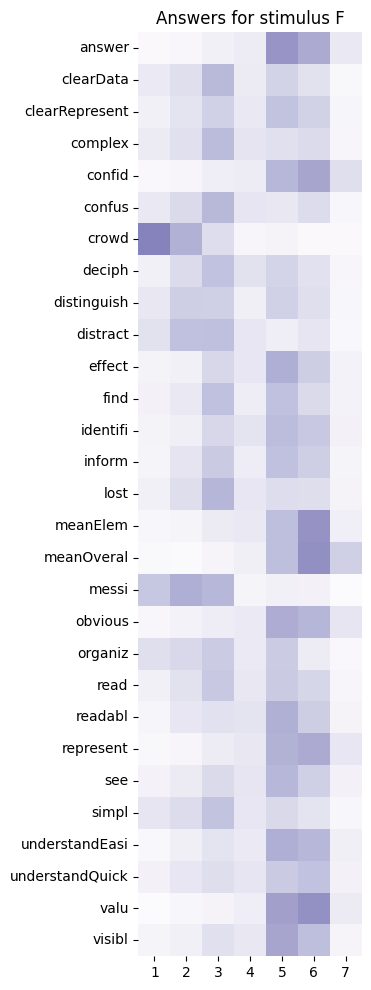

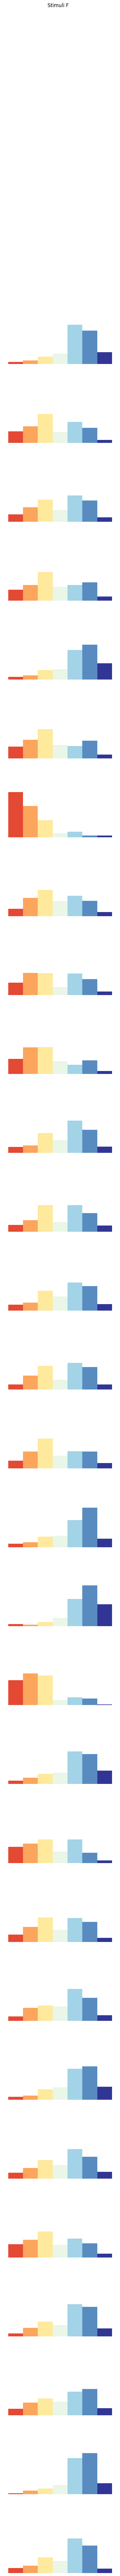

In [67]:
plot_data('F')

# Missing values

In [68]:
missing_dfs = []
for stimuli in stimuli_dfs.keys():
    this_df = stimuli_dfs[stimuli]['ratings']
    this_df_len = len(this_df)
    this_df_missing_total = this_df.isnull().sum().sum()/(this_df.shape[0]*this_df.shape[1])*100
    print(f'{this_df_missing_total.round(2)}% missing data in {stimuli} answers')
    #this_df_missing = this_df.isnull().sum()/this_df_len*100
    this_df_missing = pd.DataFrame(this_df.isnull().mean().round(4).mul(100), columns=[f'Percentage Missing {stimuli}'])
    this_df_missing.loc["OVERALL"] = [this_df_missing_total.round(2)]
    missing_dfs.append(this_df_missing)

all_missing = pd.concat(missing_dfs, axis=1)
all_missing.to_csv(f'{outdir}/all_missing_data_frequencies.csv')
all_missing

0.25% missing data in A answers
0.14% missing data in B answers
0.22% missing data in C answers
0.45% missing data in D answers
0.84% missing data in E answers
0.28% missing data in F answers


Percentage Missing A  Percentage Missing B   
answer                           0.35                  0.35  \
clearData                        0.35                  0.00   
clearRepresent                   0.35                  0.00   
complex                          0.00                  0.35   
confid                           0.00                  0.00   
confus                           0.00                  0.00   
crowd                            0.00                  0.00   
deciph                           0.00                  0.35   
distinguish                      1.04                  0.00   
distract                         0.00                  1.04   
effect                           0.35                  0.00   
find                             0.69                  0.00   
identifi                         0.35                  0.00   
inform                           0.00                  0.00   
lost                             0.00                  0.35   
meanElem                         0.00                  0.00   
meanOveral                       0.00                  0.00   
messi                            0.00                  0.35   
obvious                          0.00                  0.00   
organiz                          0.35                  0.00   
read                             0.35                  0.00   
readabl                          0.35                  0.35   
represent                        0.00                  0.00   
see                              0.69                  0.69   
simpl                            0.35                  0.00   
understandEasi                   0.00                  0.00   
understandQuick                  0.00                  0.00   
valu                             0.69                  0.00   
visibl                           1.04                  0.35   
OVERALL                          0.25                  0.14   

                 Percentage Missing C  Percentage Missing D   
answer                           0.35                  0.00  \
clearData                        0.00                  0.00   
clearRepresent                   0.35                  0.00   
complex                          0.00                  0.97   
confid                           0.00                  0.32   
confus                           0.35                  0.32   
crowd                            0.00                  0.65   
deciph                           0.00                  0.65   
distinguish                      0.70                  0.65   
distract                         0.70                  0.00   
effect                           0.00                  0.32   
find                             0.00                  0.00   
identifi                         0.00                  0.65   
inform                           0.35                  0.00   
lost                             0.00                  0.00   
meanElem                         0.00                  0.65   
meanOveral                       0.00                  0.65   
messi                            0.00                  0.00   
obvious                          0.35                  0.00   
organiz                          0.00                  0.32   
read                             0.35                  1.29   
readabl                          0.00                  0.65   
represent                        0.35                  0.65   
see                              0.35                  0.32   
simpl                            0.00                  0.65   
understandEasi                   0.00                  0.65   
understandQuick                  0.35                  0.97   
valu                             1.39                  0.97   
visibl                           0.35                  0.65   
OVERALL                          0.22                  0.45   

                 Percentage Missing E  Percentage Missing F  
answer                           0.68          

## Missingno library
at https://github.com/ResidentMario/missingno?tab=readme-ov-file

In [69]:
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

## All plots at once

### Matrix view
The sparkline at right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset.

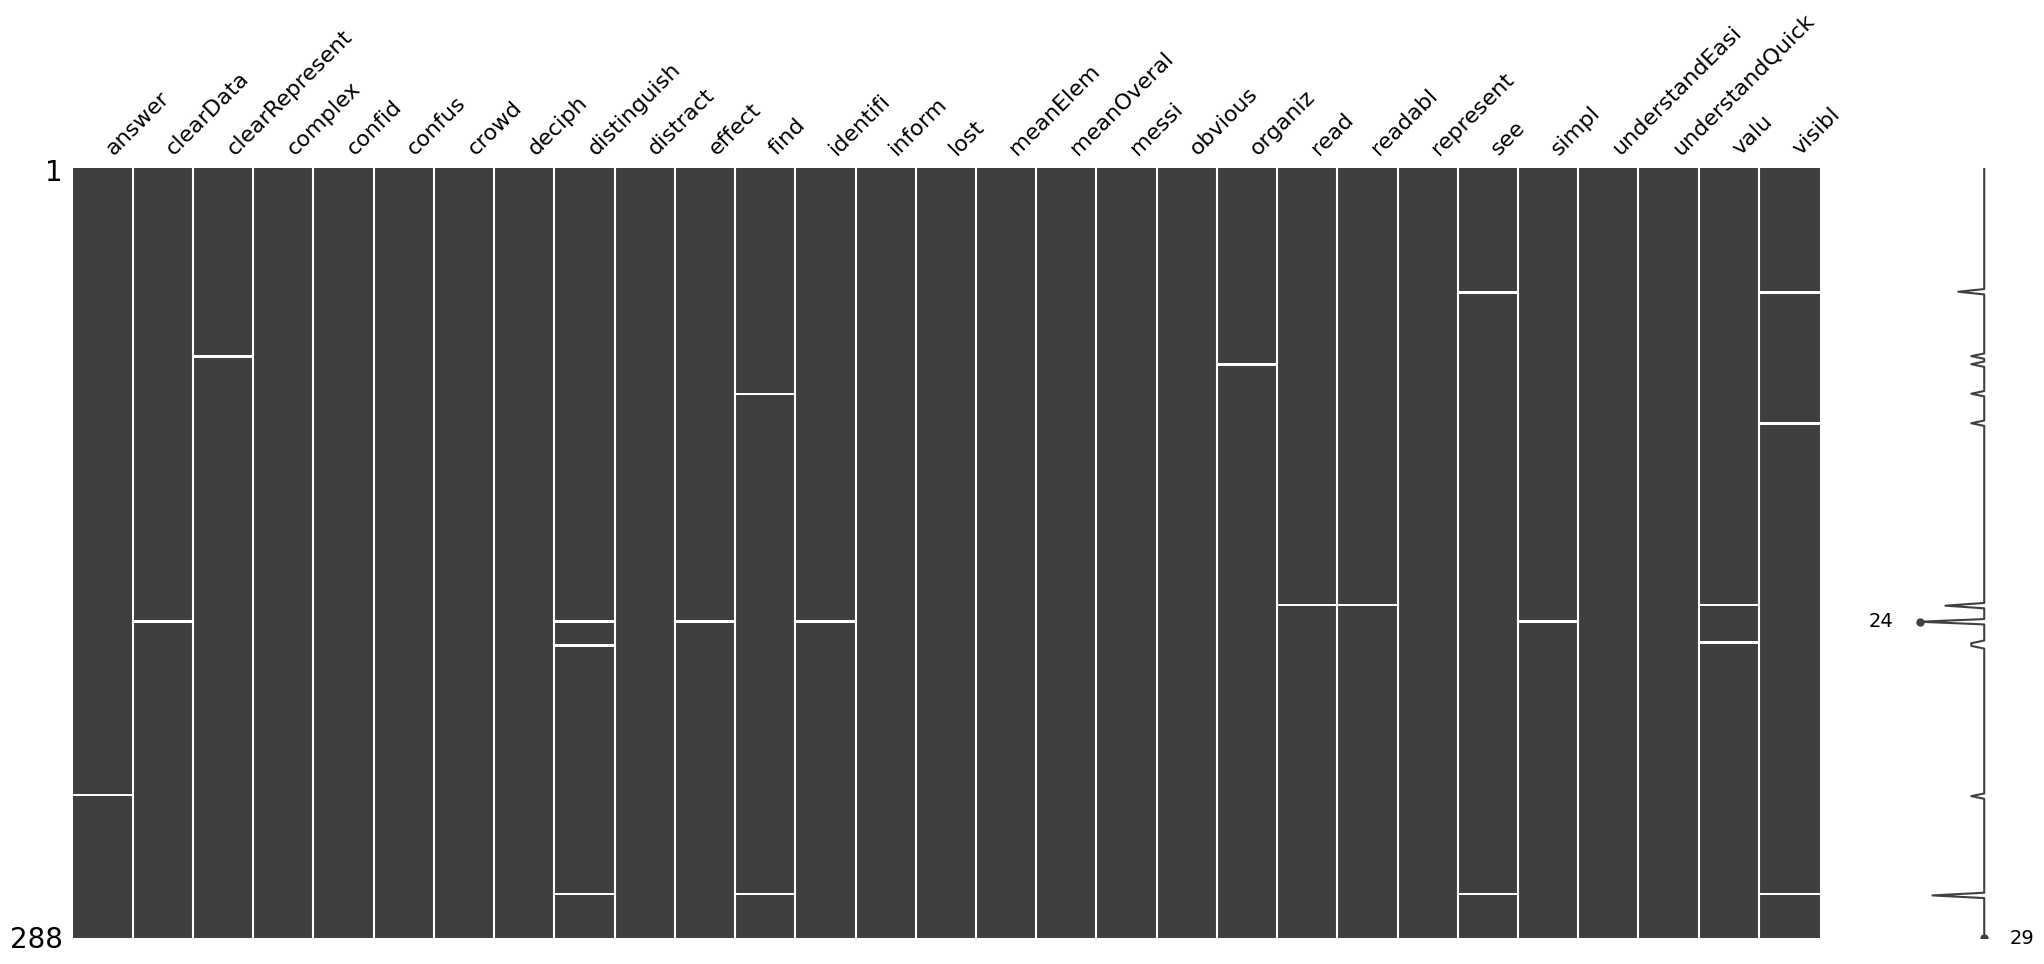

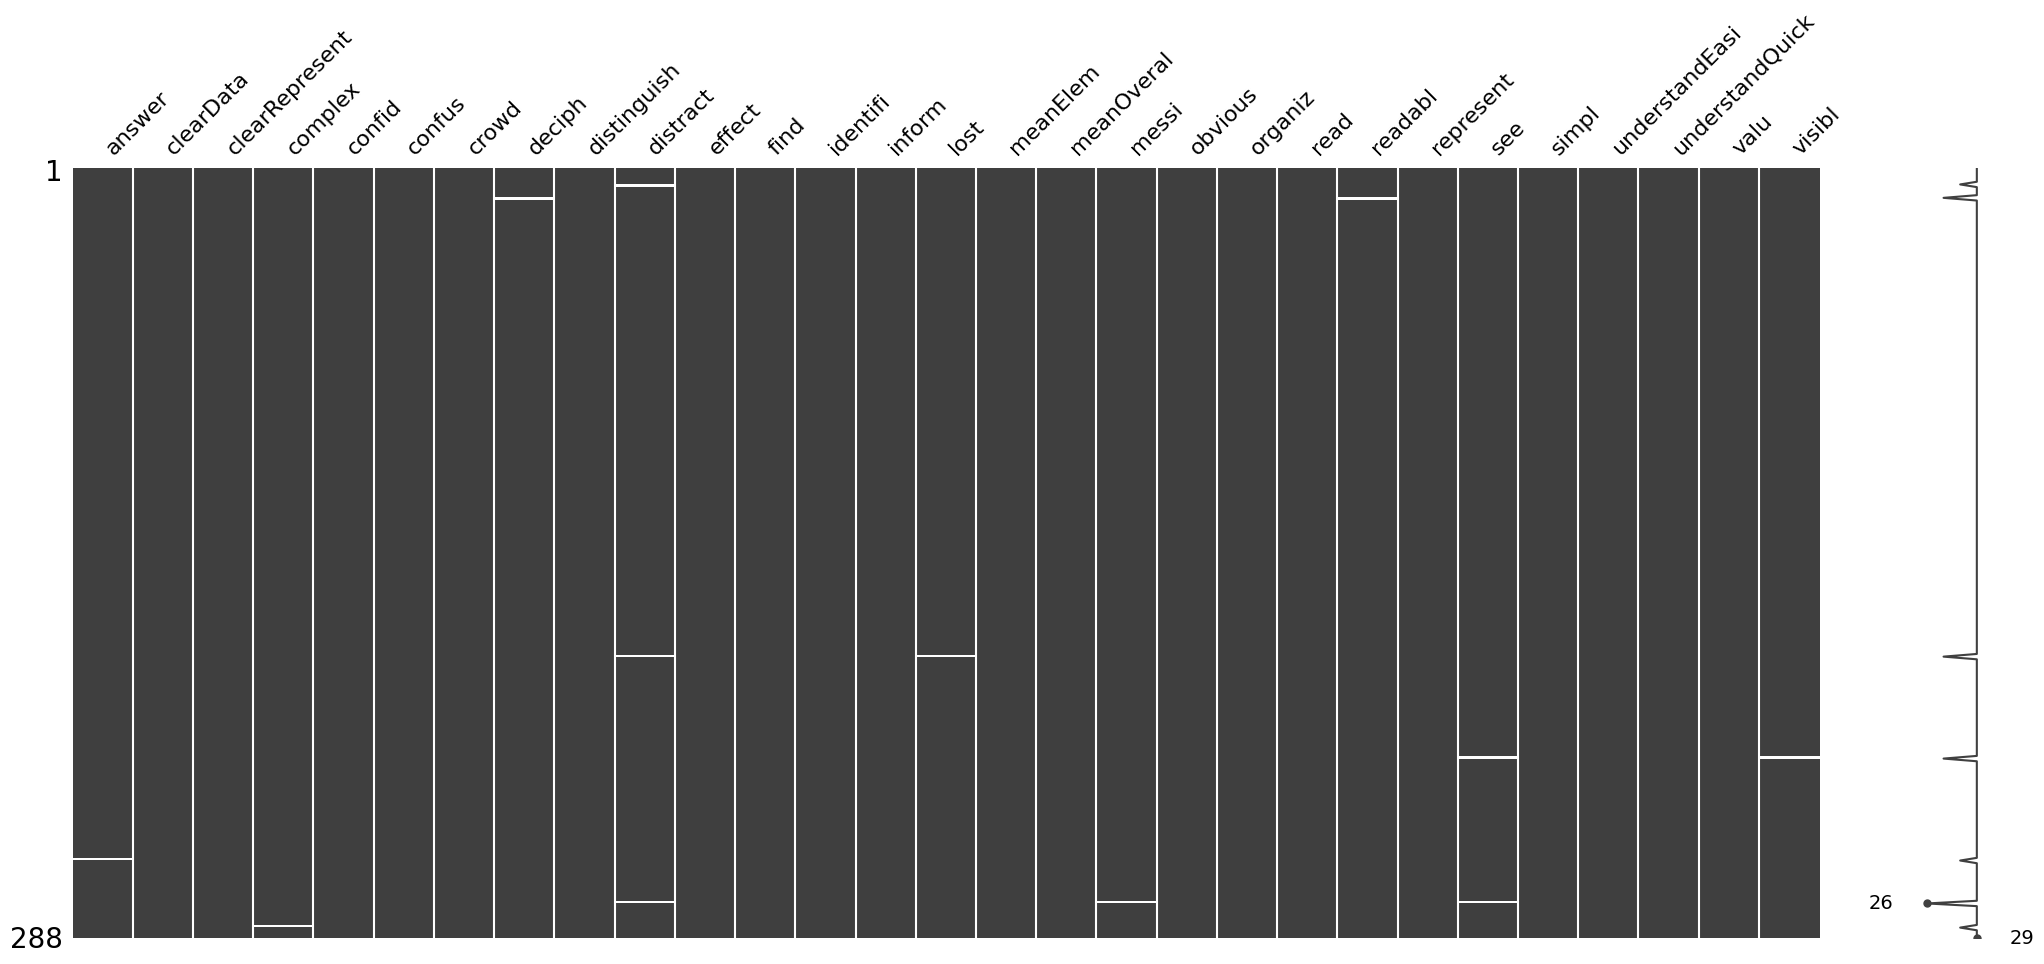

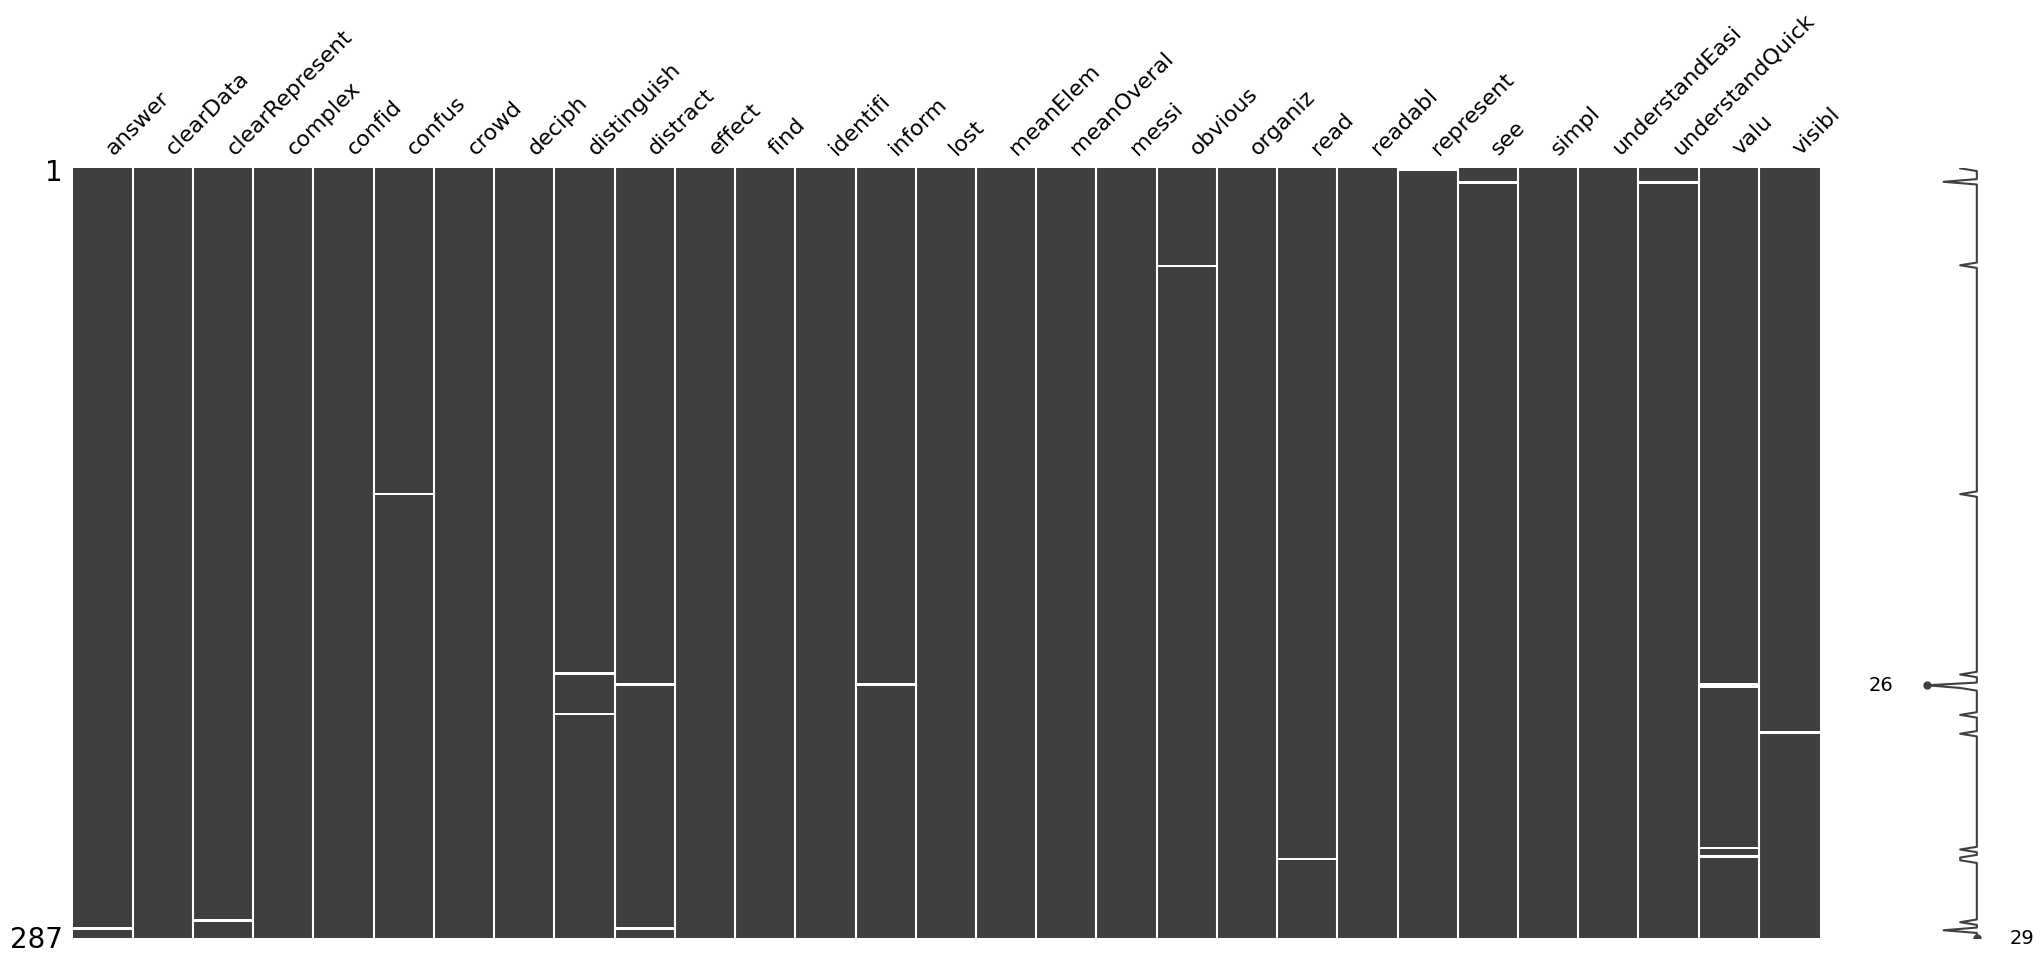

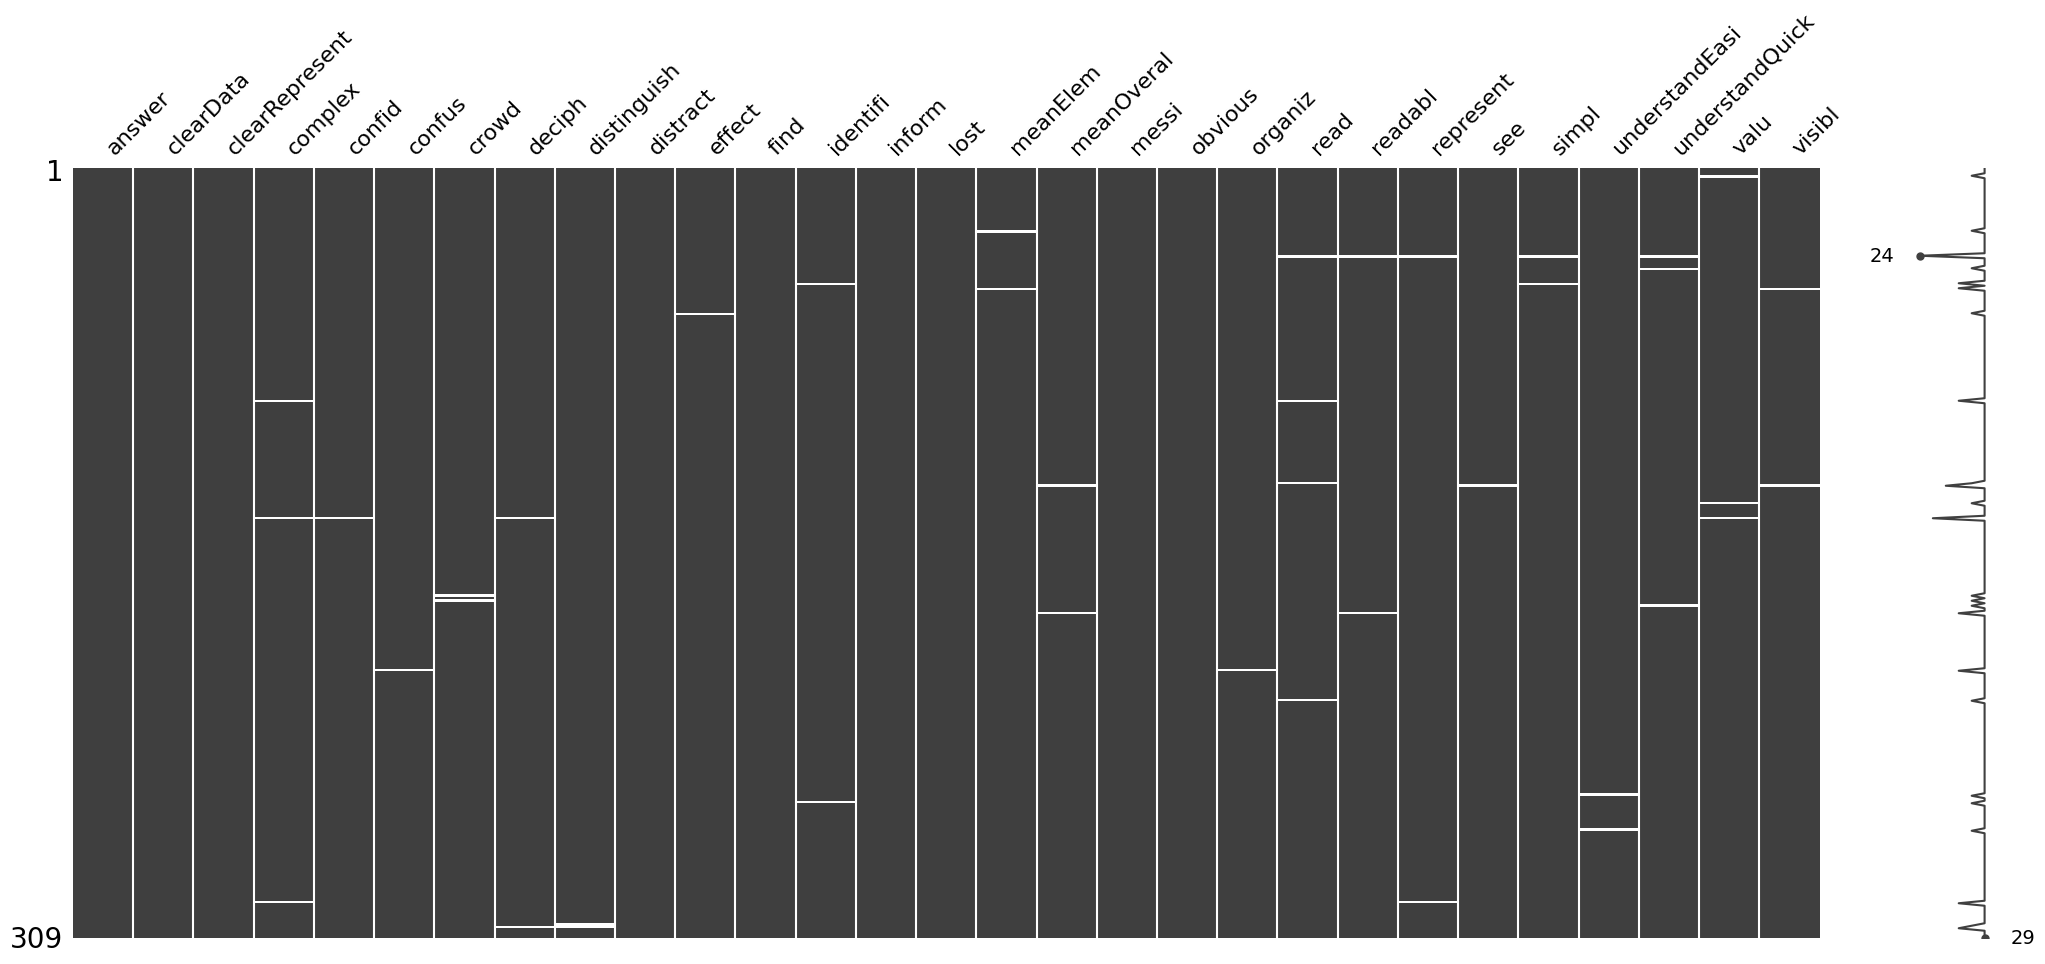

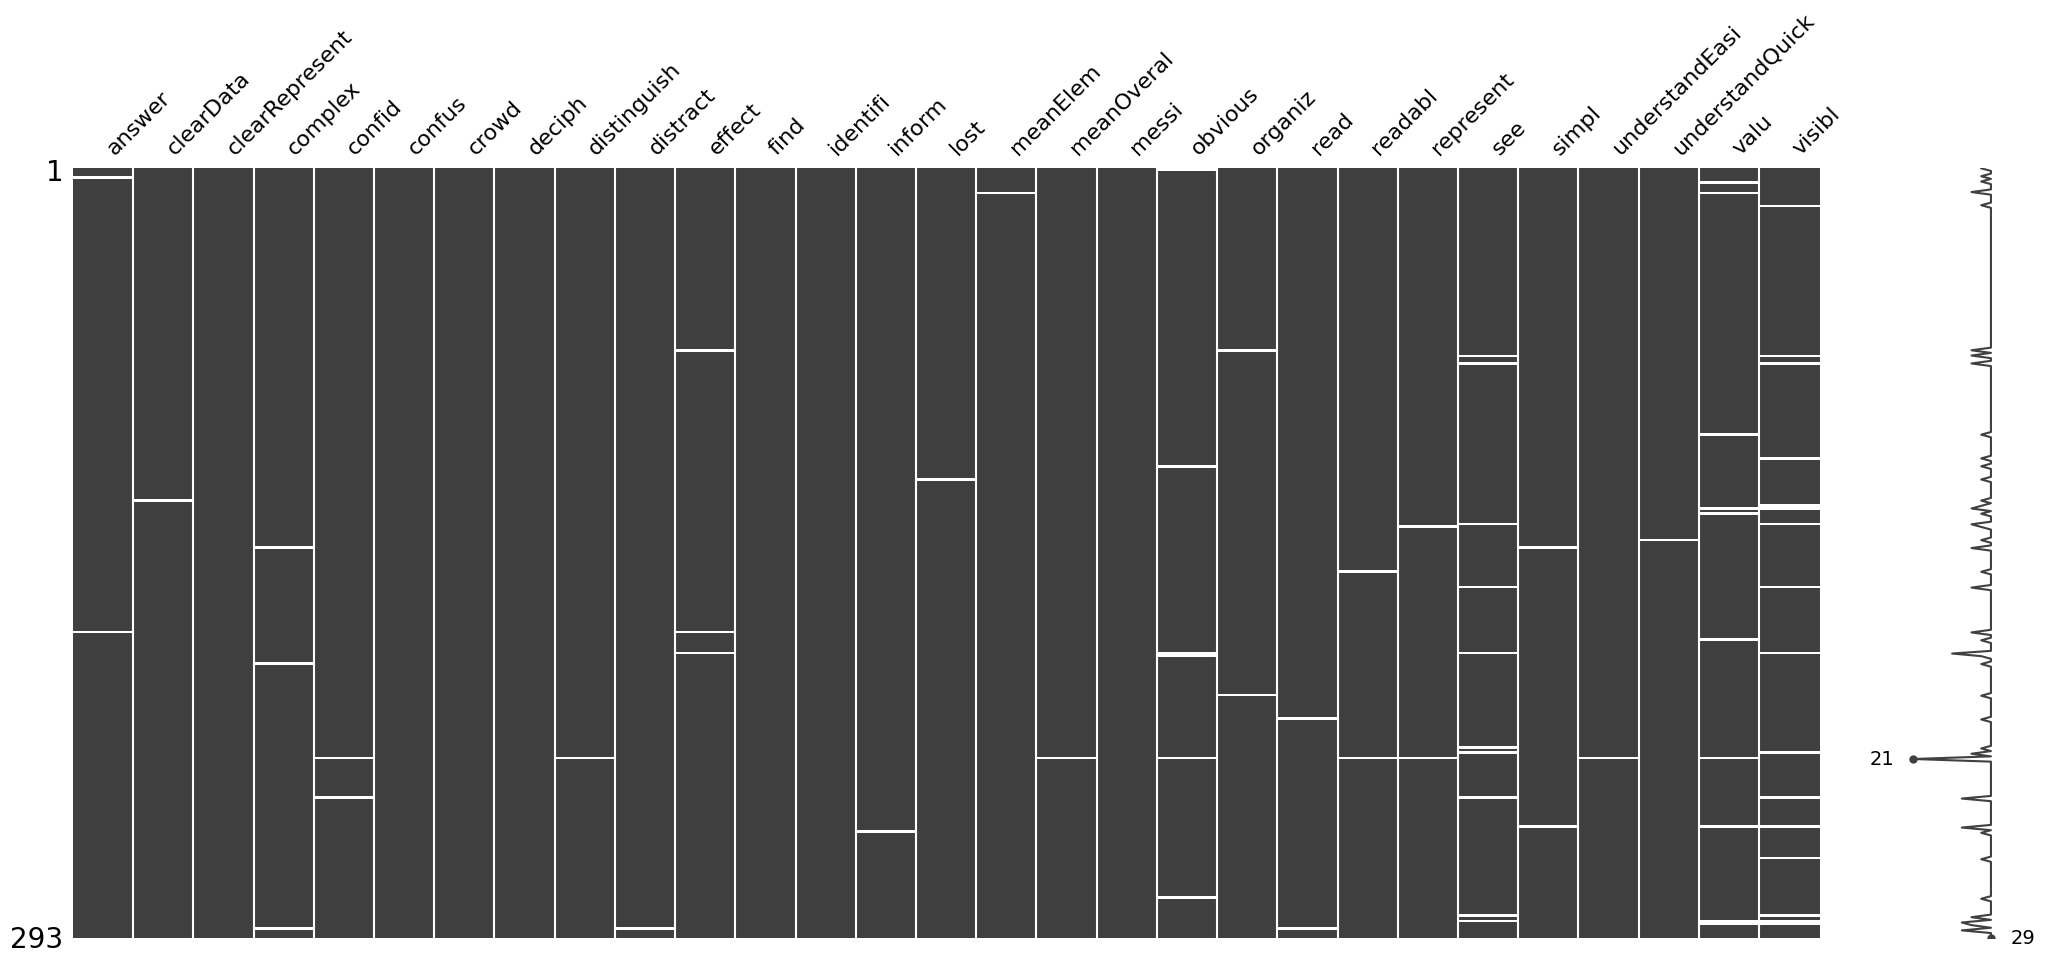

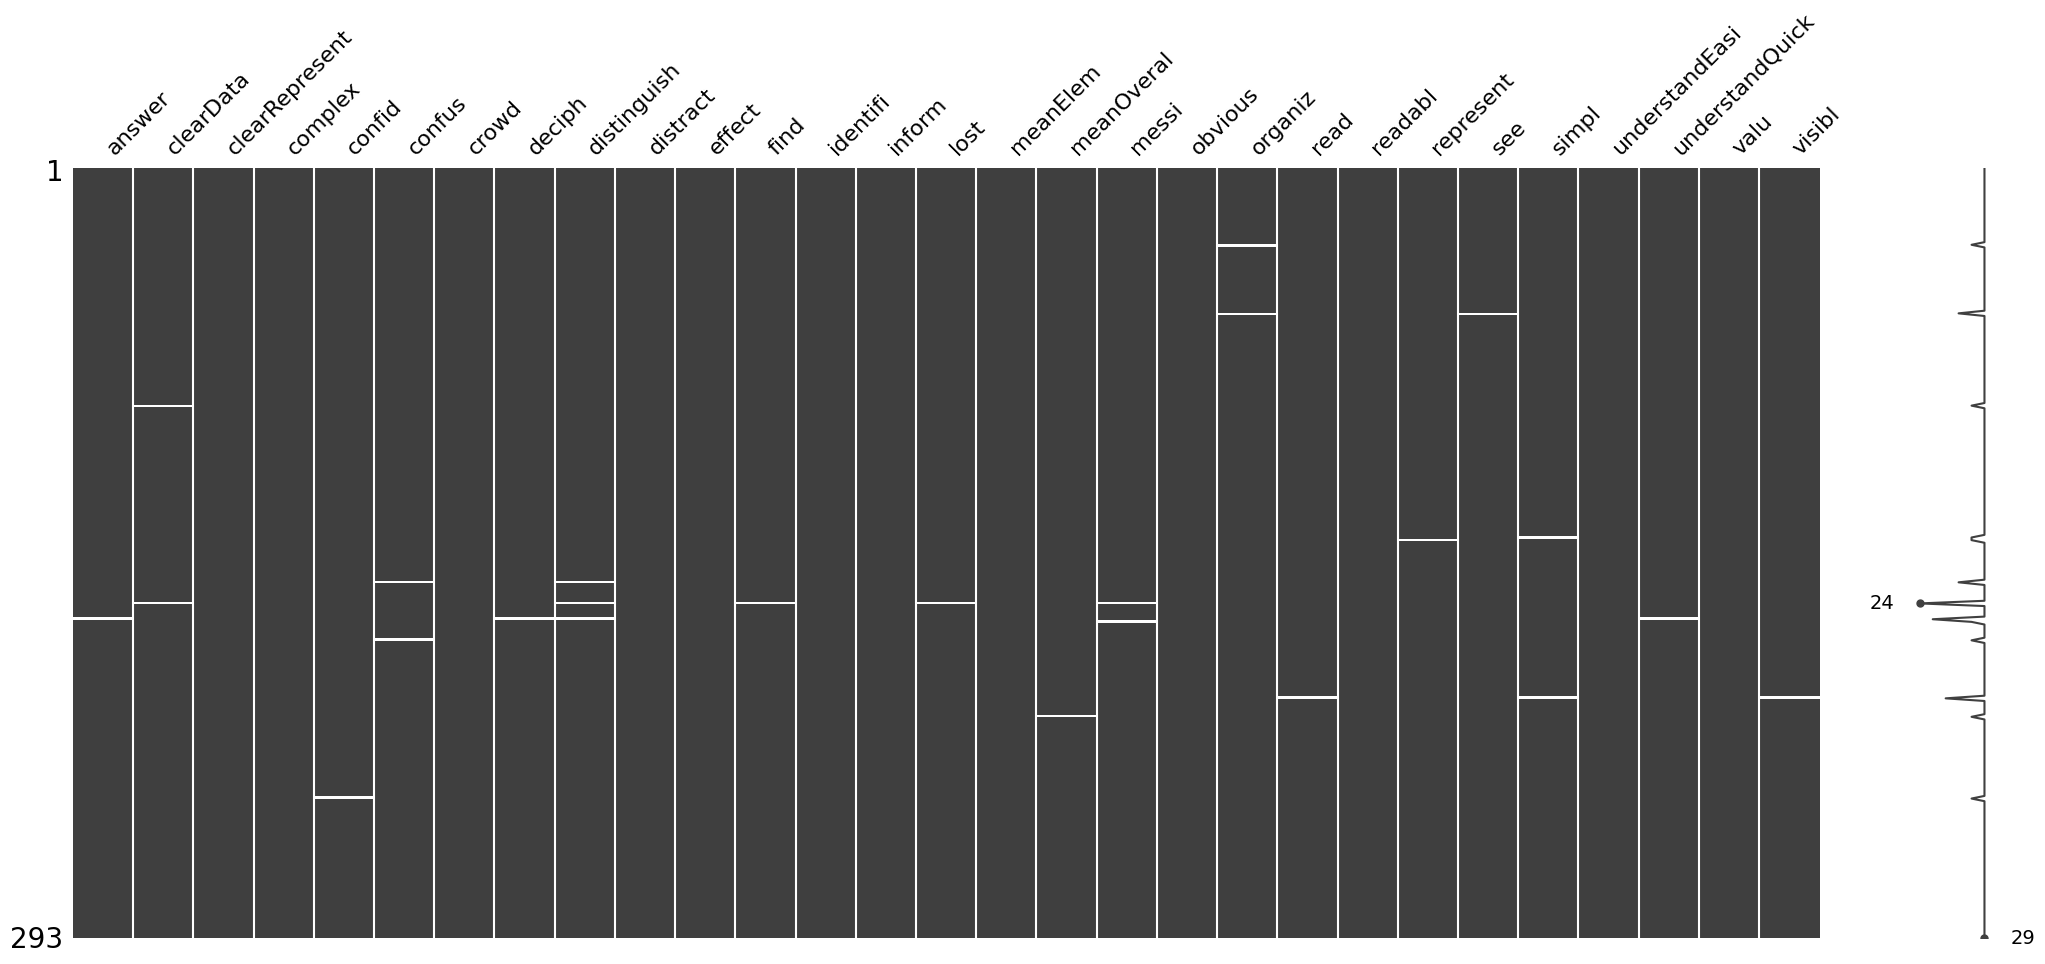

In [70]:
for stimuli in stimuli_dfs.keys():
    data = stimuli_dfs[stimuli]['ratings']
    #data = msno.nullity_sort(stimuli_dfs[stimuli]['ratings'], sort='ascending')
    msno.matrix(data)

### Heatmap view
Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does).

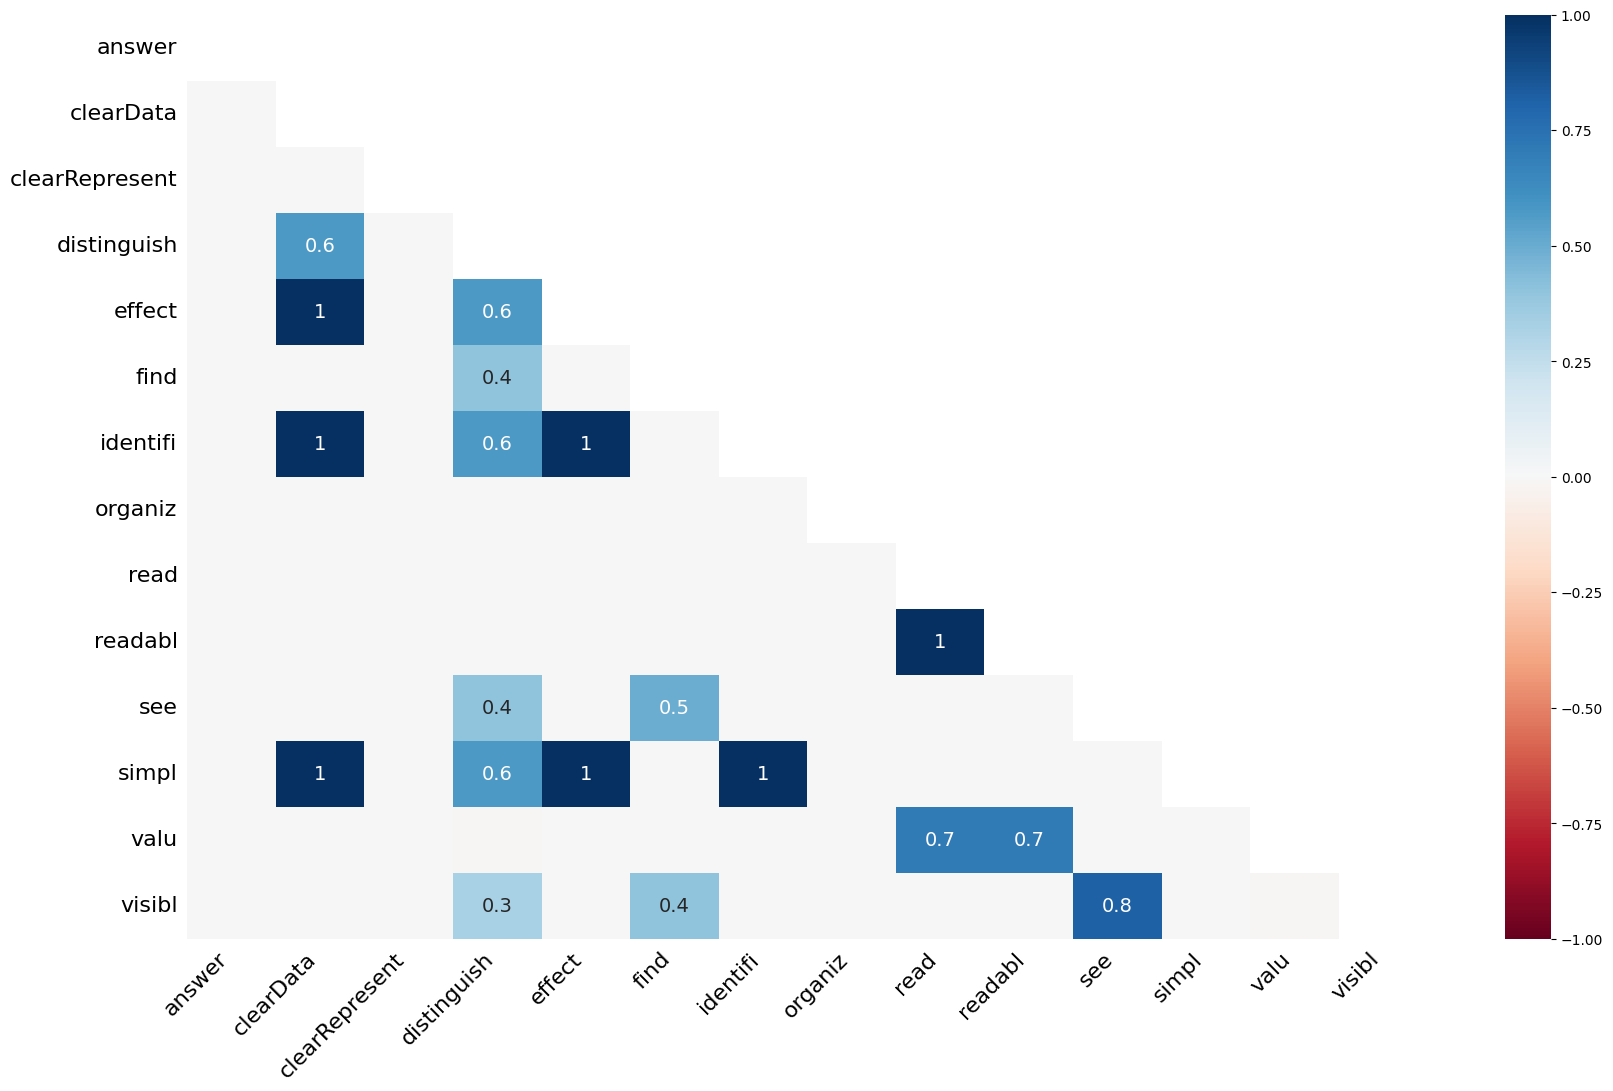

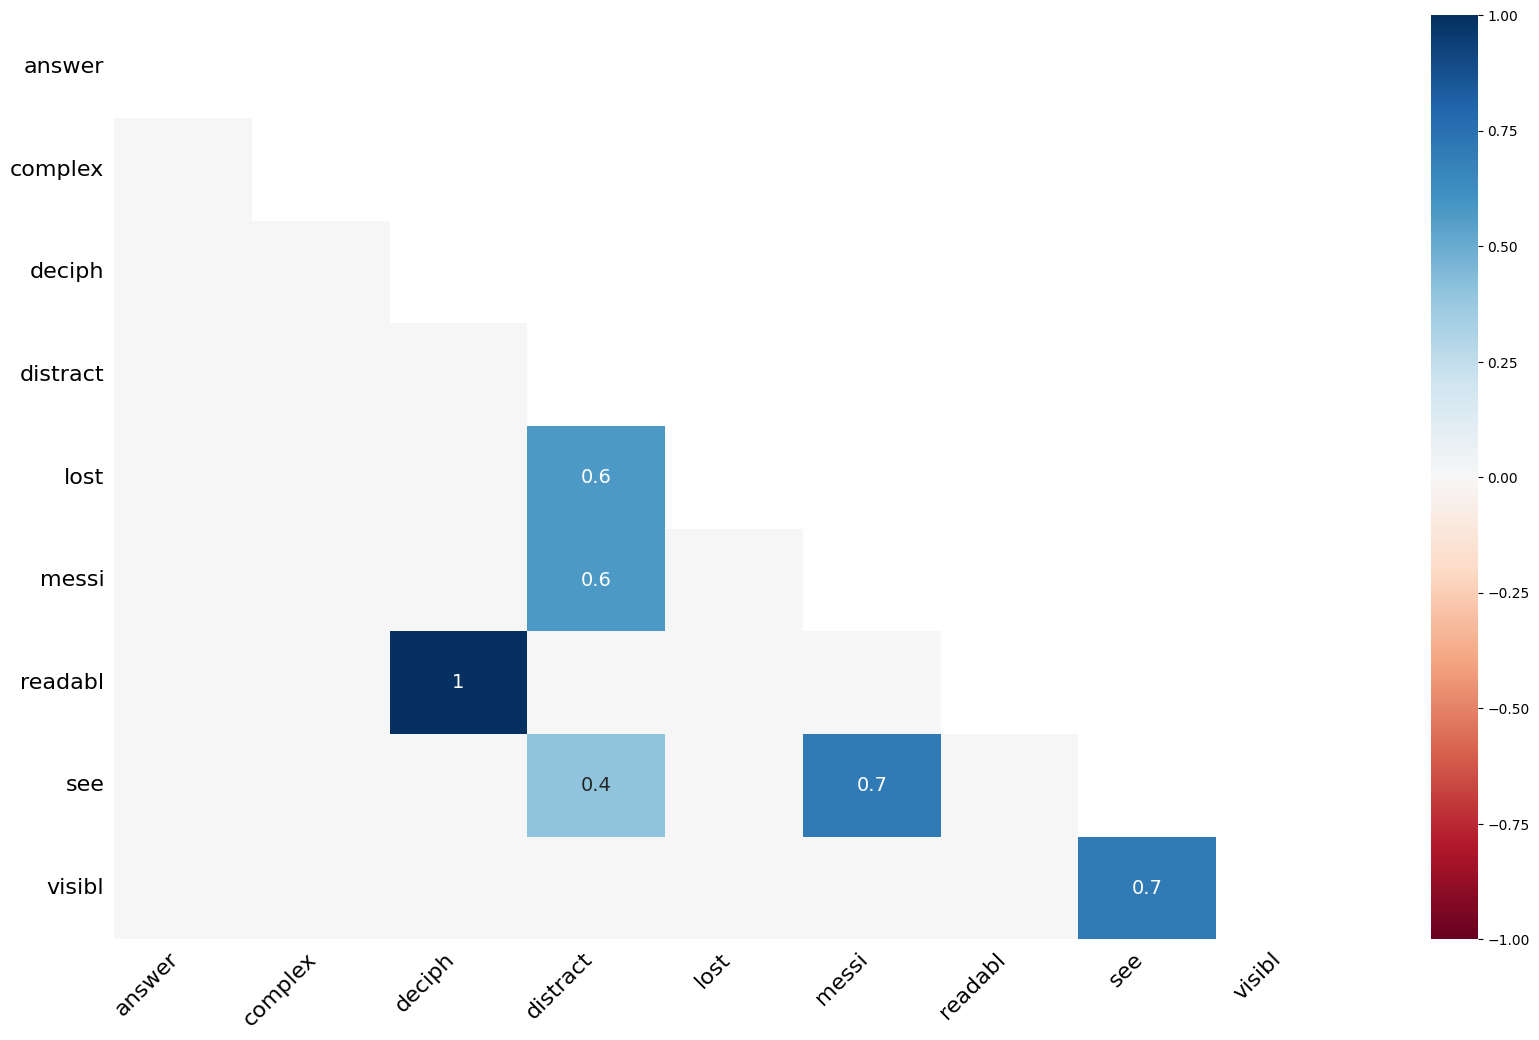

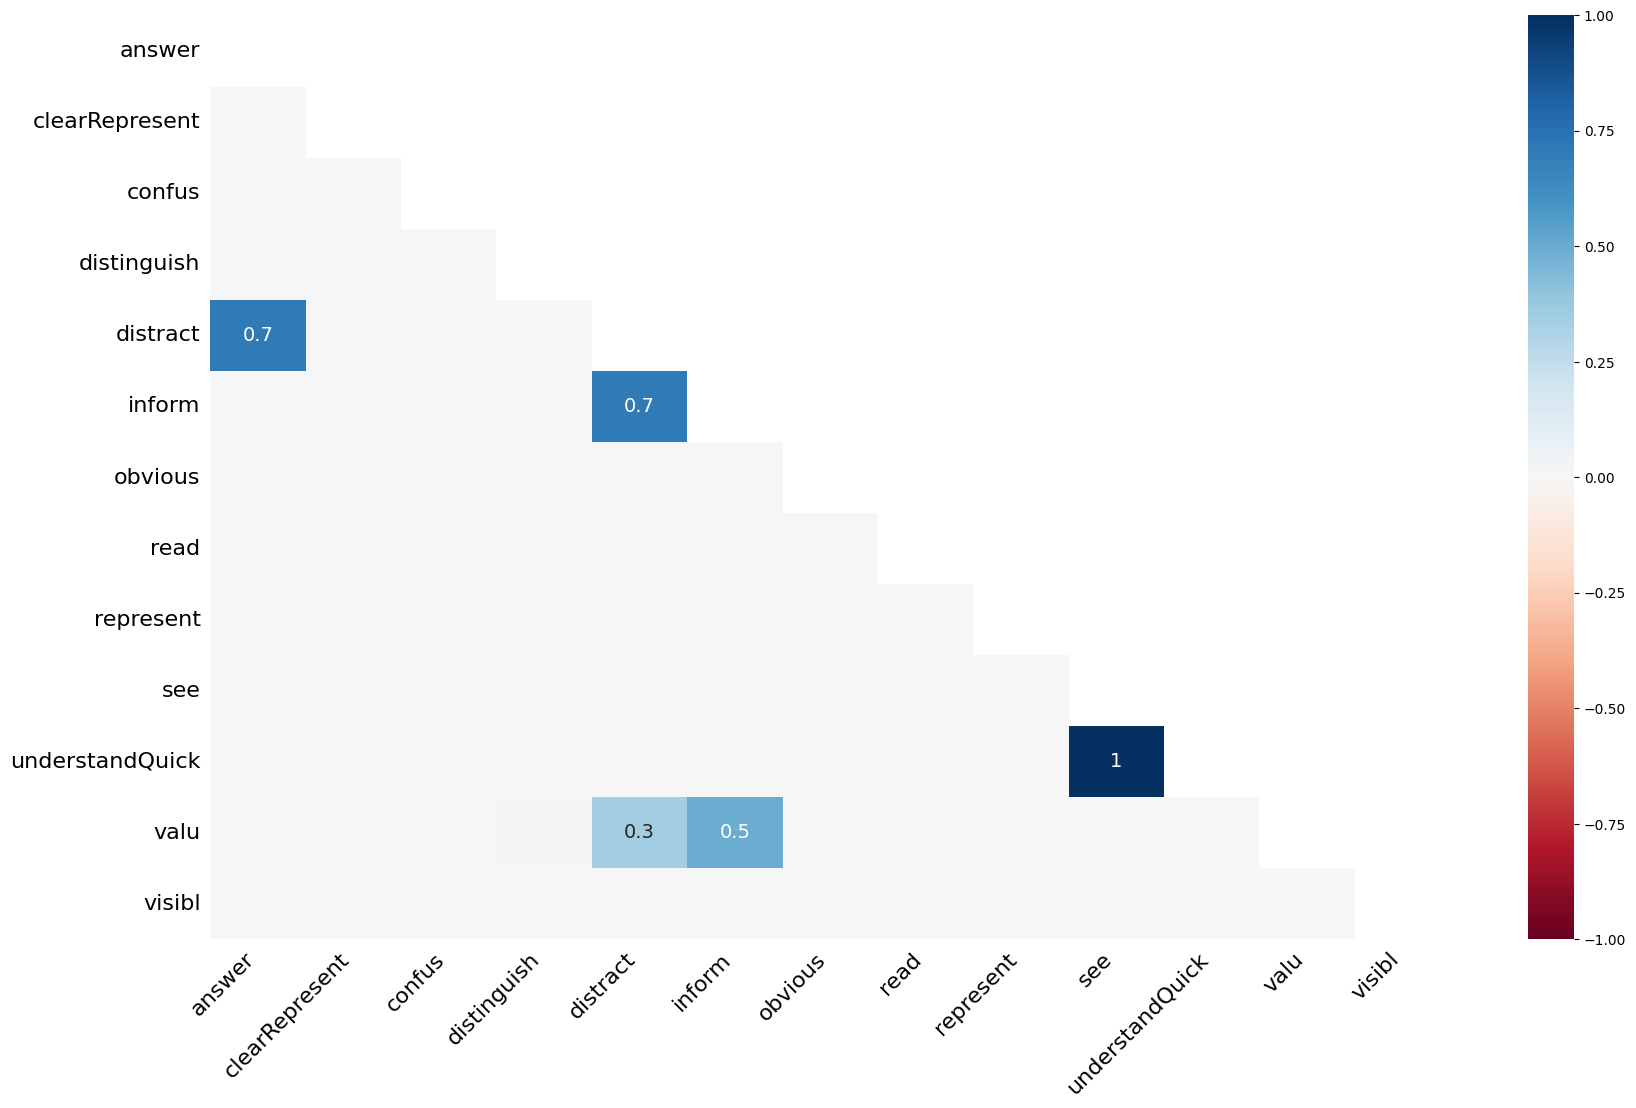

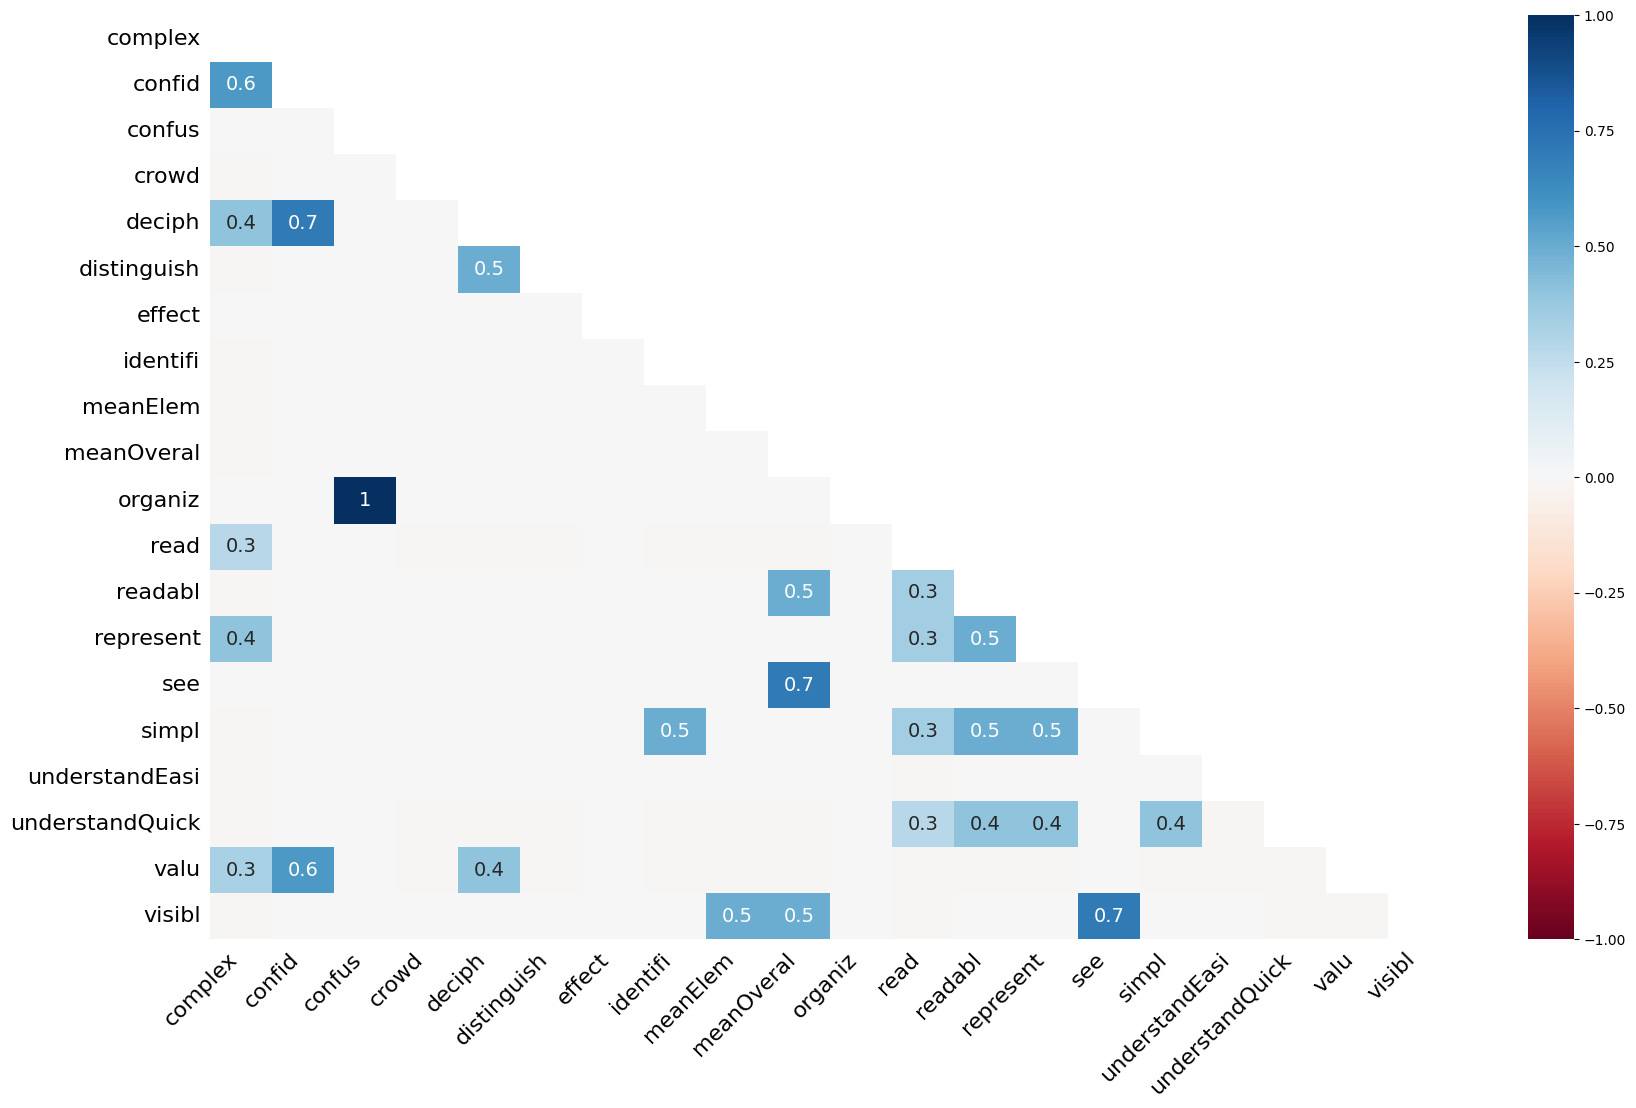

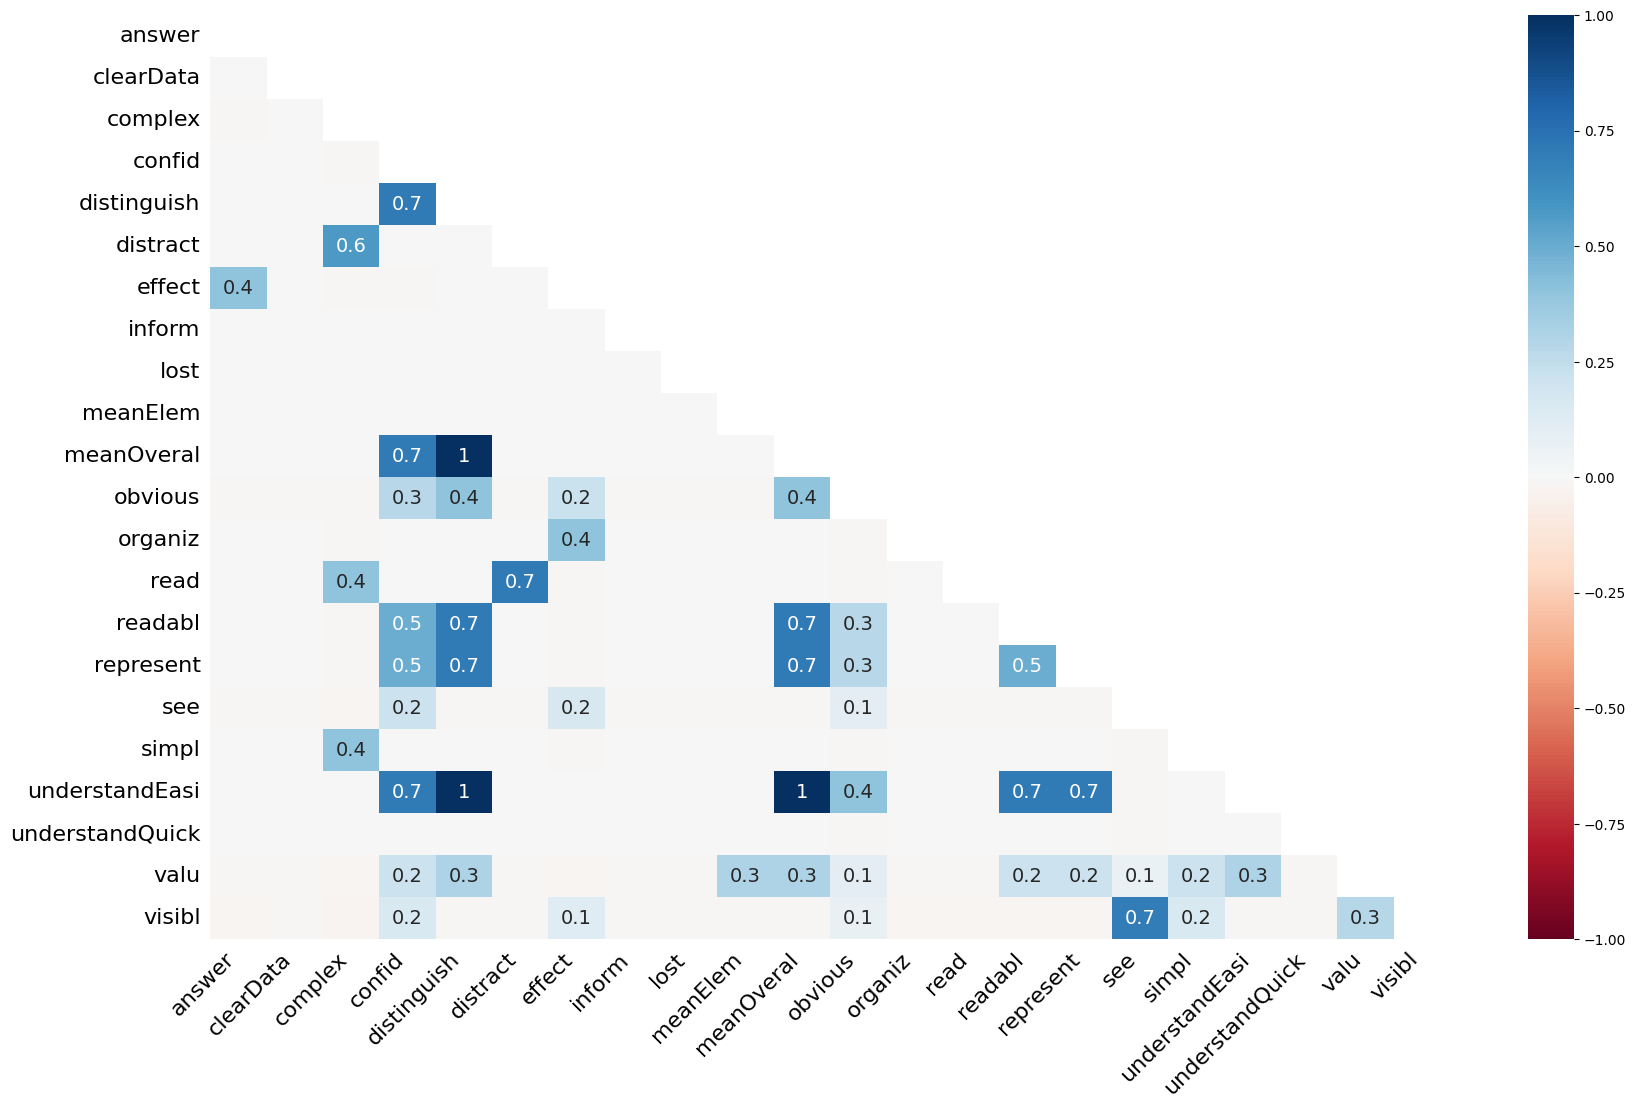

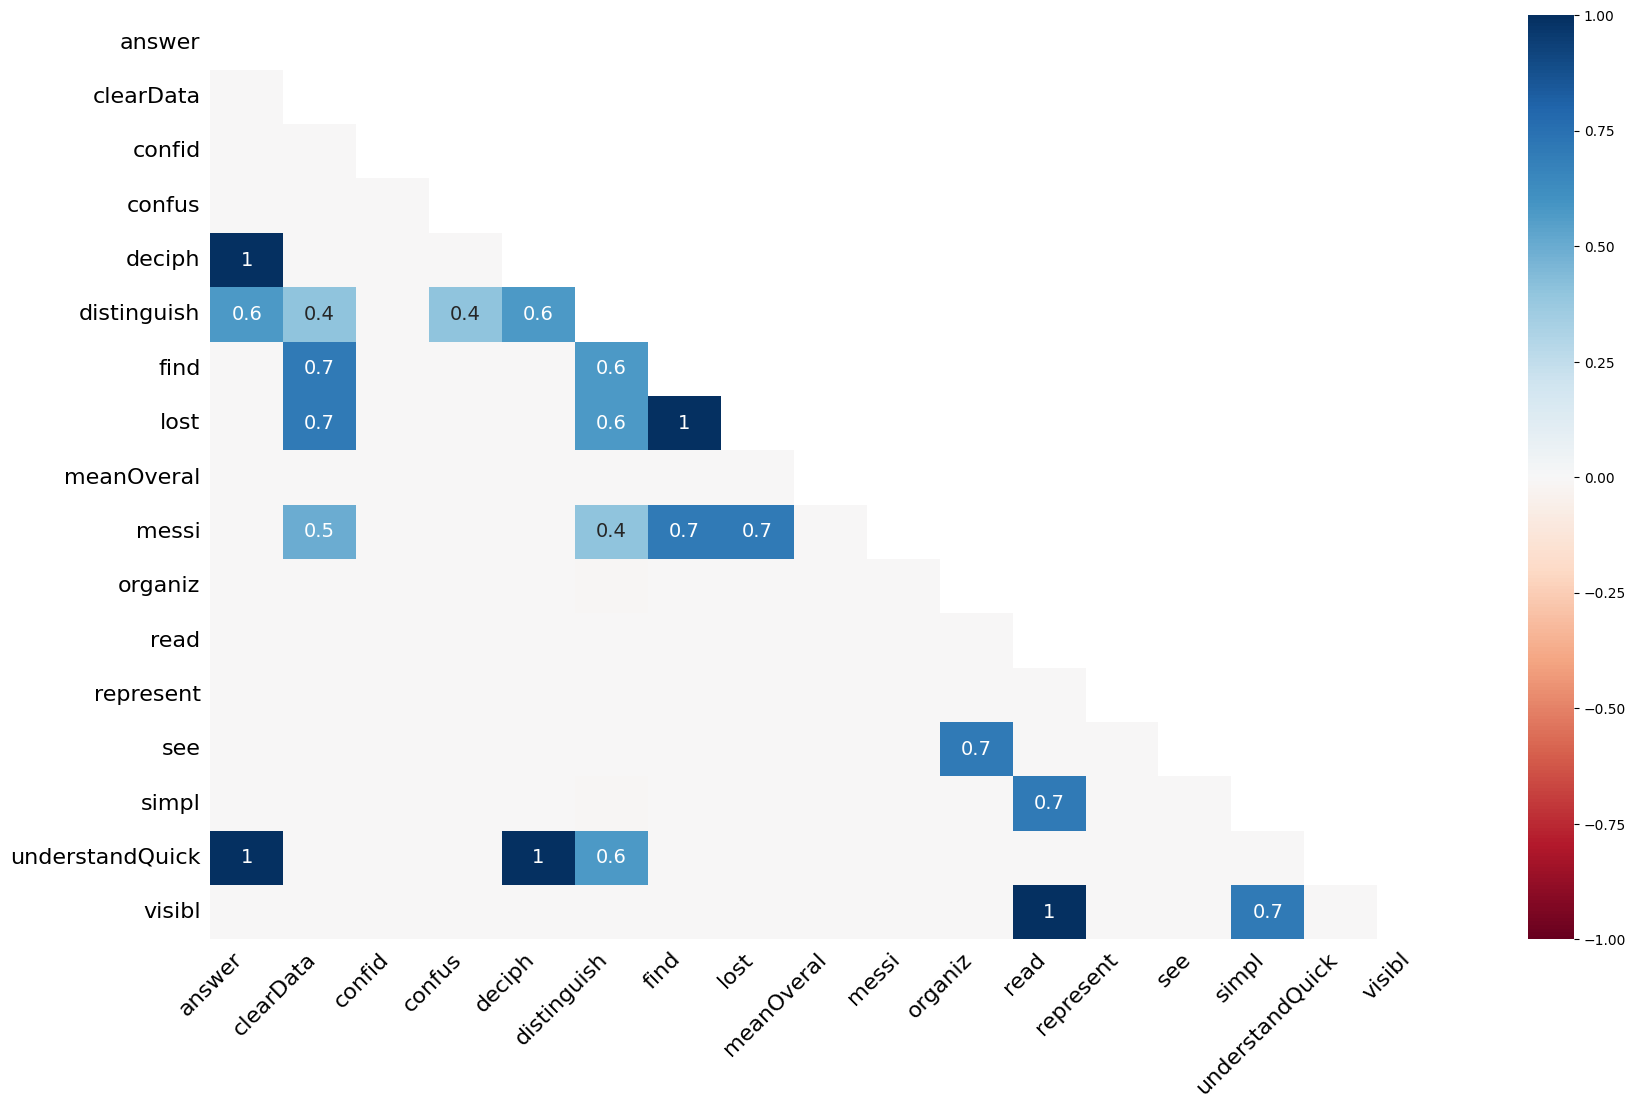

In [71]:
for stimuli in stimuli_dfs.keys():
    msno.heatmap(stimuli_dfs[stimuli]['ratings'])

### Dendrogram view
To interpret this graph, read it from a top-down perspective.

Cluster leaves which linked together at a distance of zero fully predict one another's presence—one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on. In this specific example the dendrogram glues together the variables which are required and therefore present in every record. 

Cluster leaves which split close to zero, but not at it, predict one another very well, but still imperfectly.

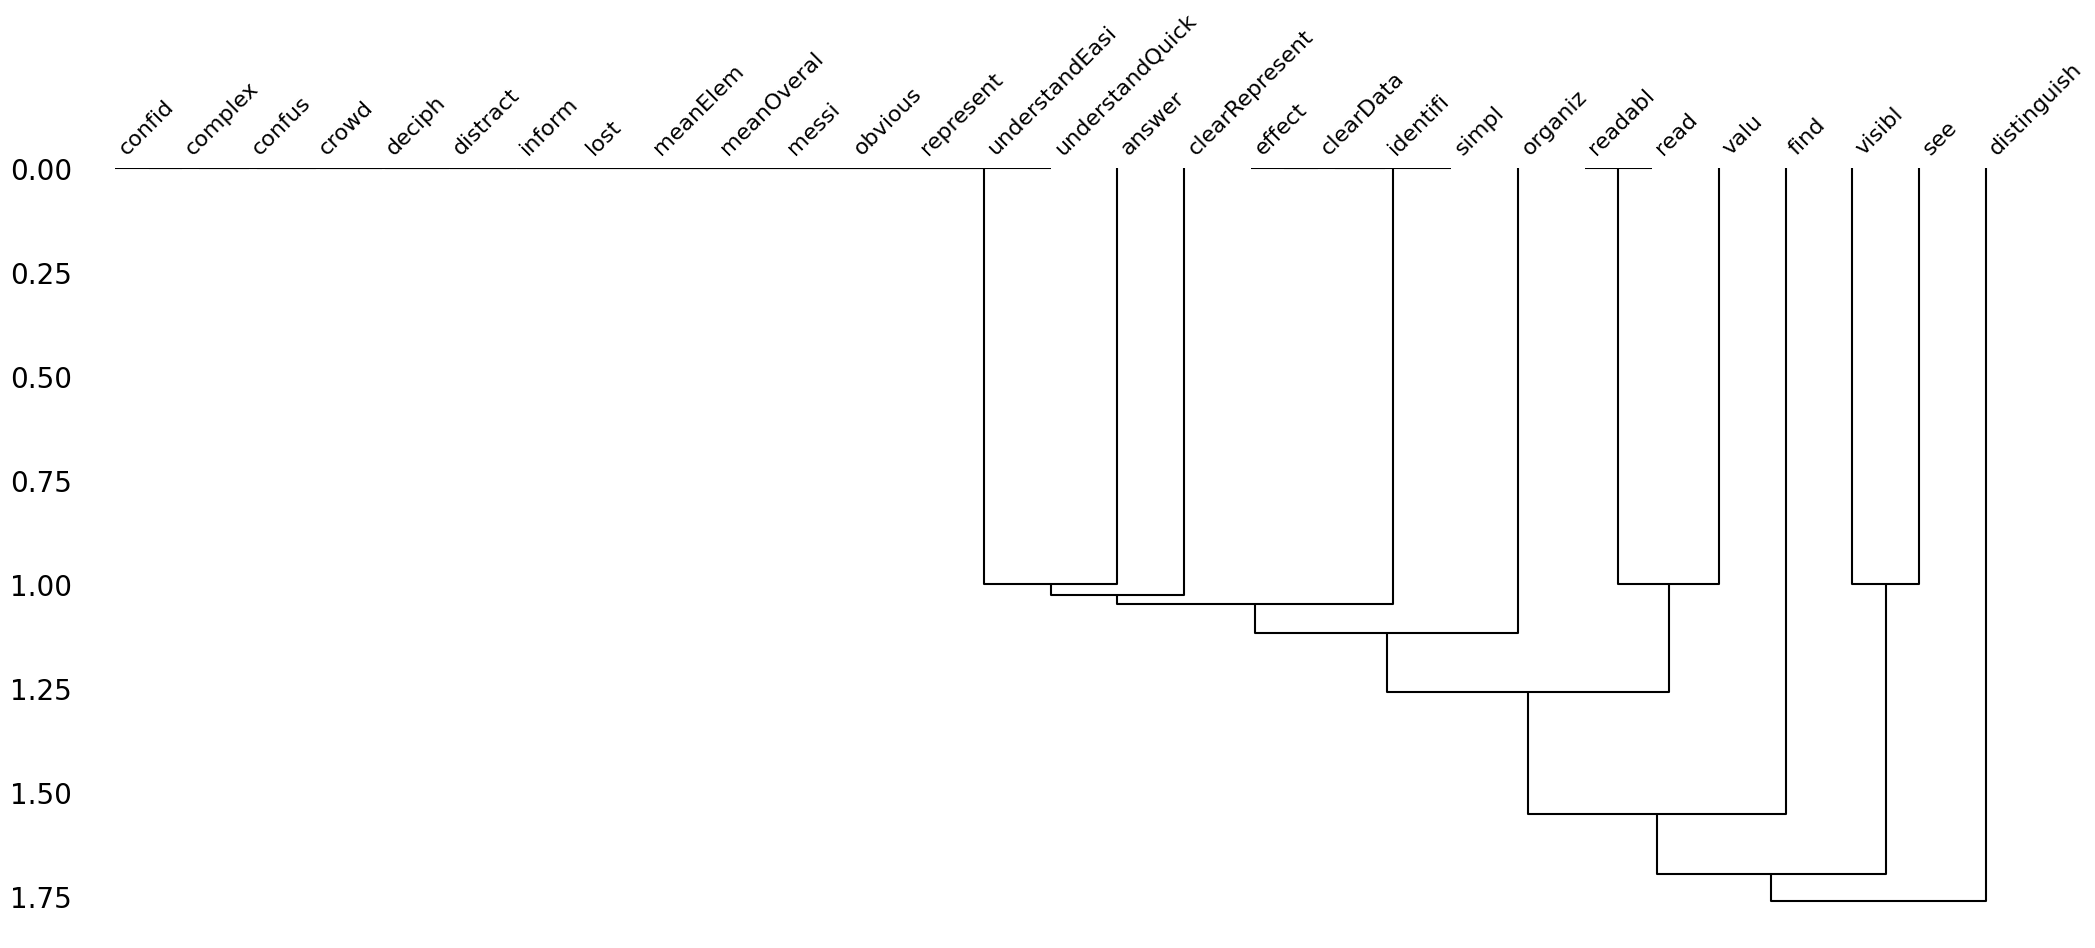

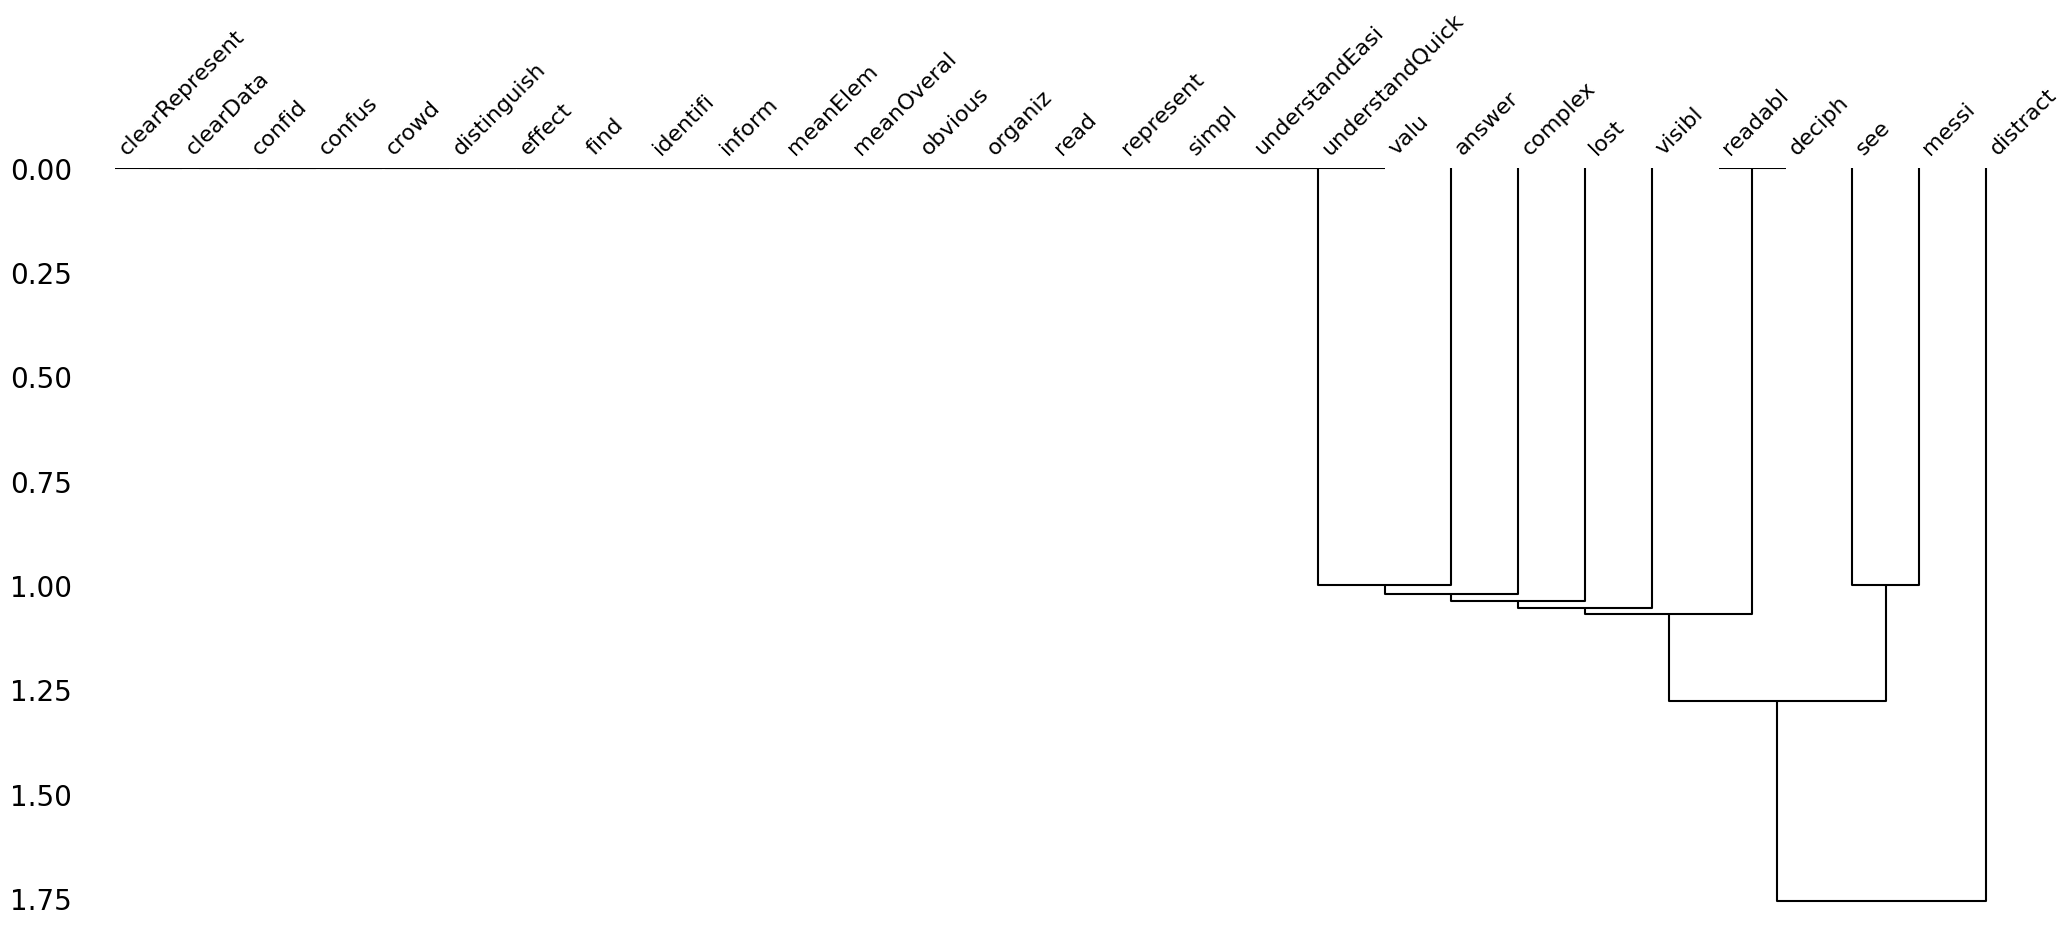

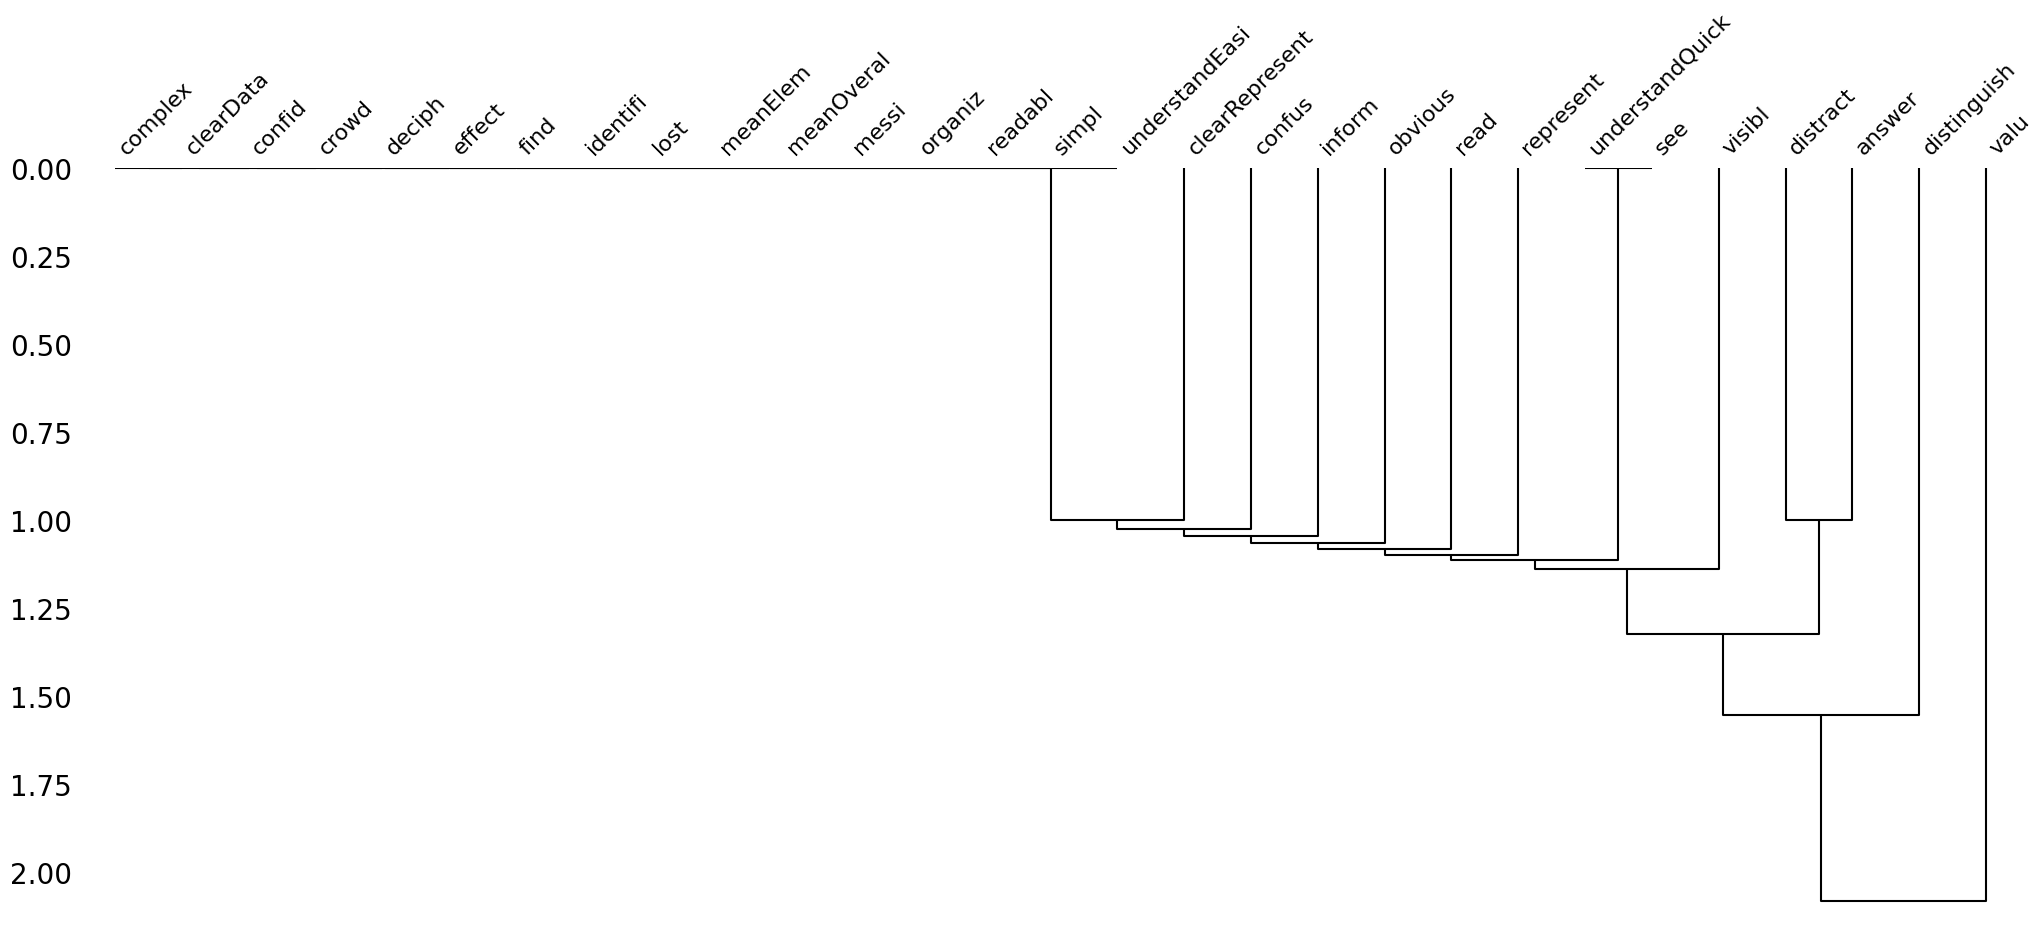

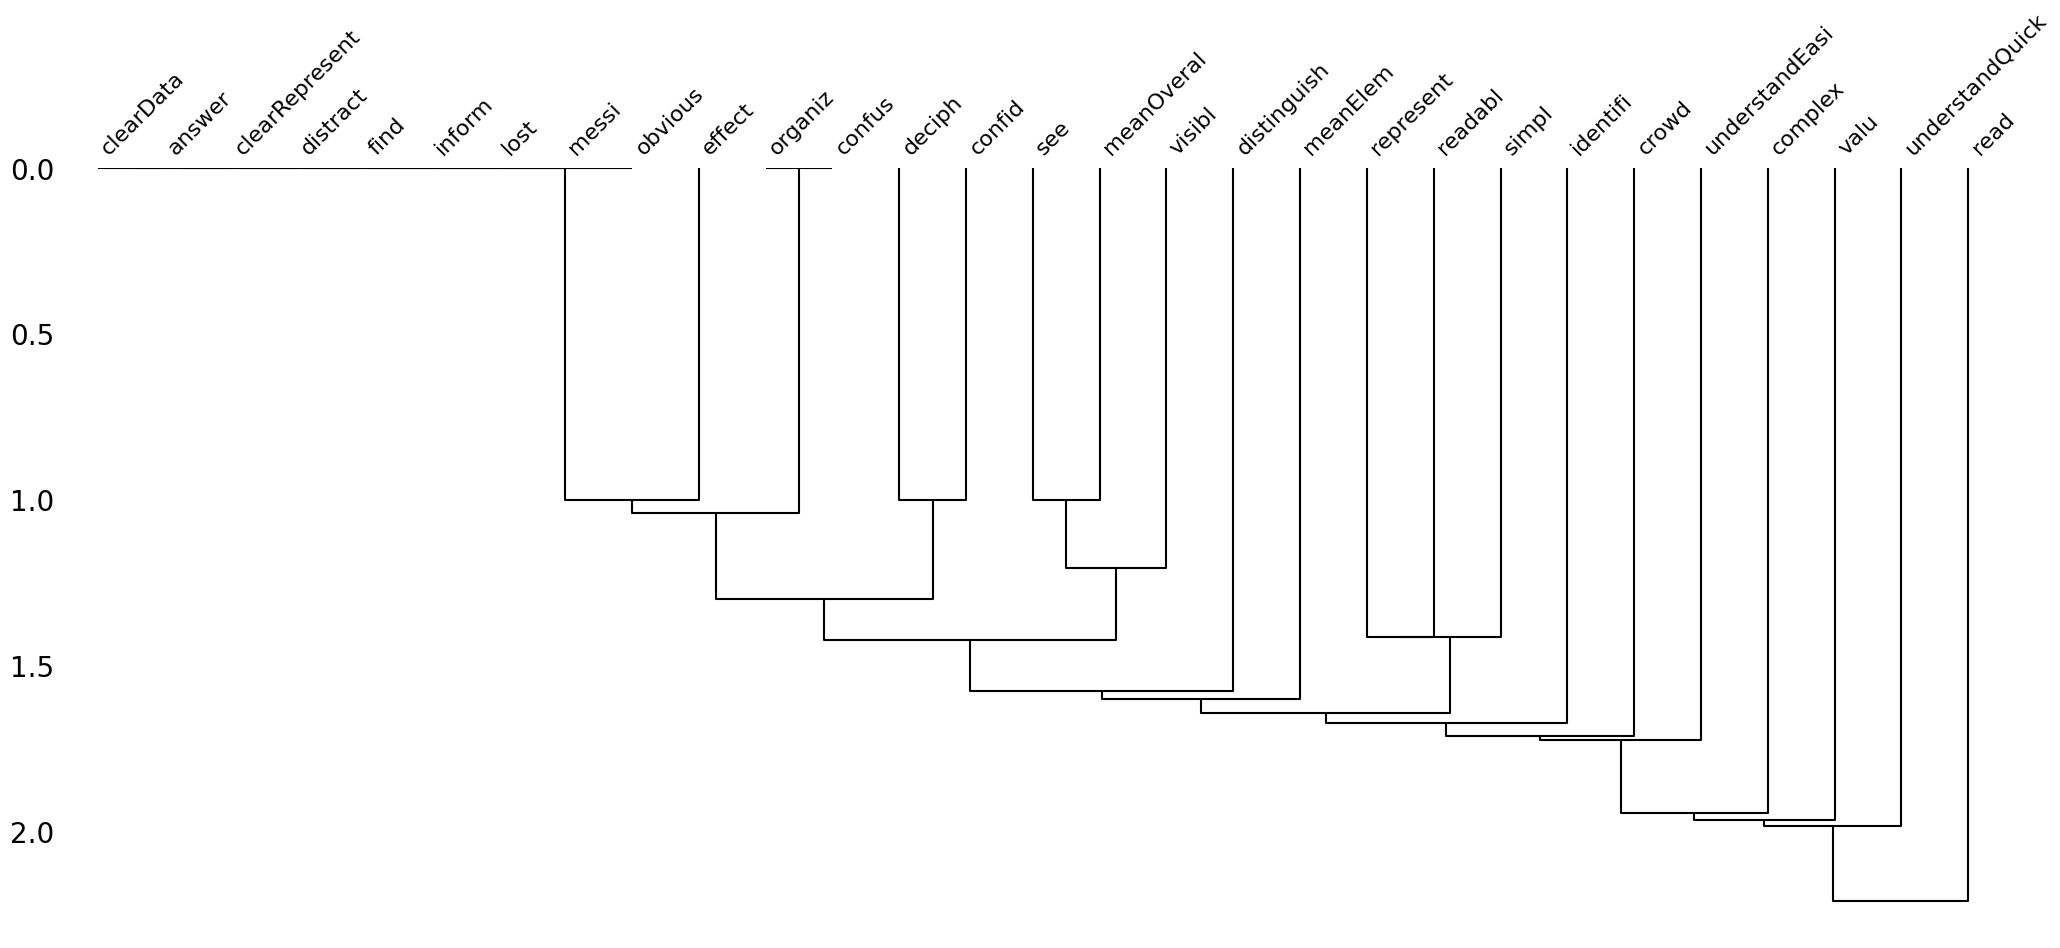

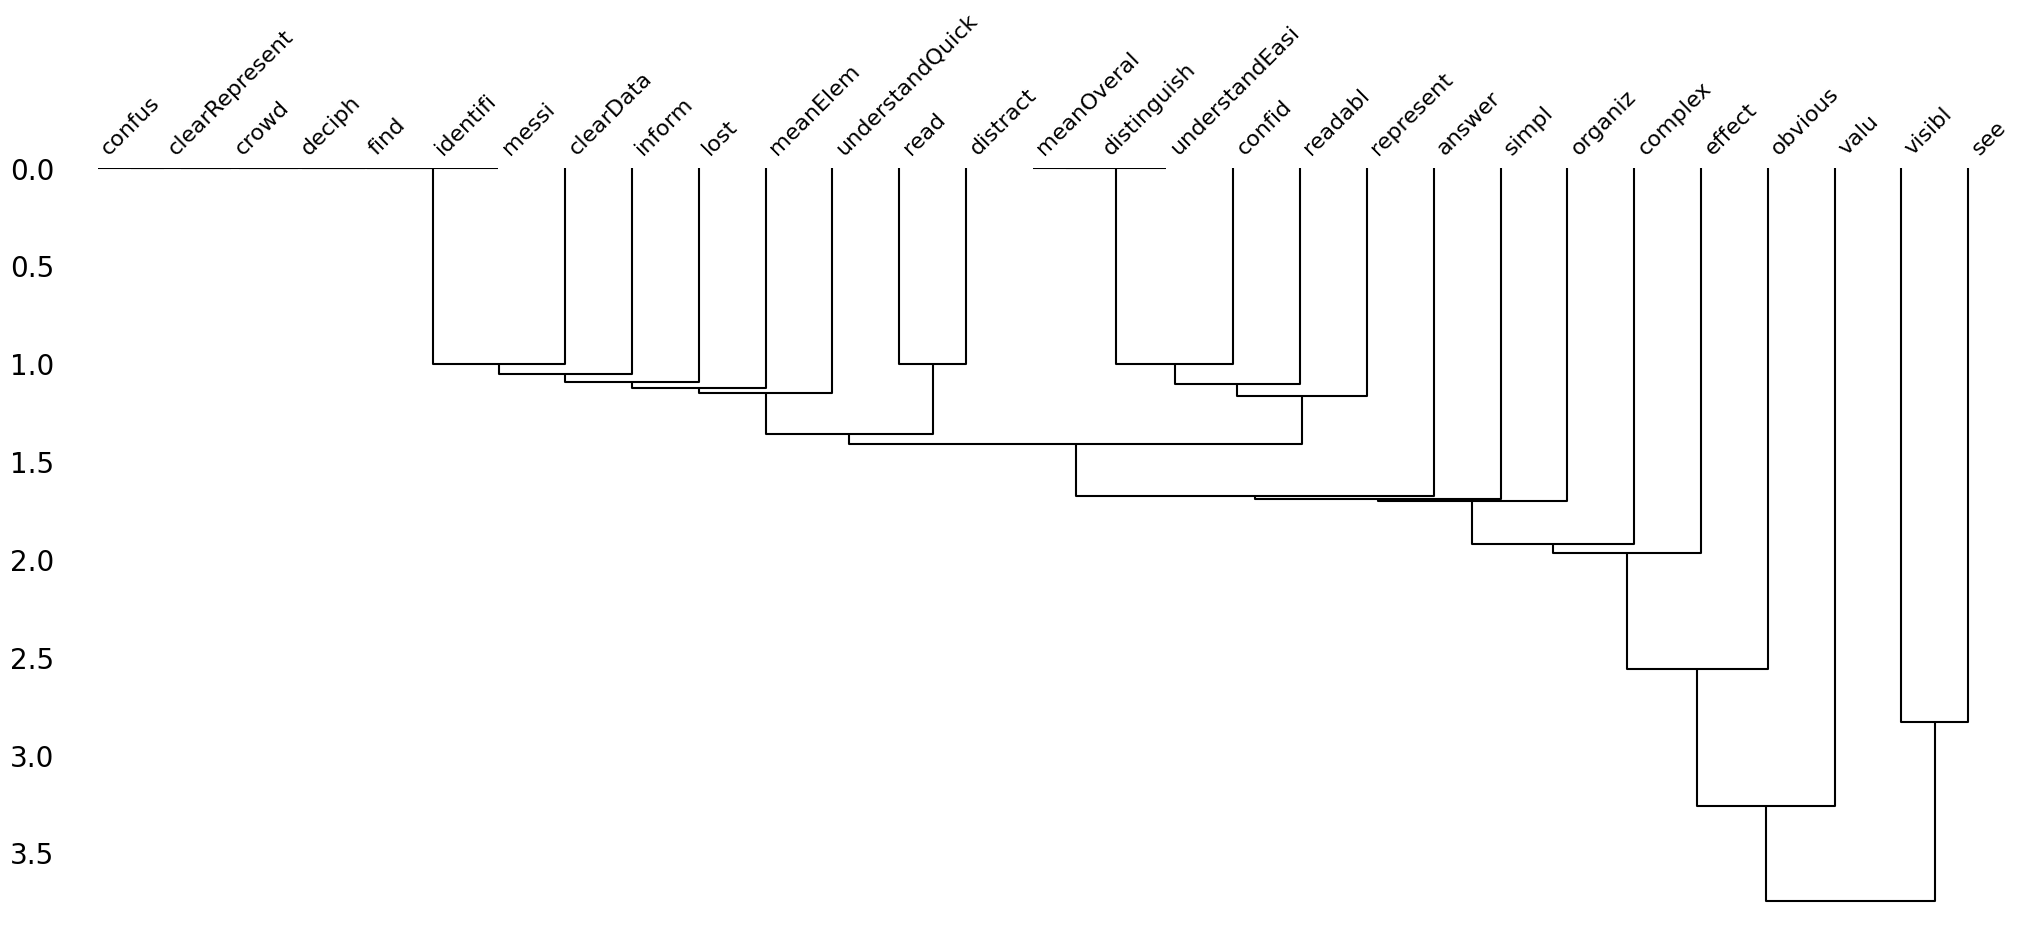

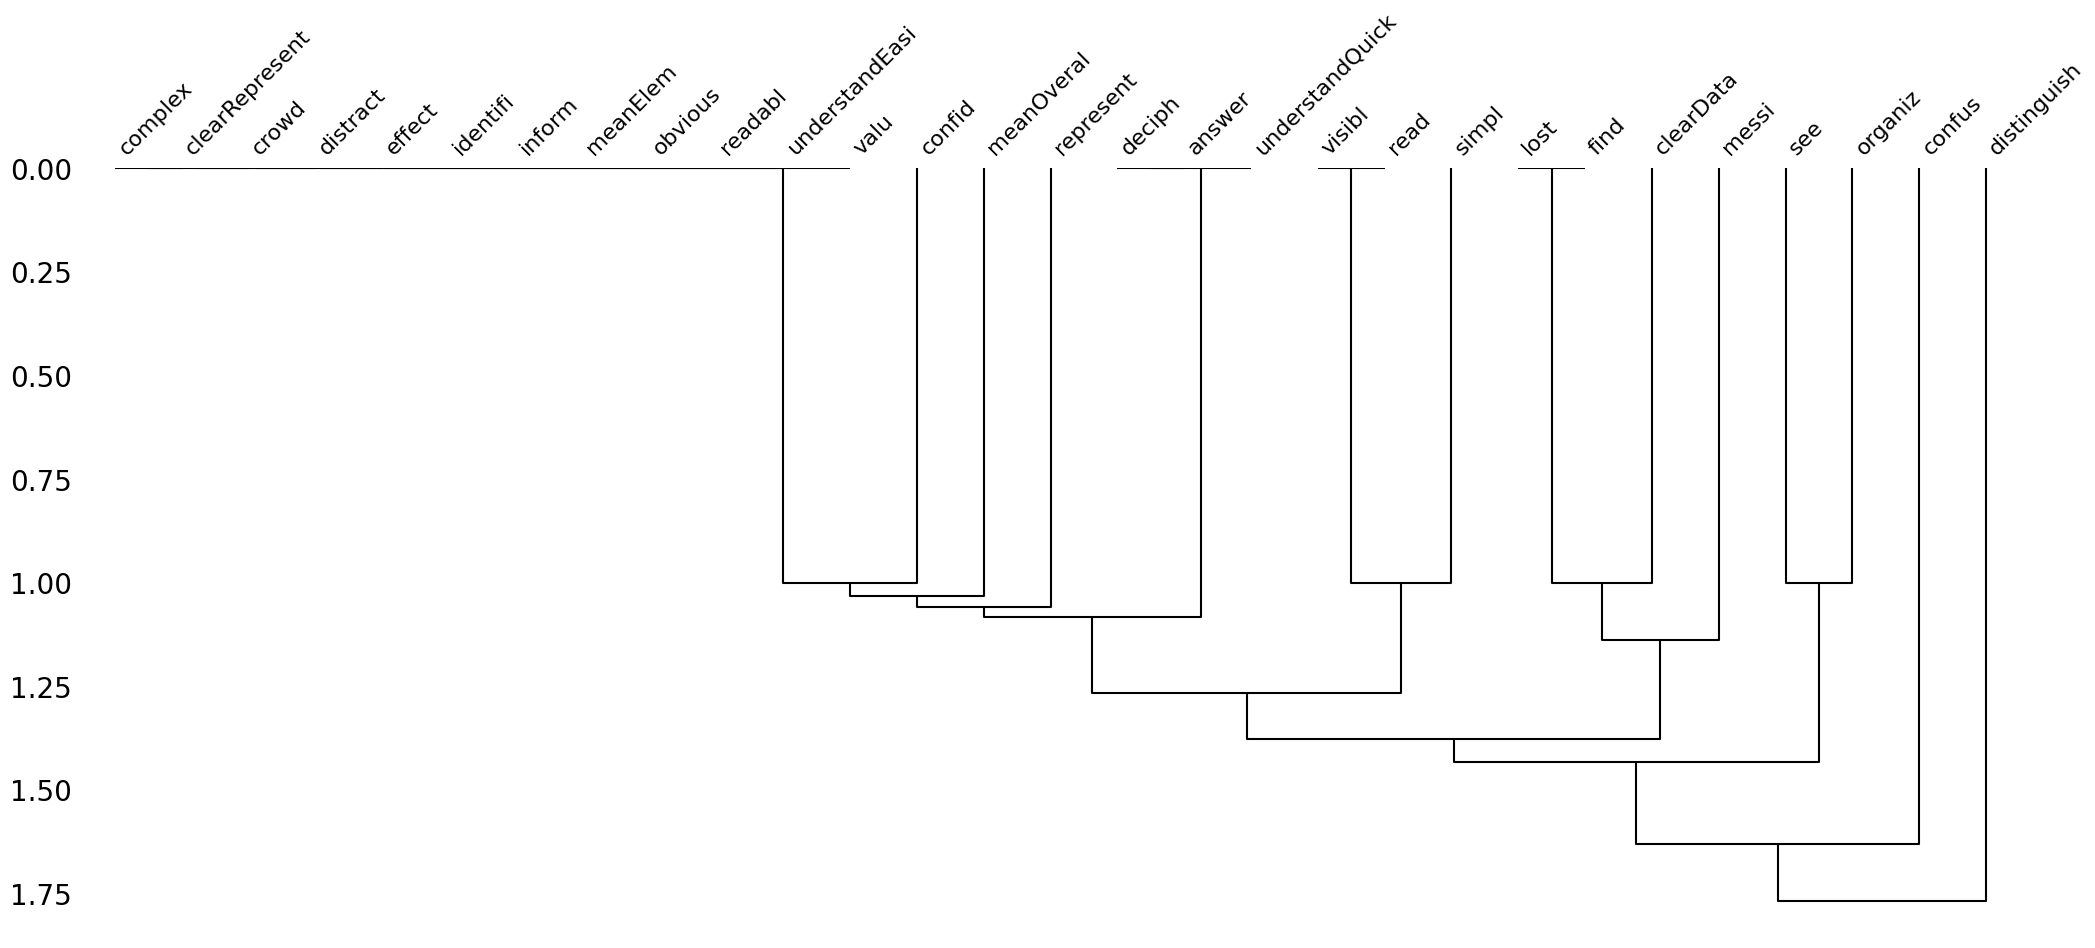

In [72]:
for stimuli in stimuli_dfs.keys():
    msno.dendrogram(stimuli_dfs[stimuli]['ratings'])

## Missing by stimuli

In [73]:
def show_missing(my_df):
    all_plots = {}
    bar = msno.bar(my_df)
    all_plots.update({'bar' : [bar.get_figure()]})
    matrix = msno.matrix(my_df)
    all_plots.update({'matrix' : matrix.get_figure()})
    heatmap = msno.heatmap(my_df)
    all_plots.update({'heatmap' : heatmap.get_figure()})
    dendro = msno.dendrogram(my_df)
    all_plots.update({'dendrogram' : dendro.get_figure()})
    return all_plots

### Missing in A

<class 'list'>
<class 'matplotlib.figure.Figure'>
<class 'matplotlib.figure.Figure'>
<class 'matplotlib.figure.Figure'>


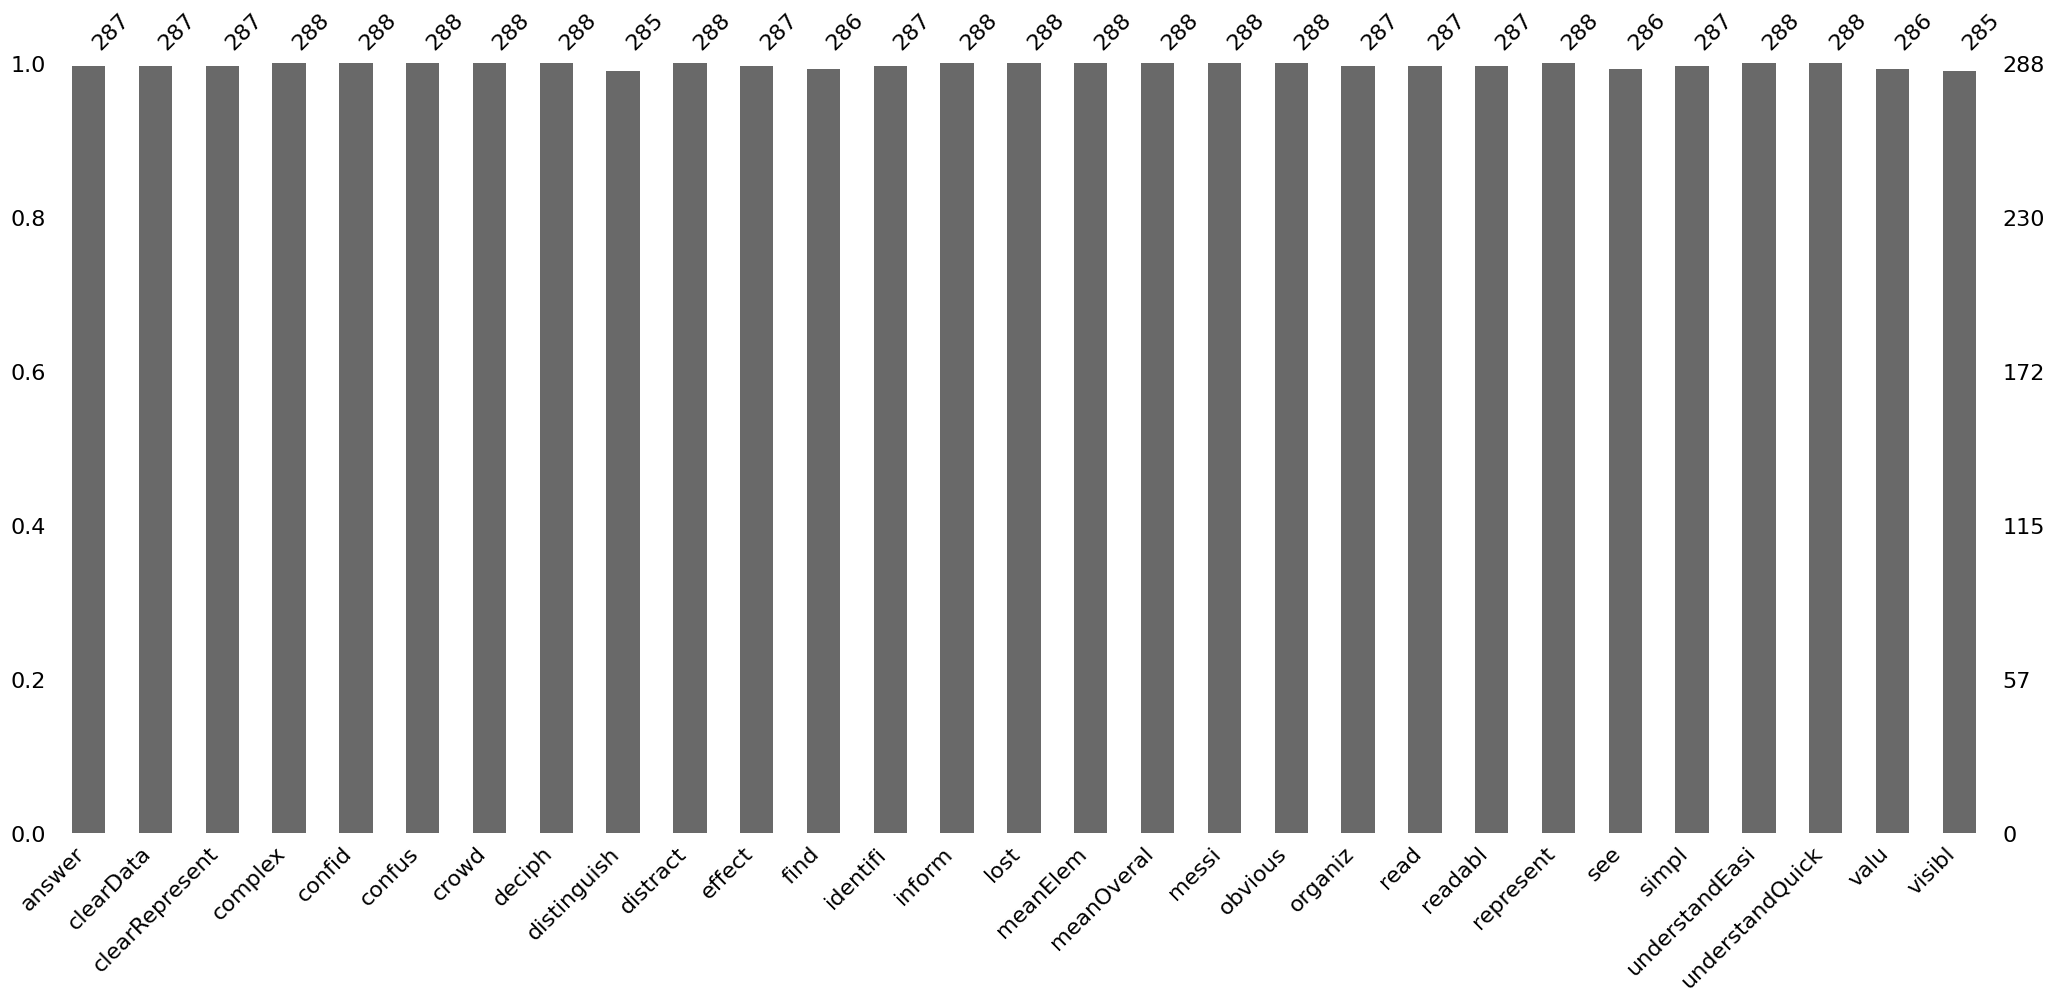

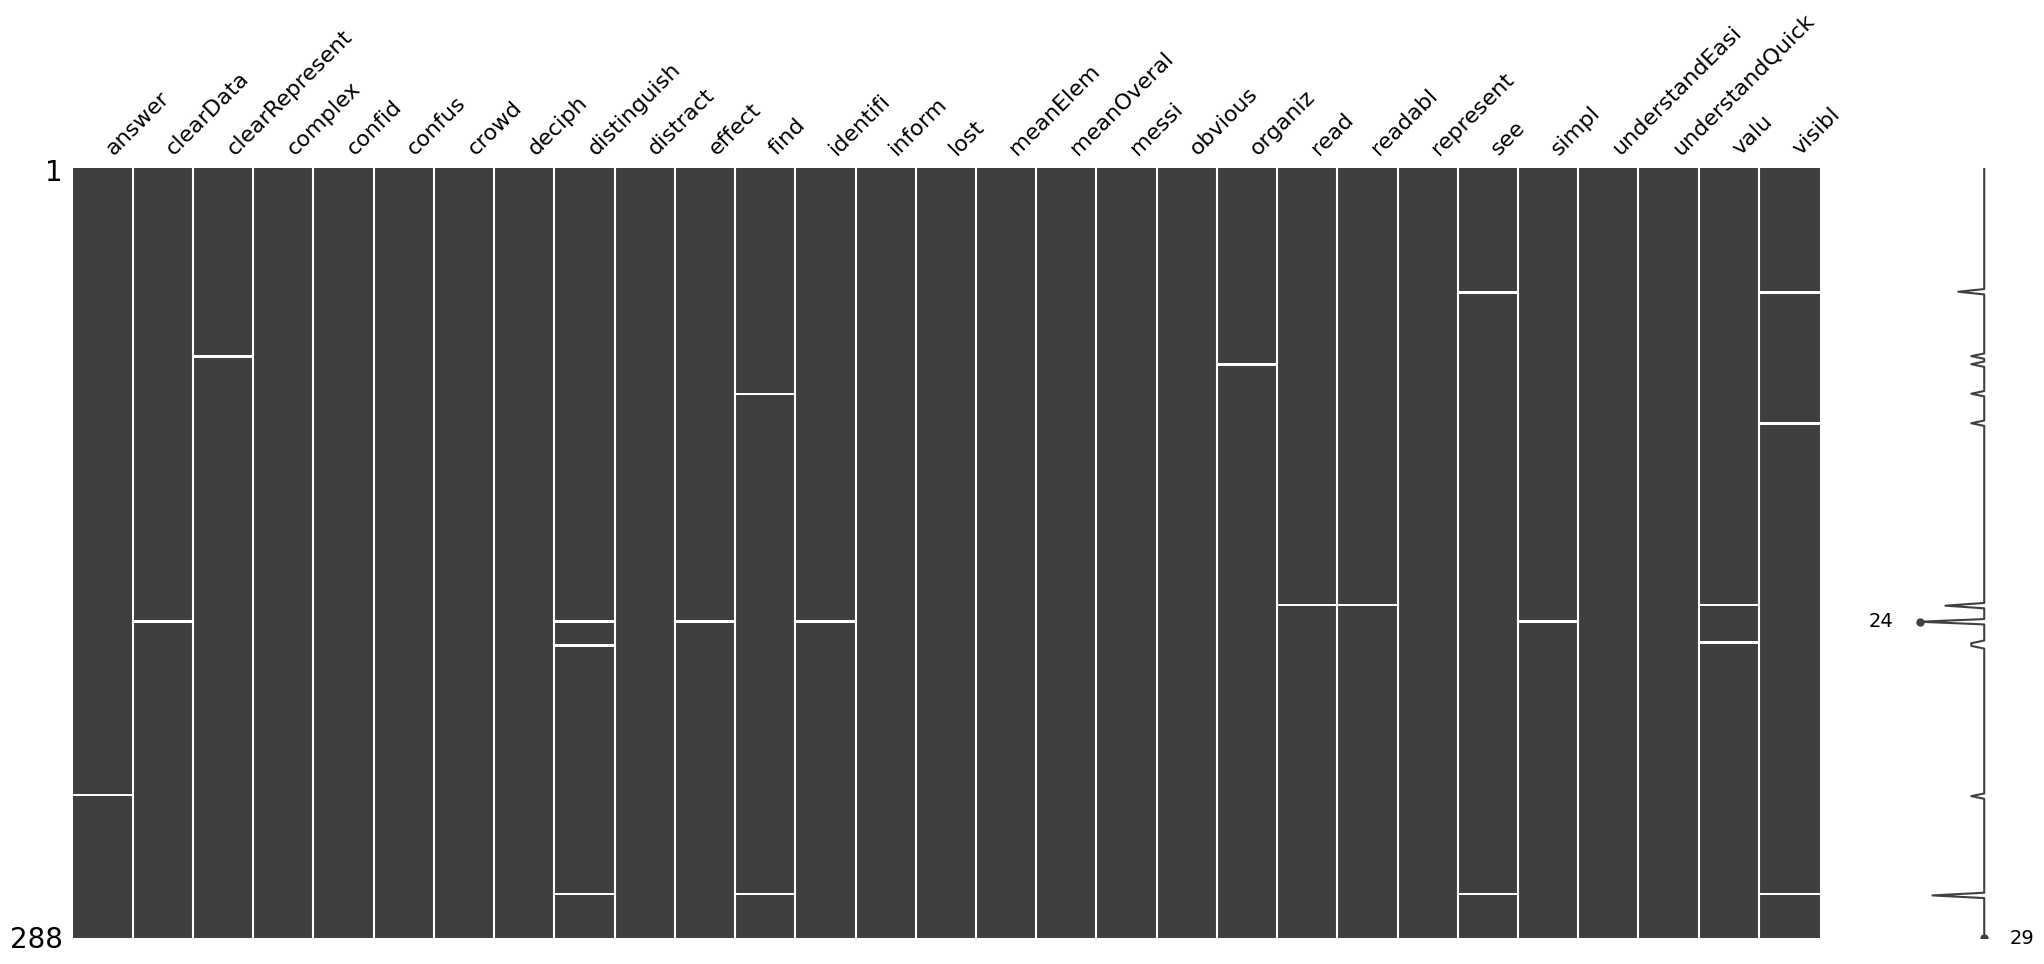

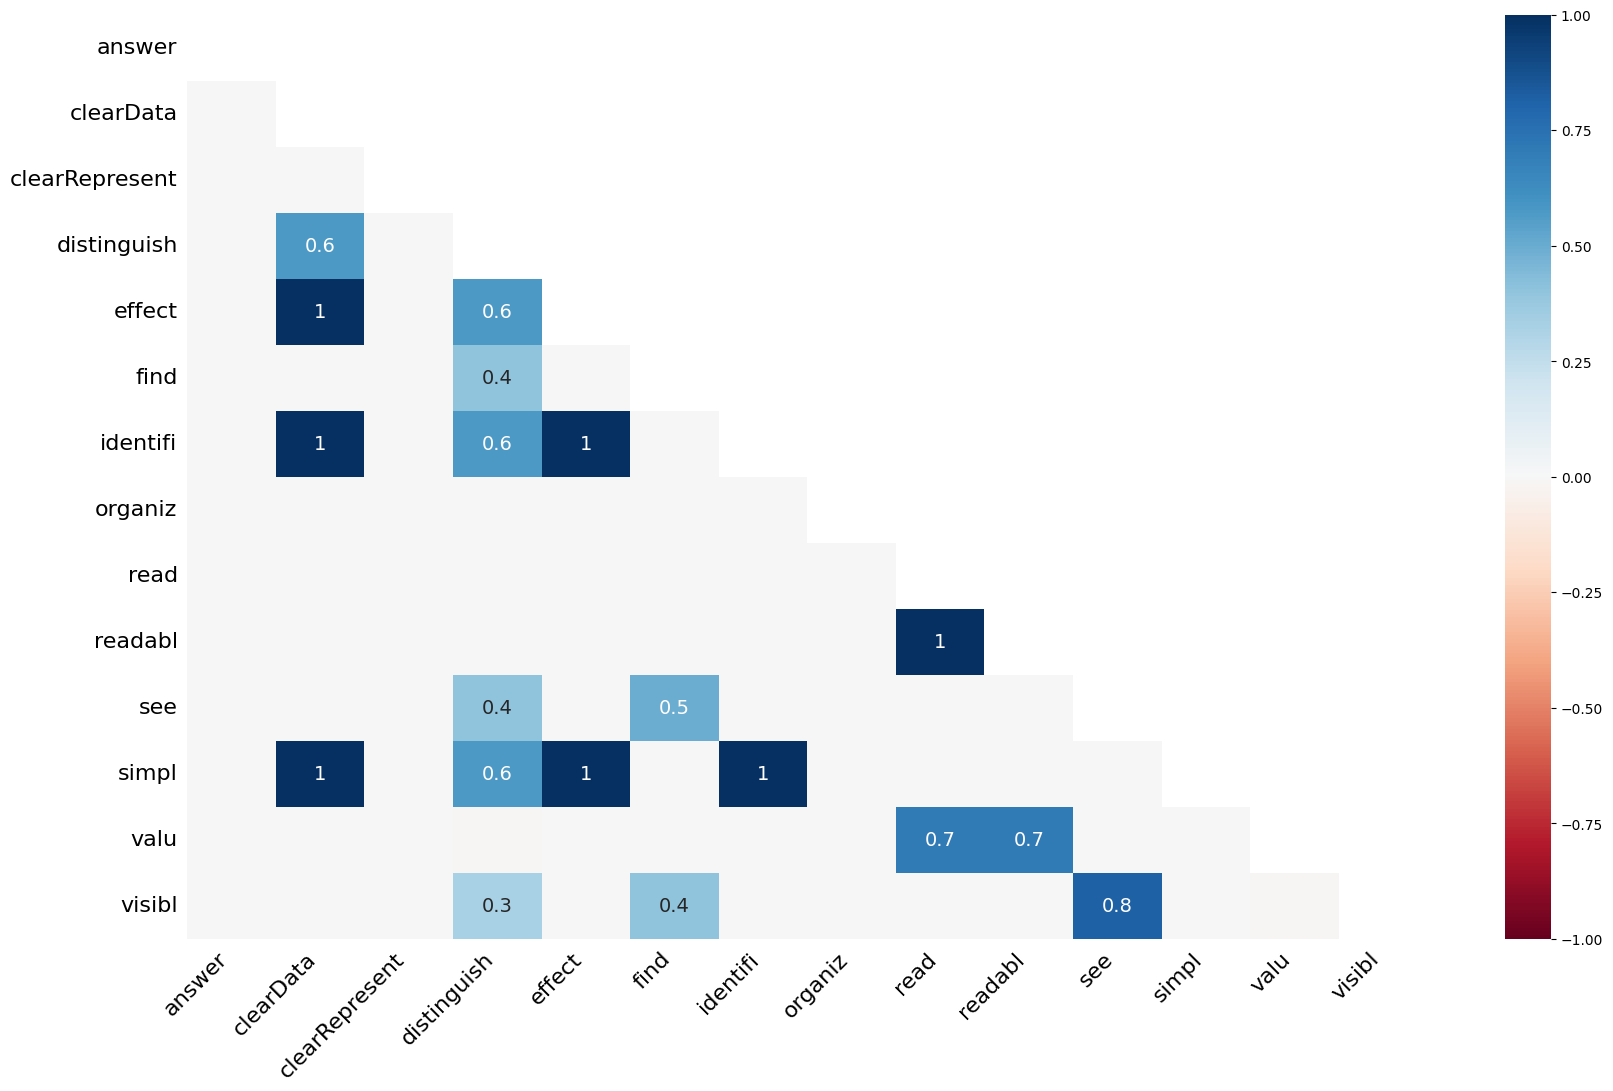

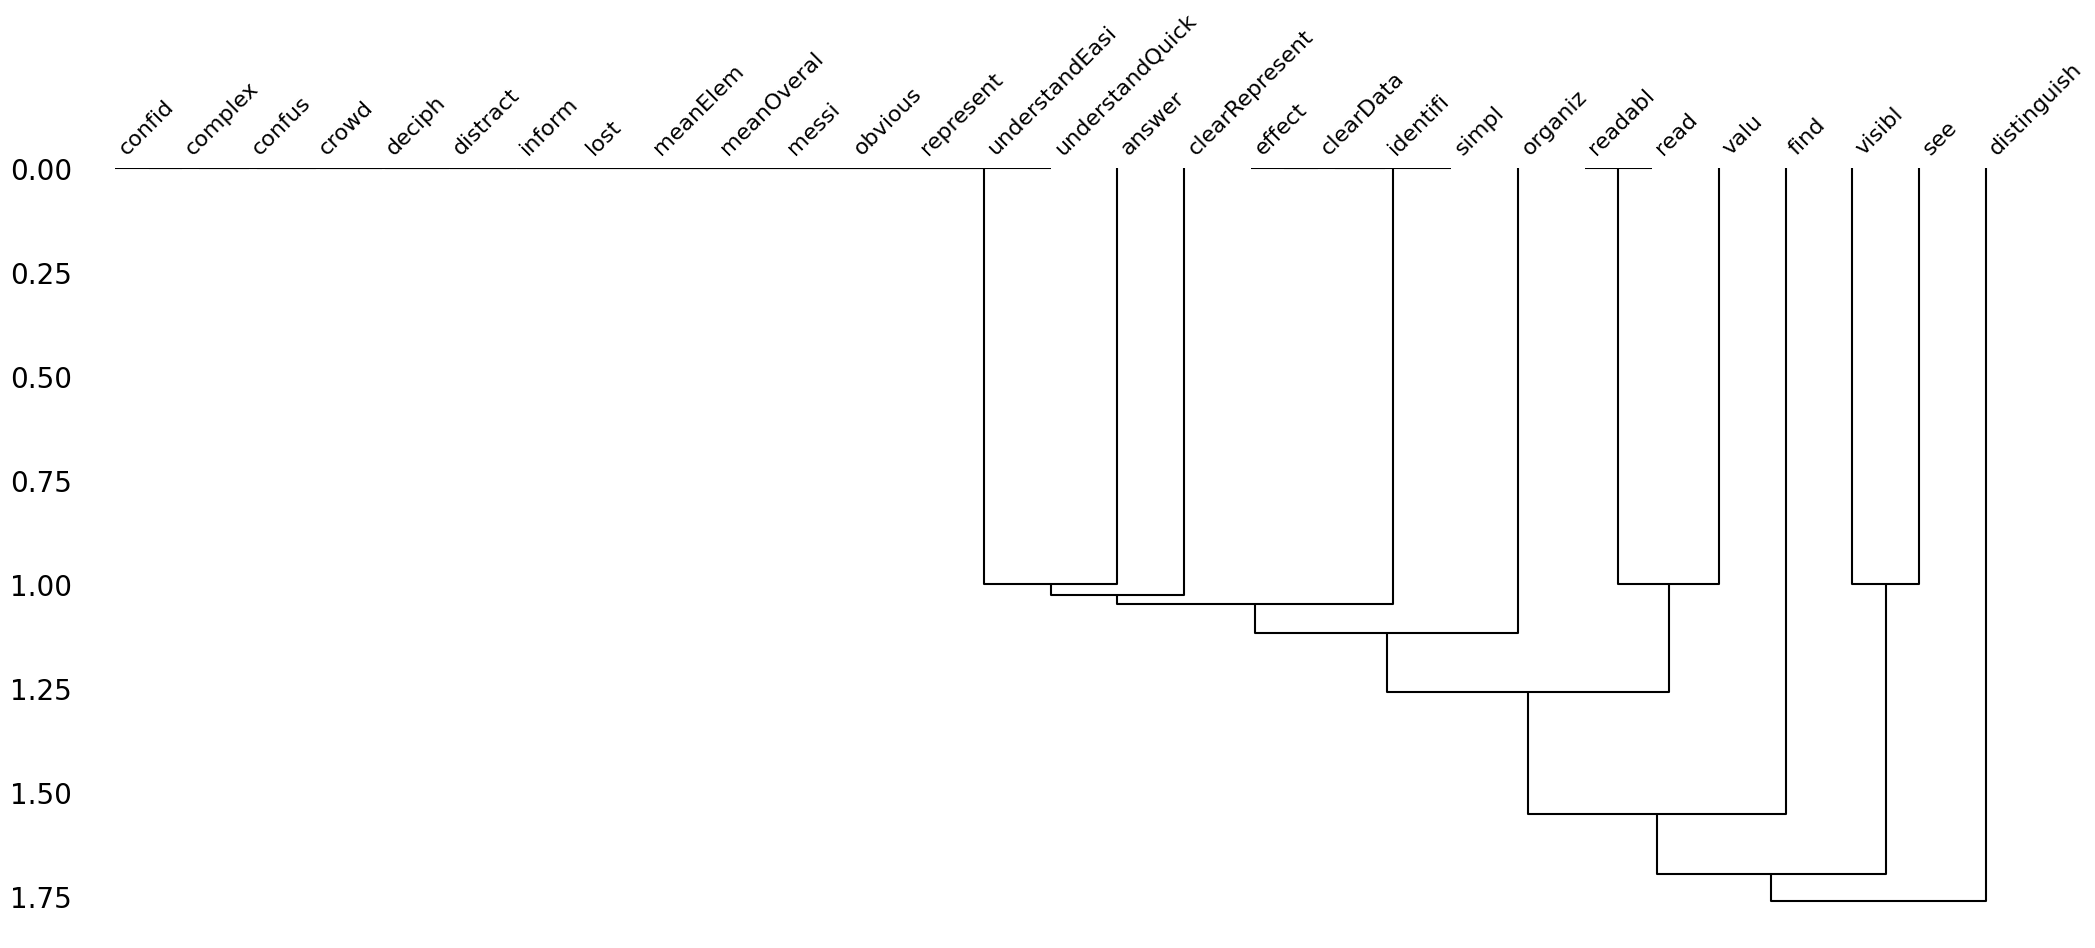

In [74]:
fig_missing_data = show_missing(stimuli_dfs['A']['ratings'])
for fig, plot in fig_missing_data.items():
    print(type(plot))
    # plot.savefig(f'{outdir}/generatedPlots/missing-{fig}-A.png')

### Missing in B

{'bar': [<Figure size 2500x1000 with 3 Axes>],
 'matrix': <Figure size 2500x1000 with 2 Axes>,
 'heatmap': <Figure size 2000x1200 with 2 Axes>,
 'dendrogram': <Figure size 2500x1000 with 1 Axes>}

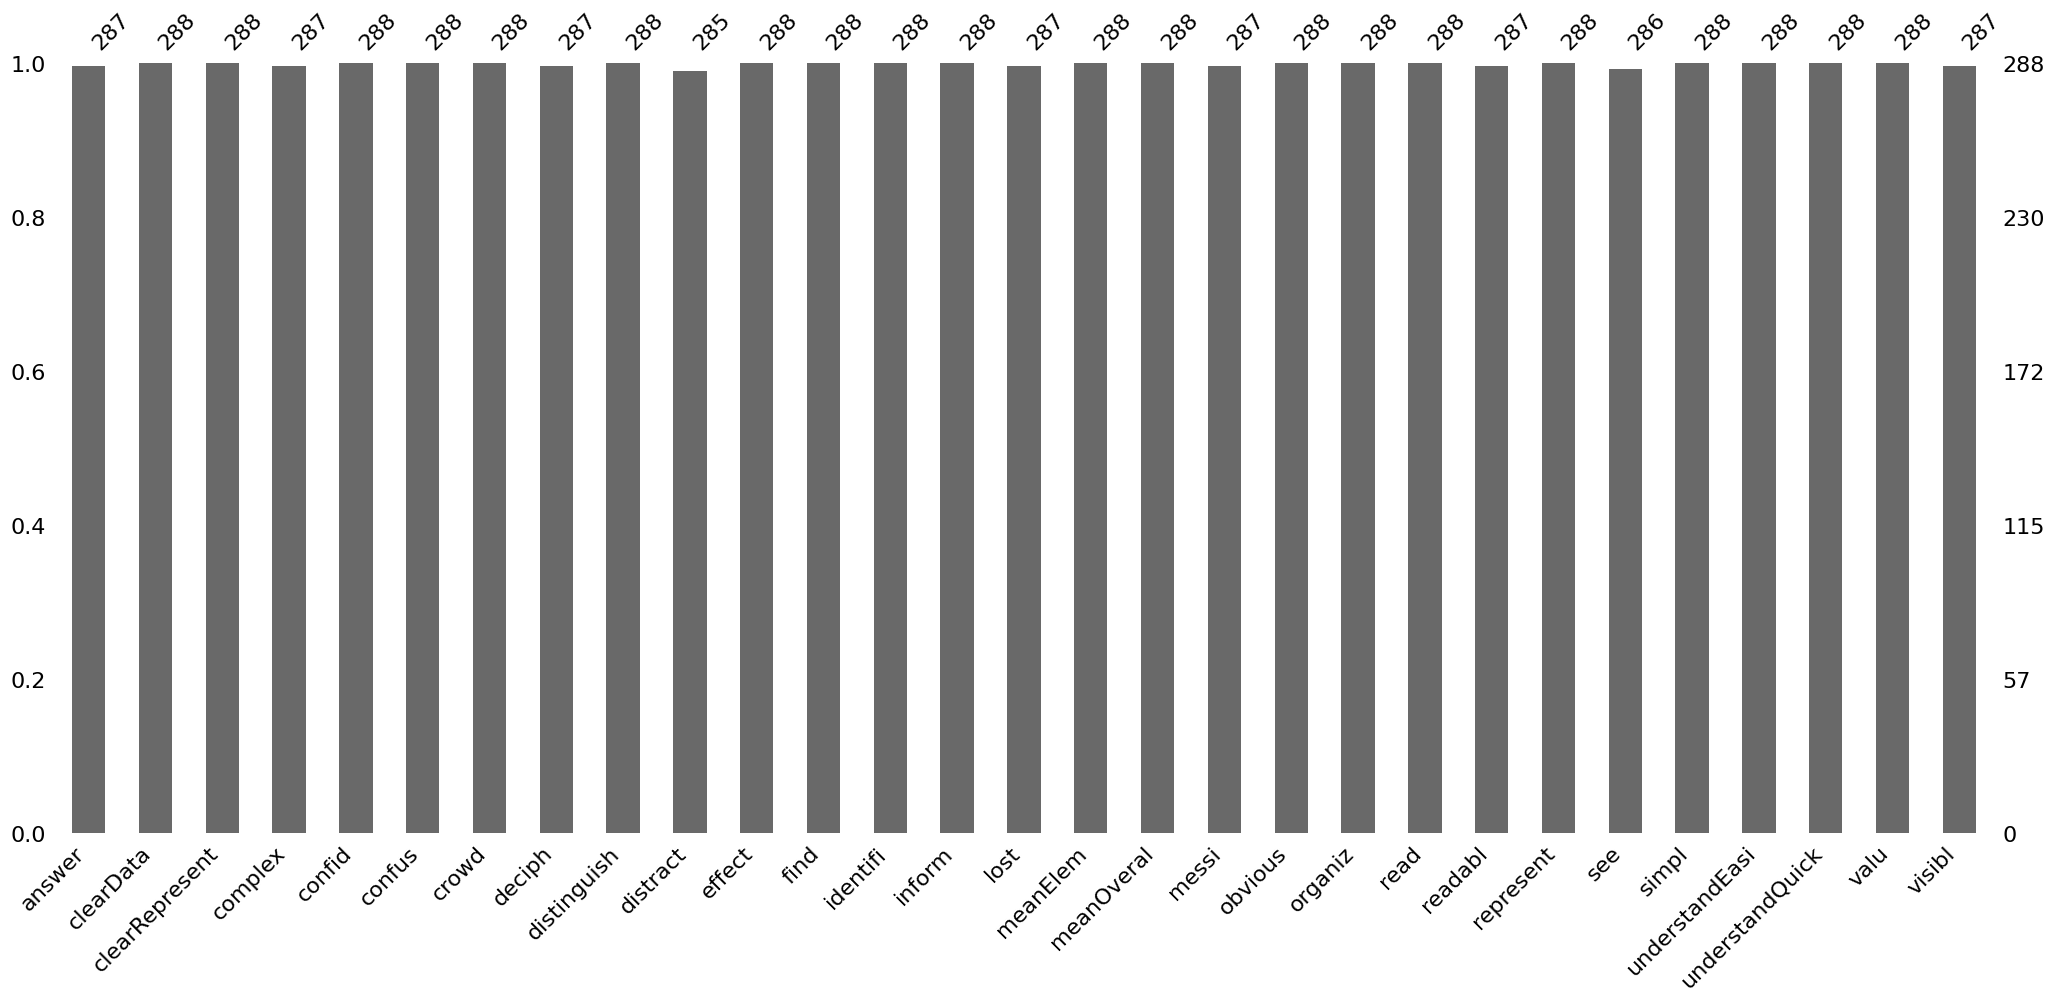

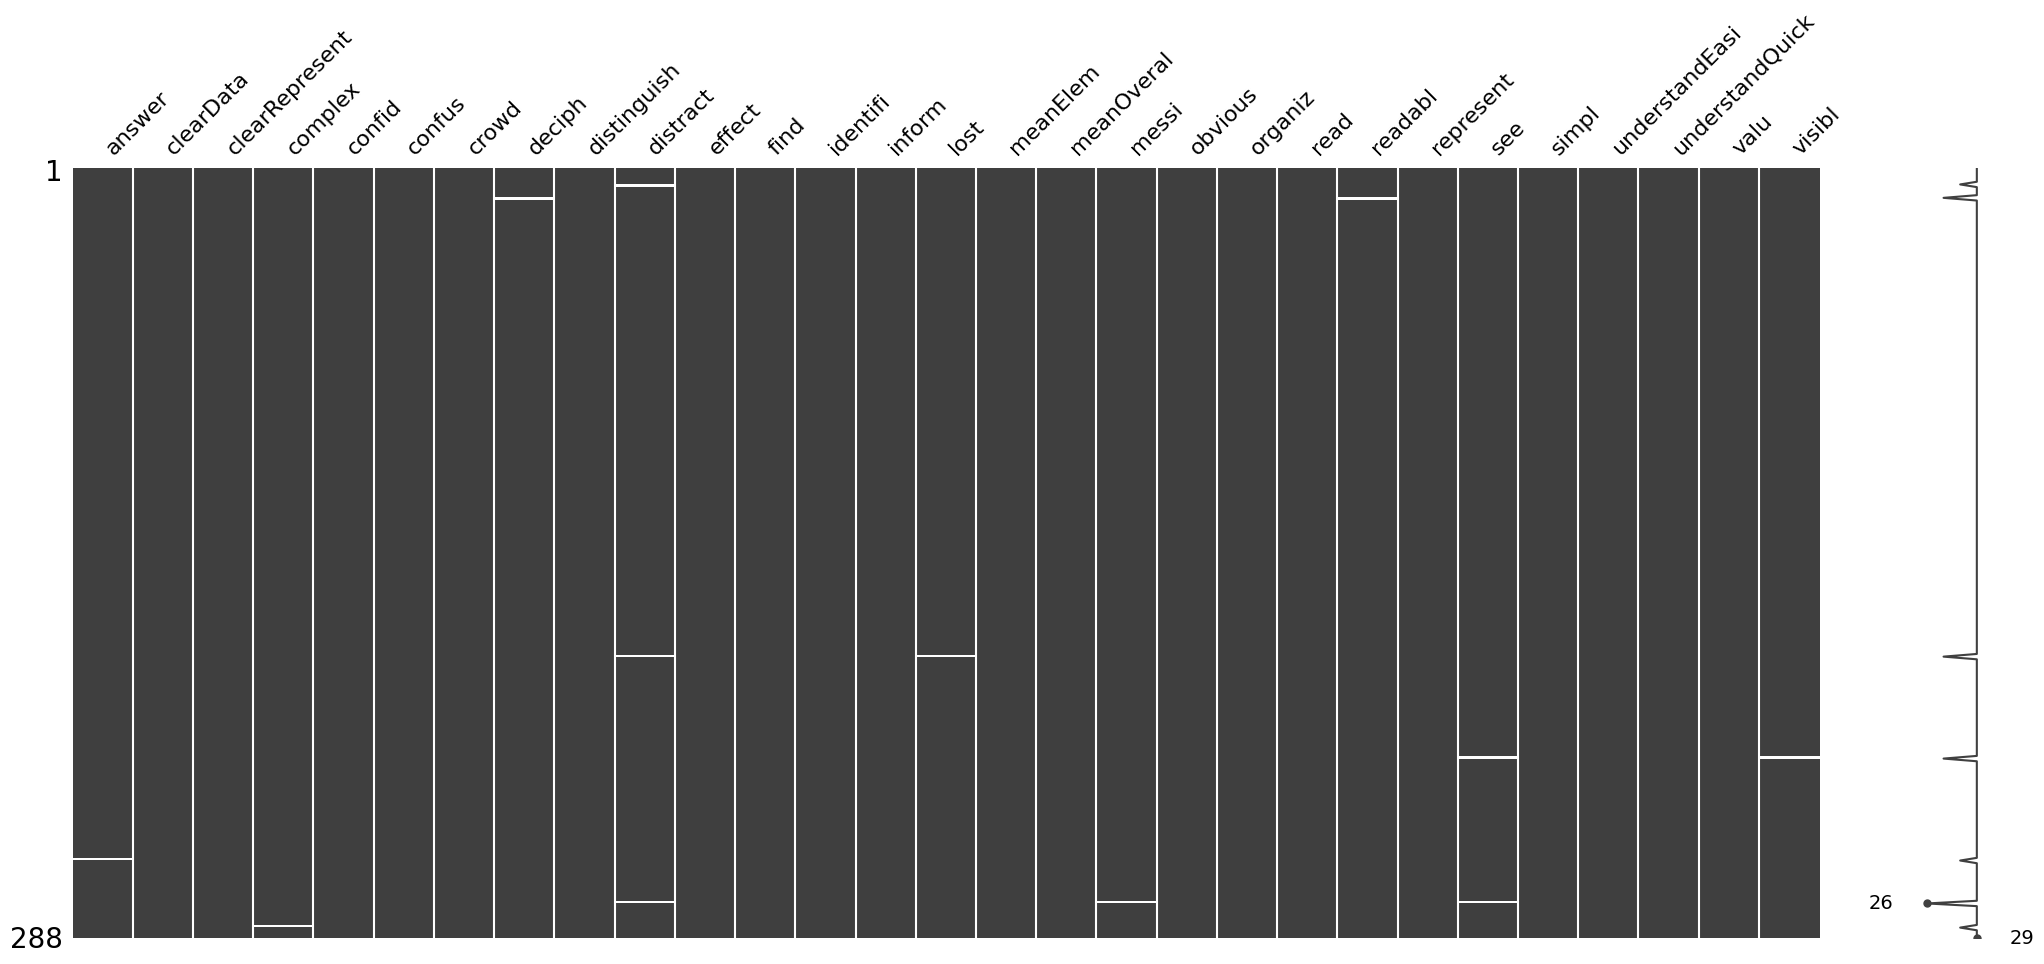

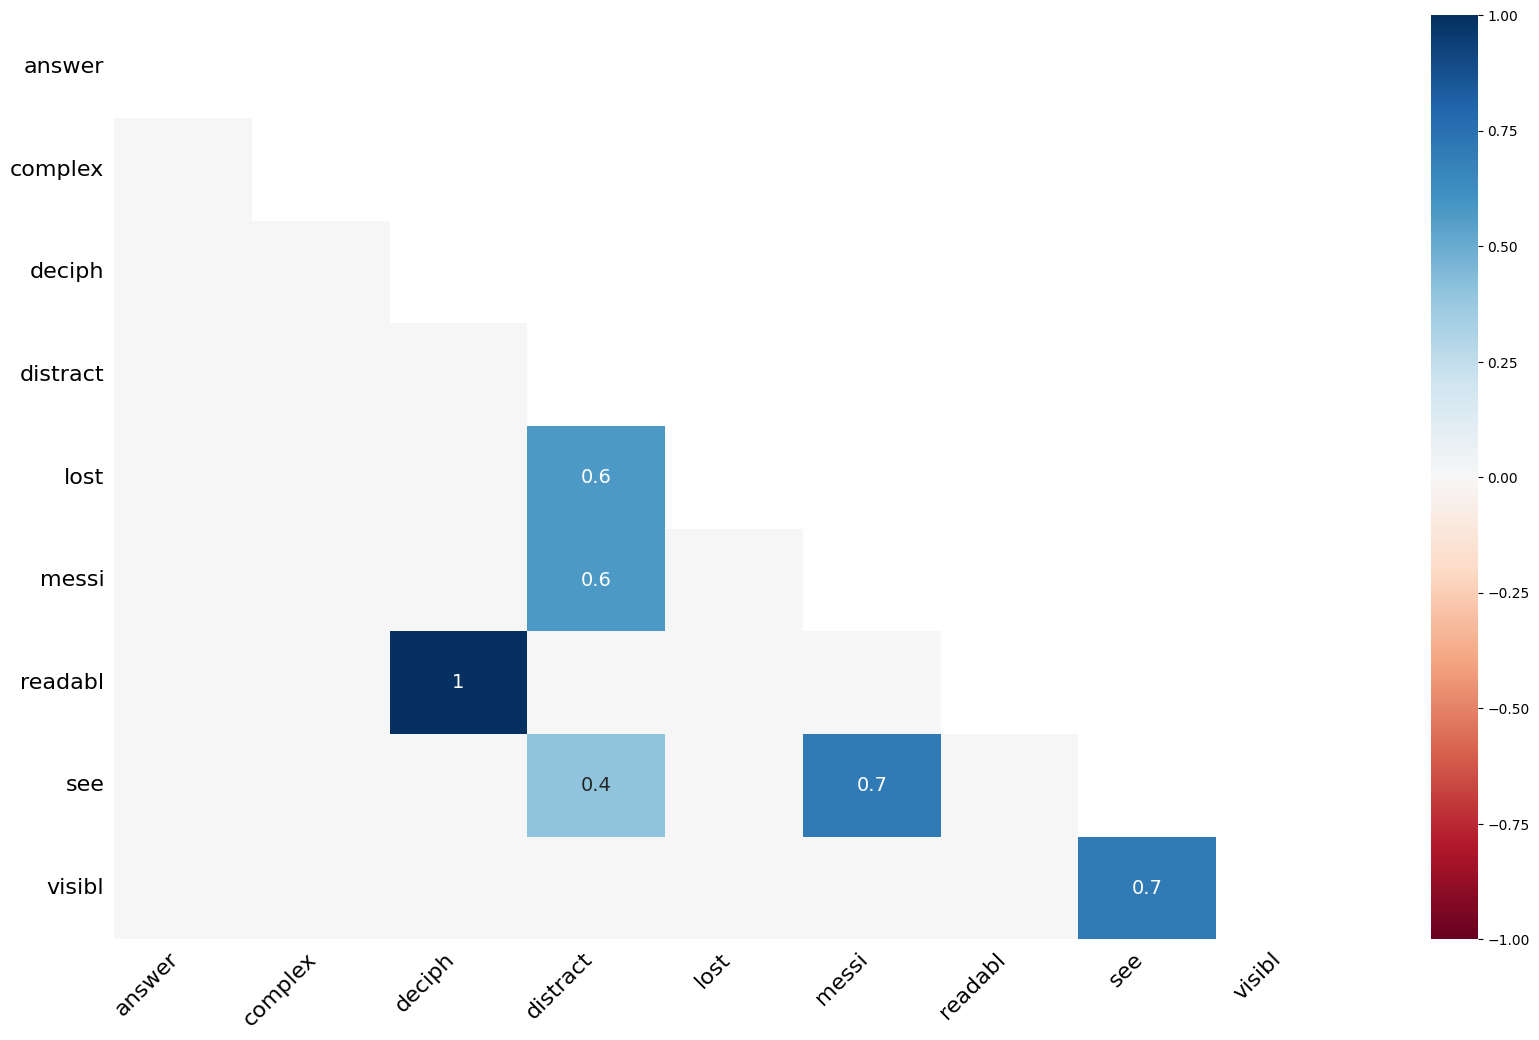

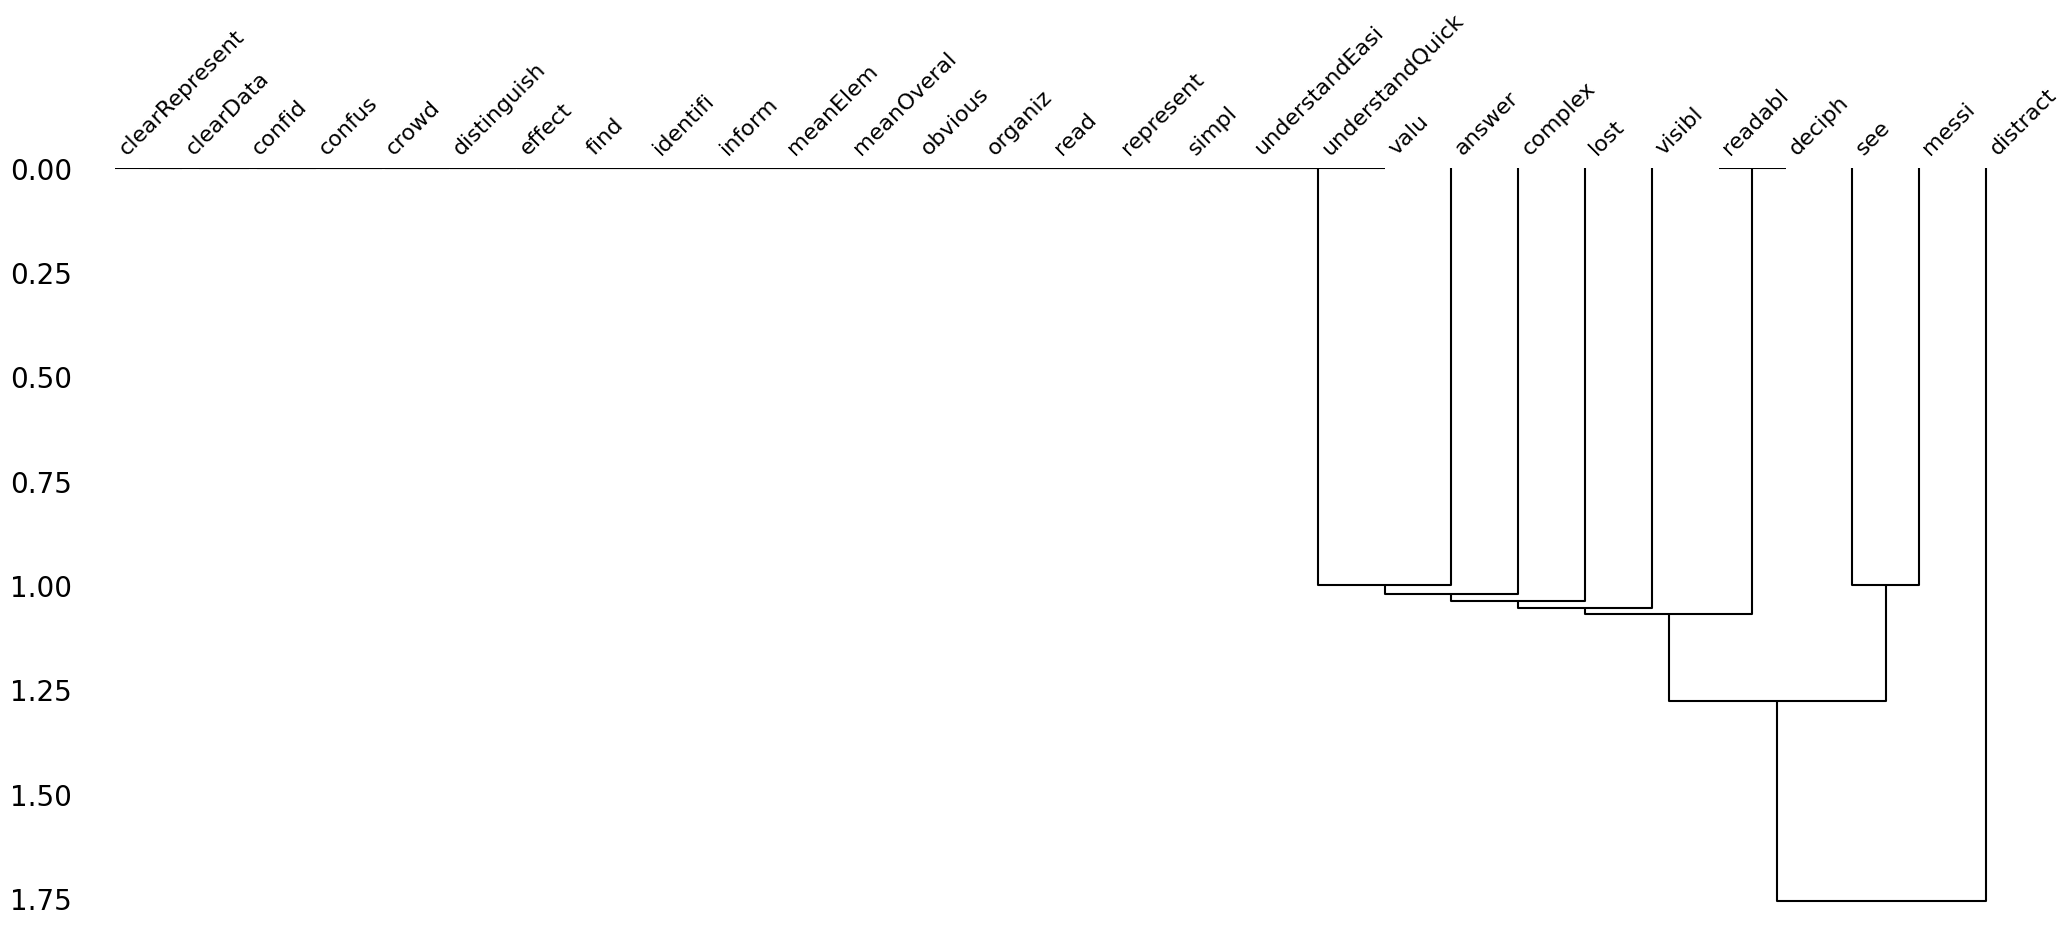

In [75]:
show_missing(stimuli_dfs['B']['ratings'])

### Missing in C

{'bar': [<Figure size 2500x1000 with 3 Axes>],
 'matrix': <Figure size 2500x1000 with 2 Axes>,
 'heatmap': <Figure size 2000x1200 with 2 Axes>,
 'dendrogram': <Figure size 2500x1000 with 1 Axes>}

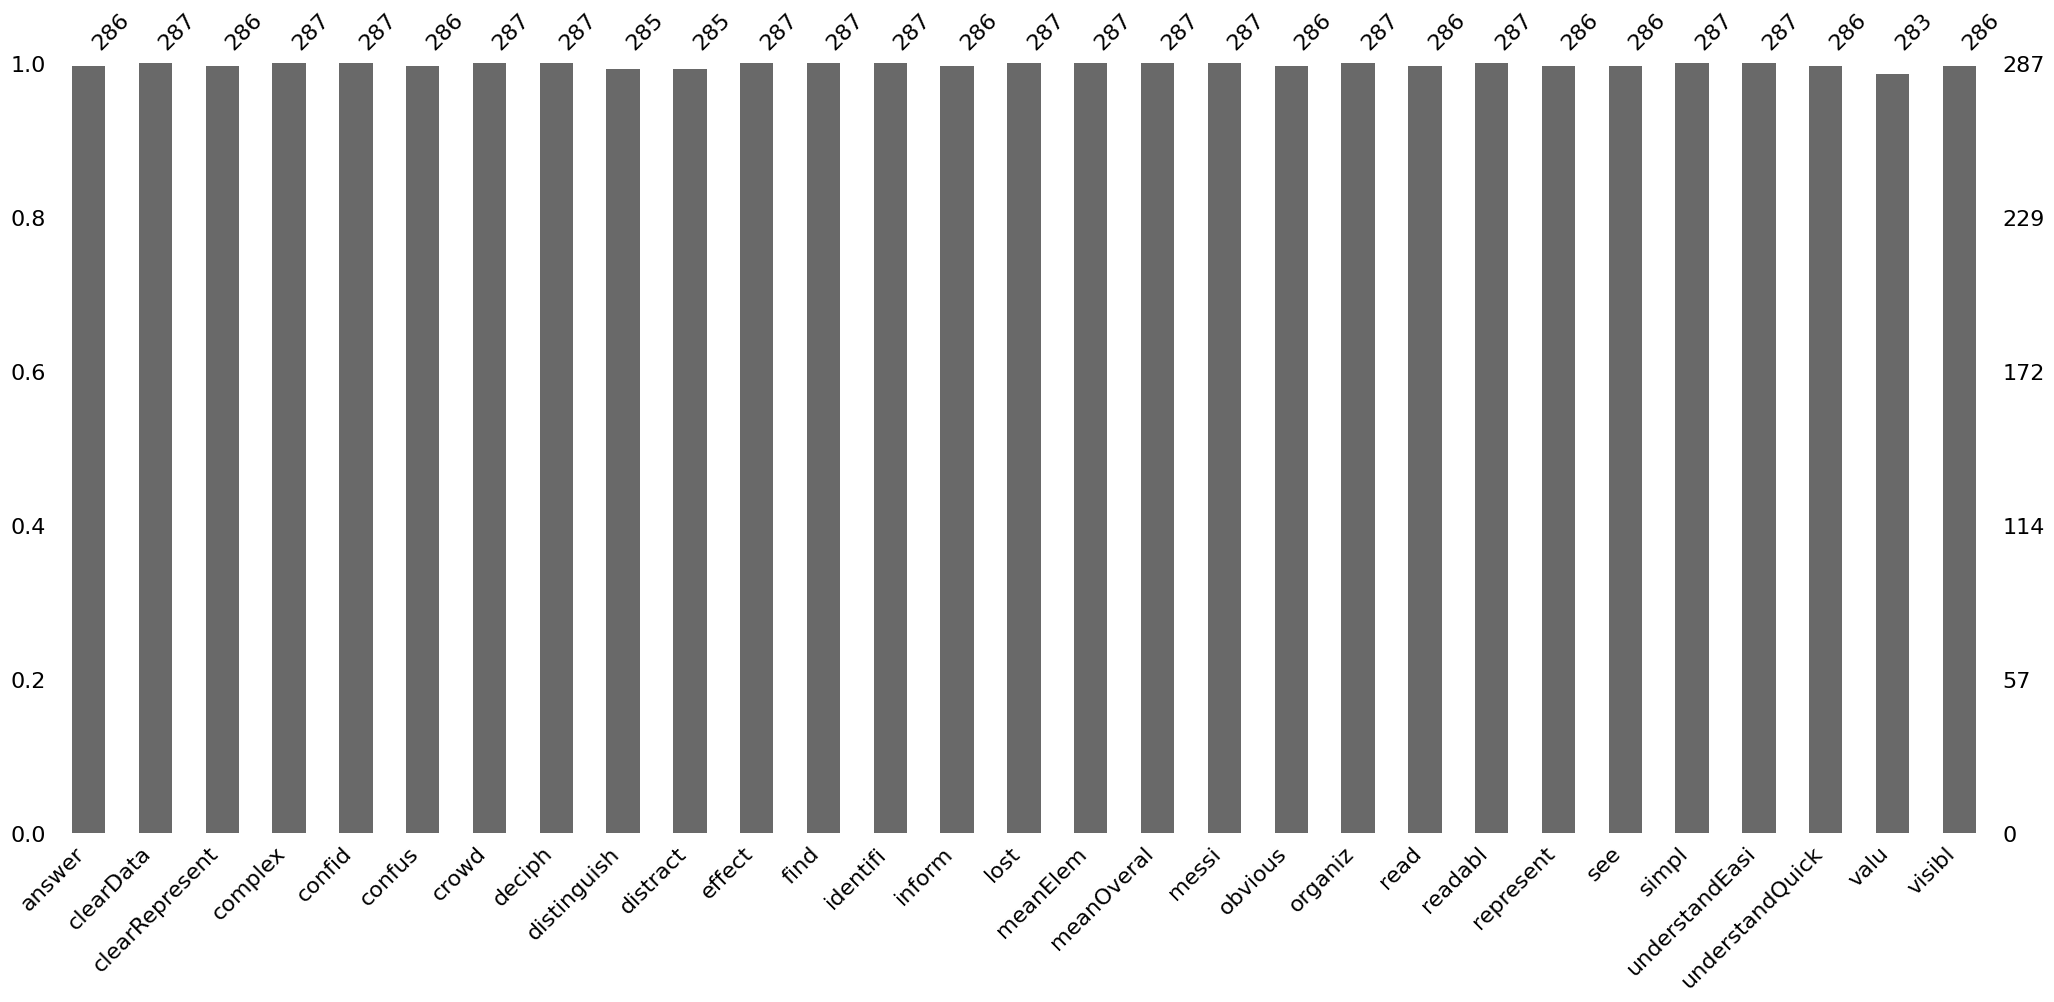

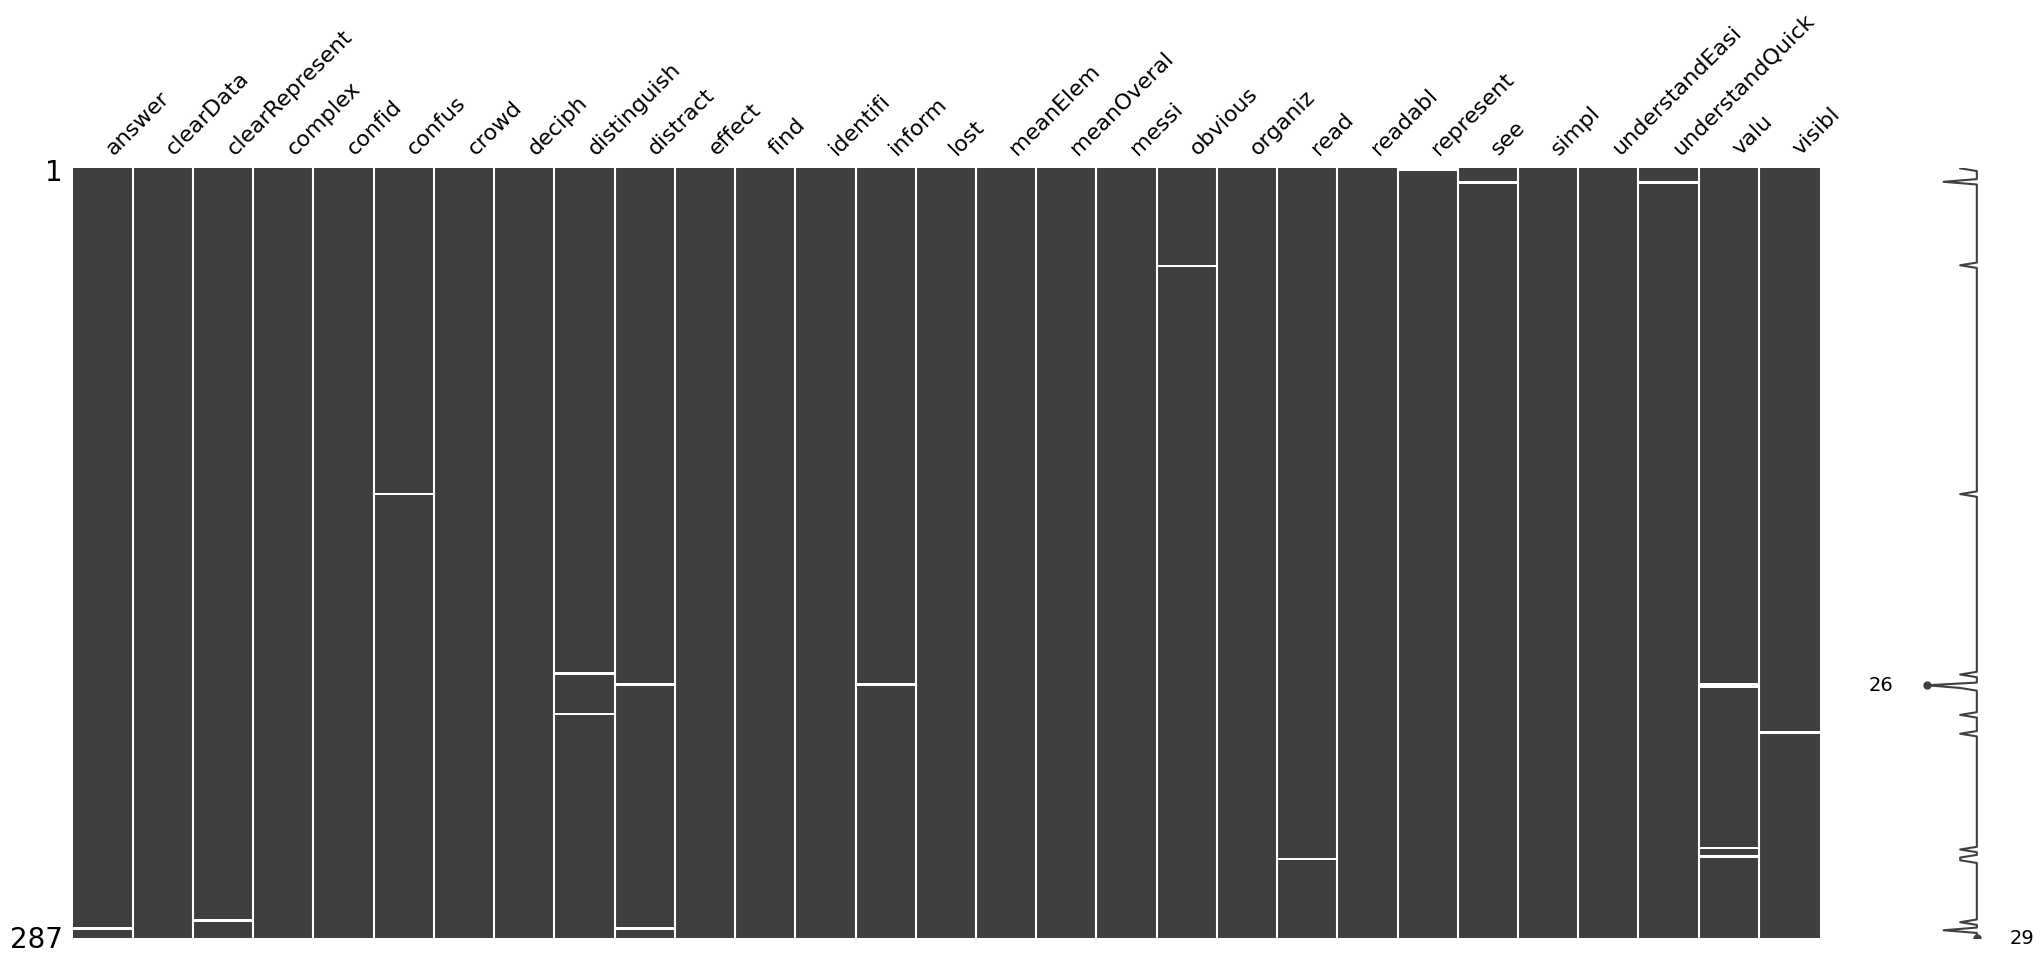

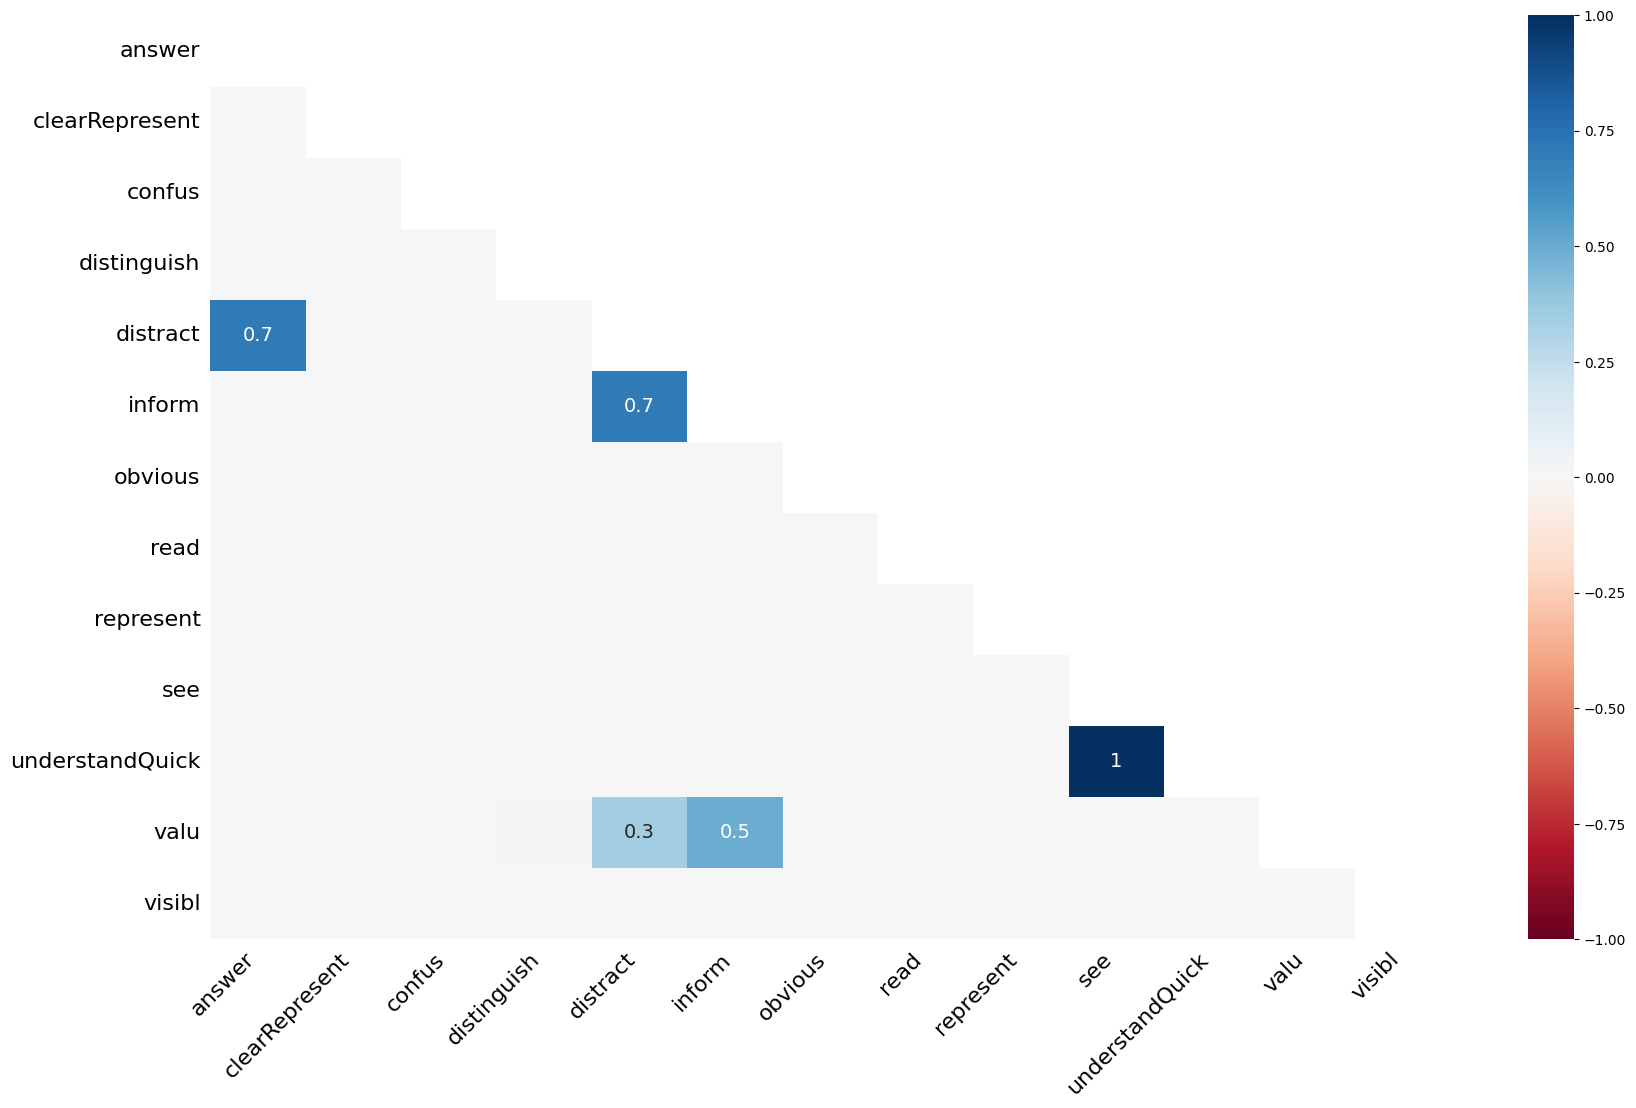

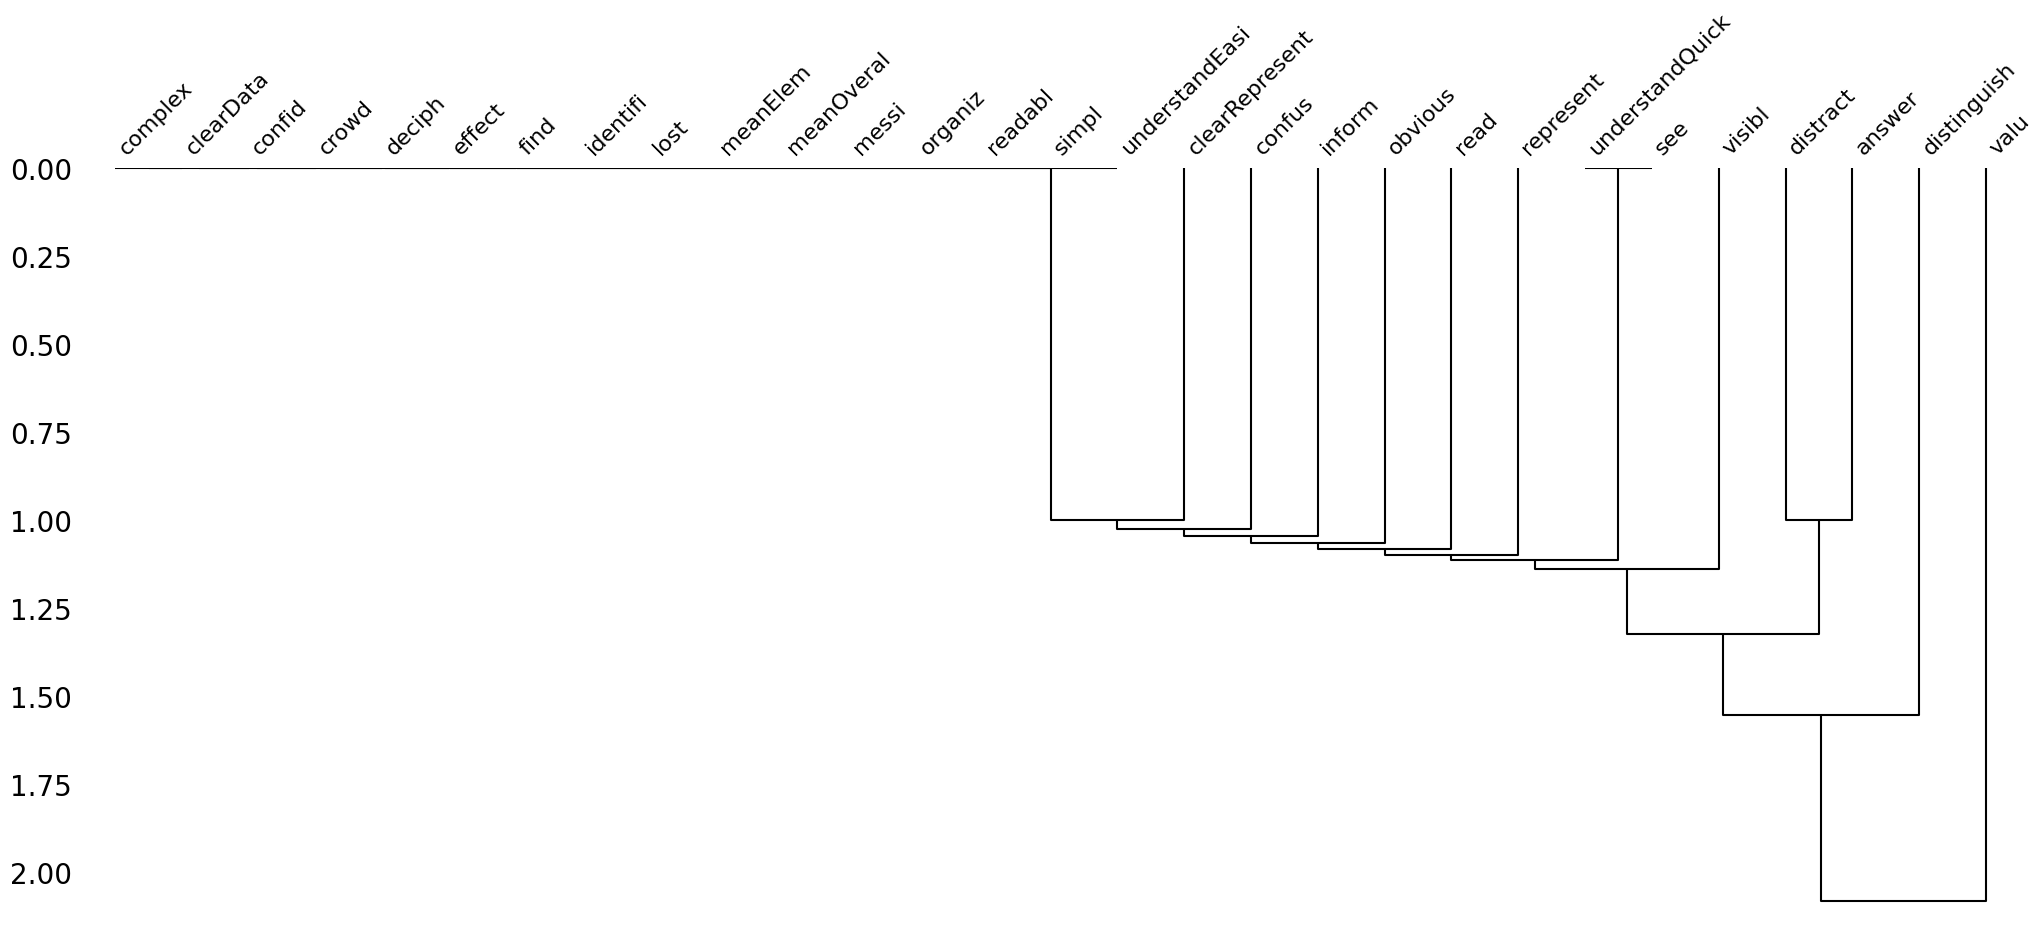

In [76]:
show_missing(stimuli_dfs['C']['ratings'])

### Missing in D

{'bar': [<Figure size 2500x1000 with 3 Axes>],
 'matrix': <Figure size 2500x1000 with 2 Axes>,
 'heatmap': <Figure size 2000x1200 with 2 Axes>,
 'dendrogram': <Figure size 2500x1000 with 1 Axes>}

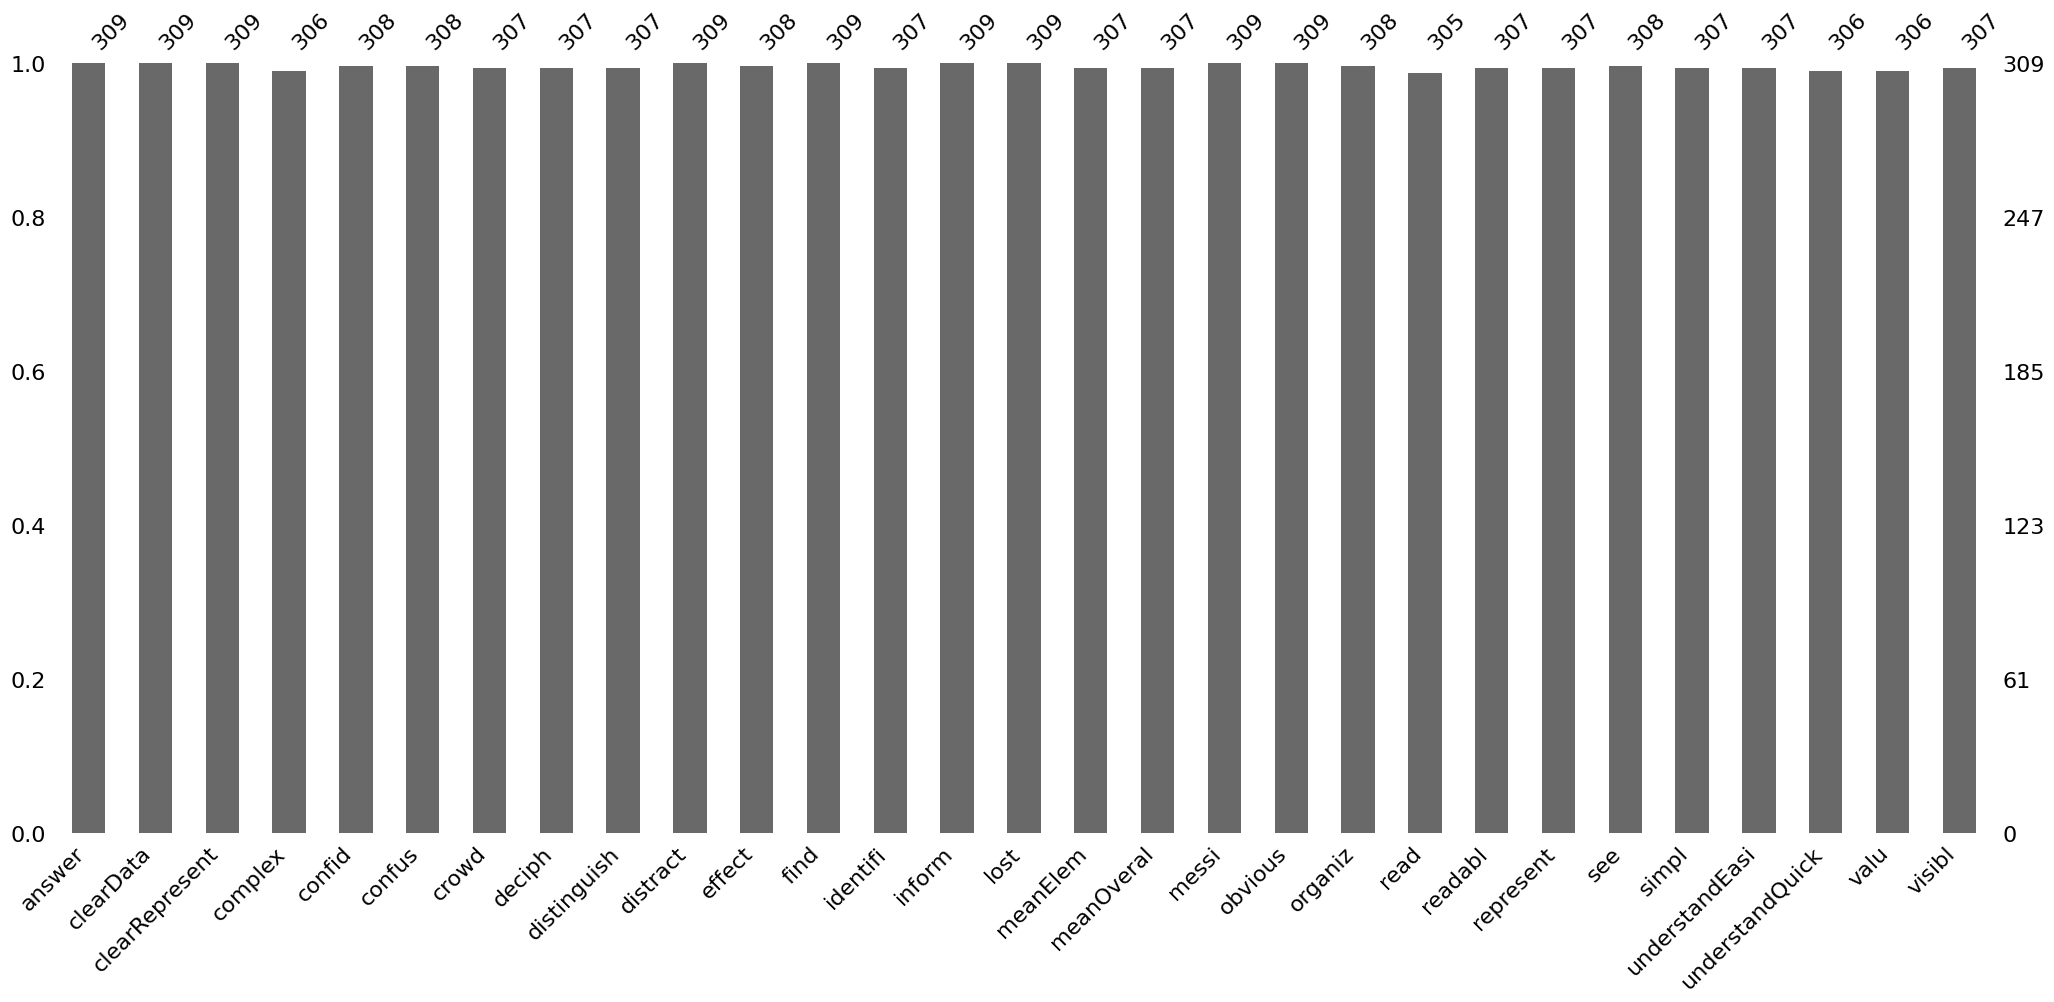

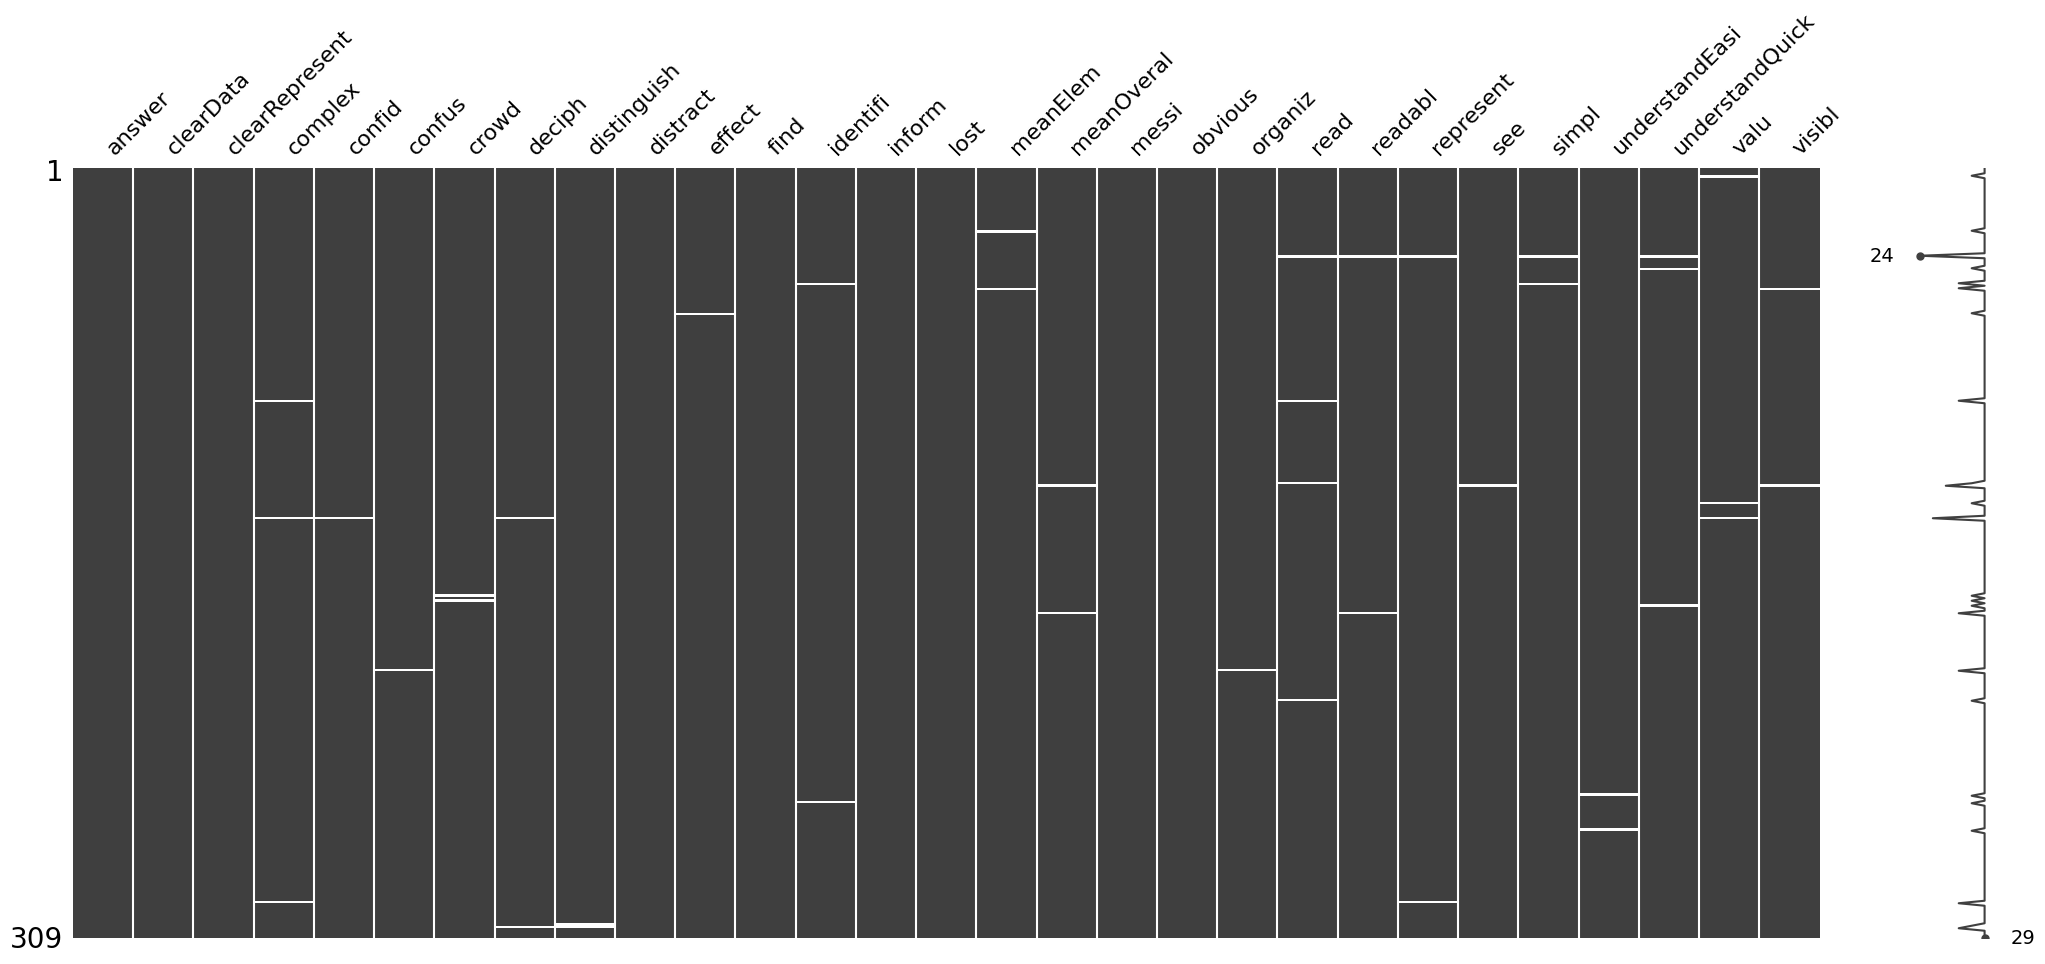

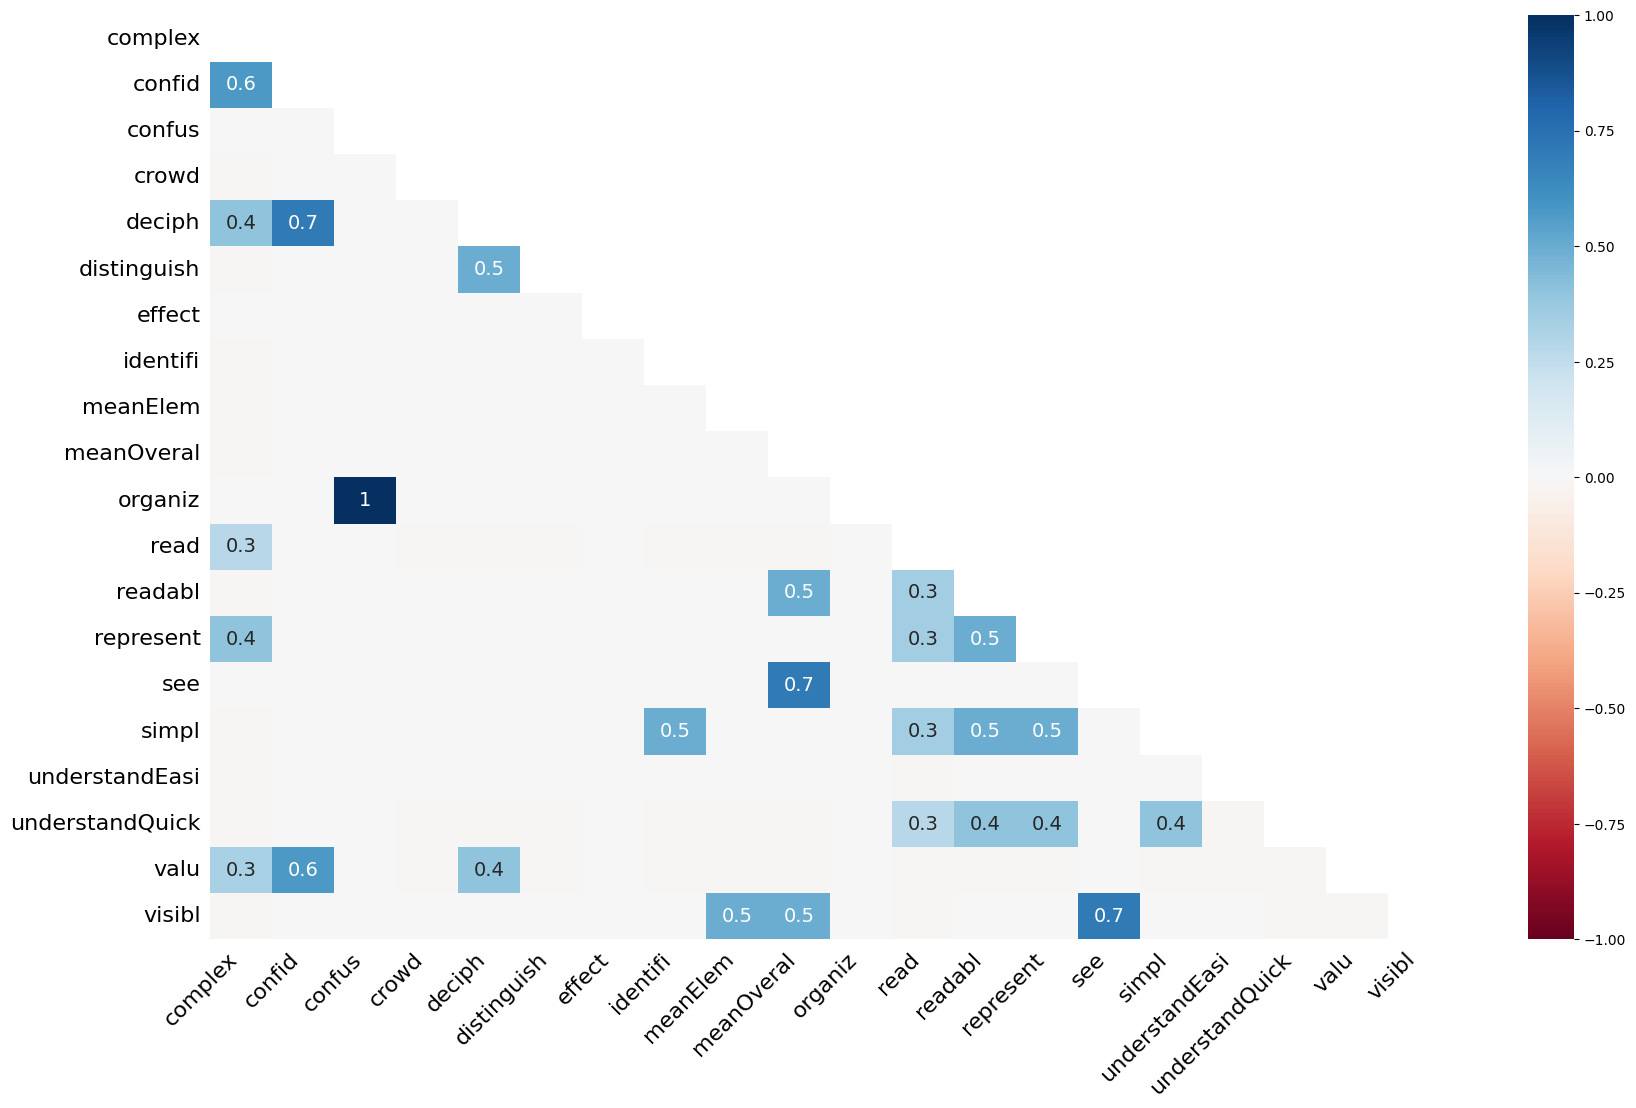

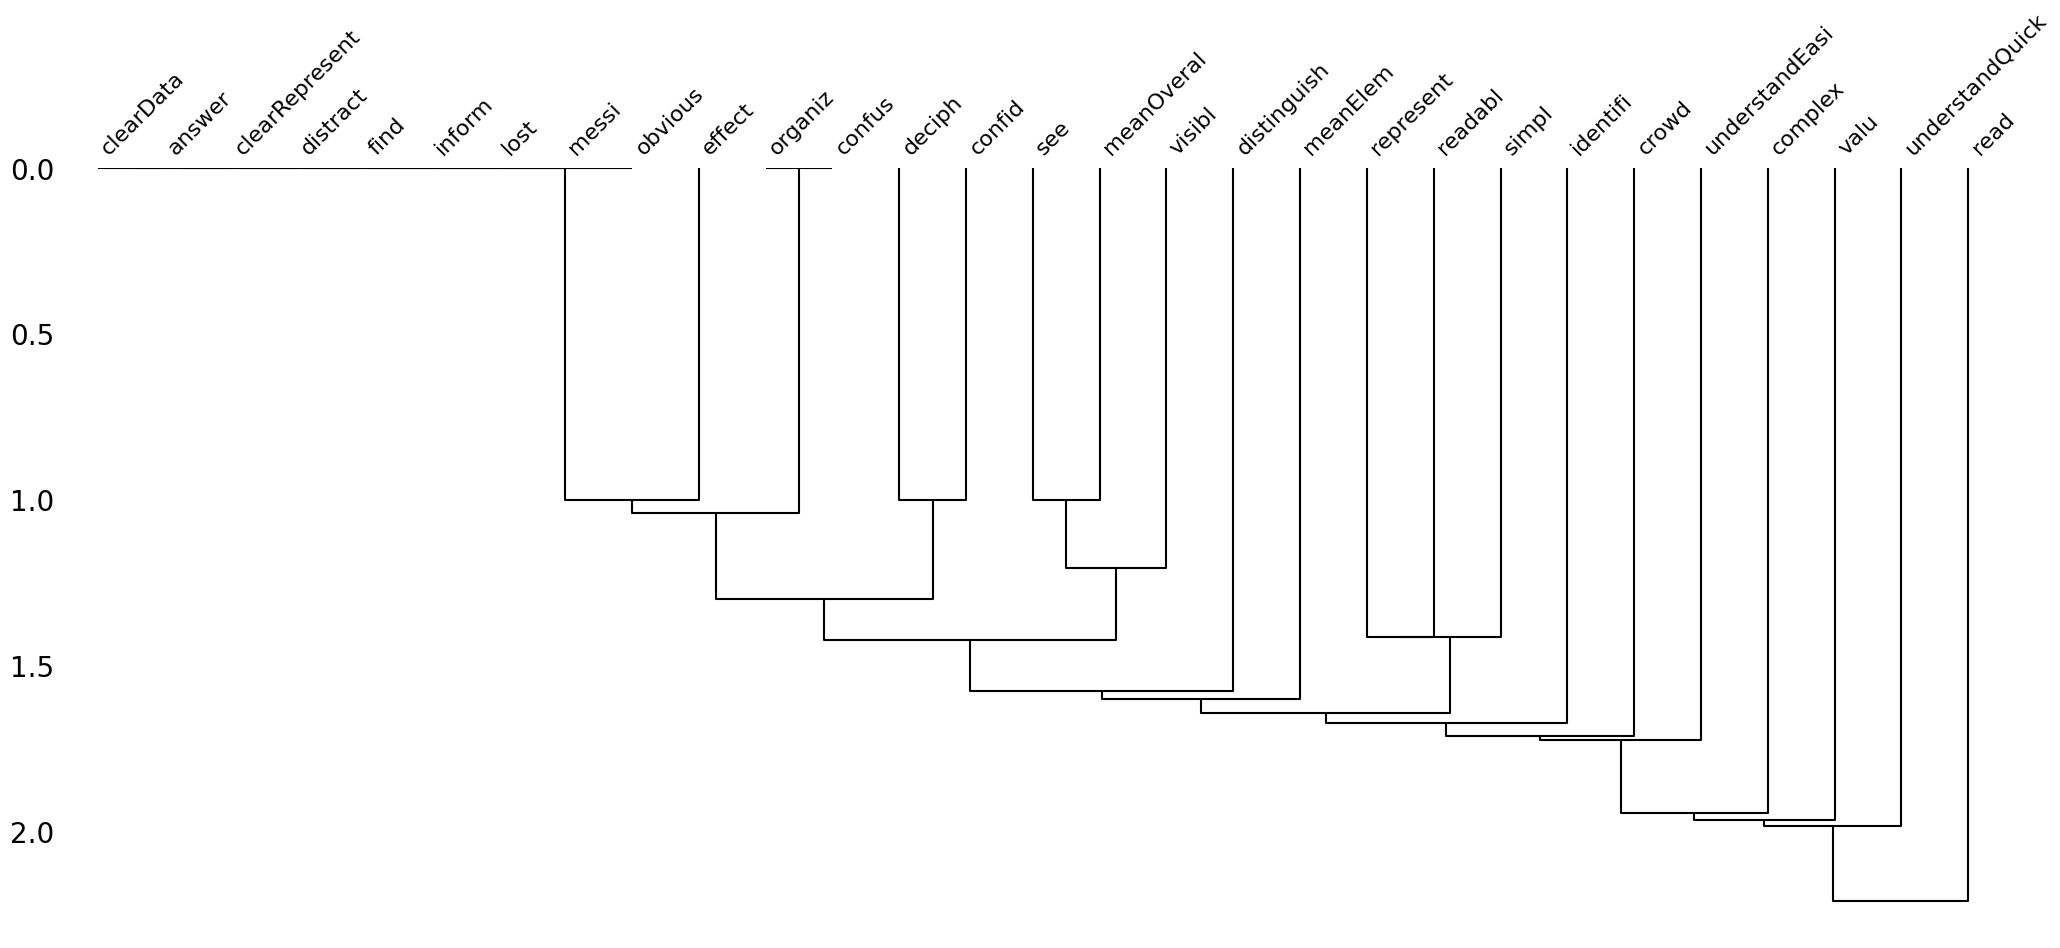

In [77]:
show_missing(stimuli_dfs['D']['ratings'])

### Missing in E

{'bar': [<Figure size 2500x1000 with 3 Axes>],
 'matrix': <Figure size 2500x1000 with 2 Axes>,
 'heatmap': <Figure size 2000x1200 with 2 Axes>,
 'dendrogram': <Figure size 2500x1000 with 1 Axes>}

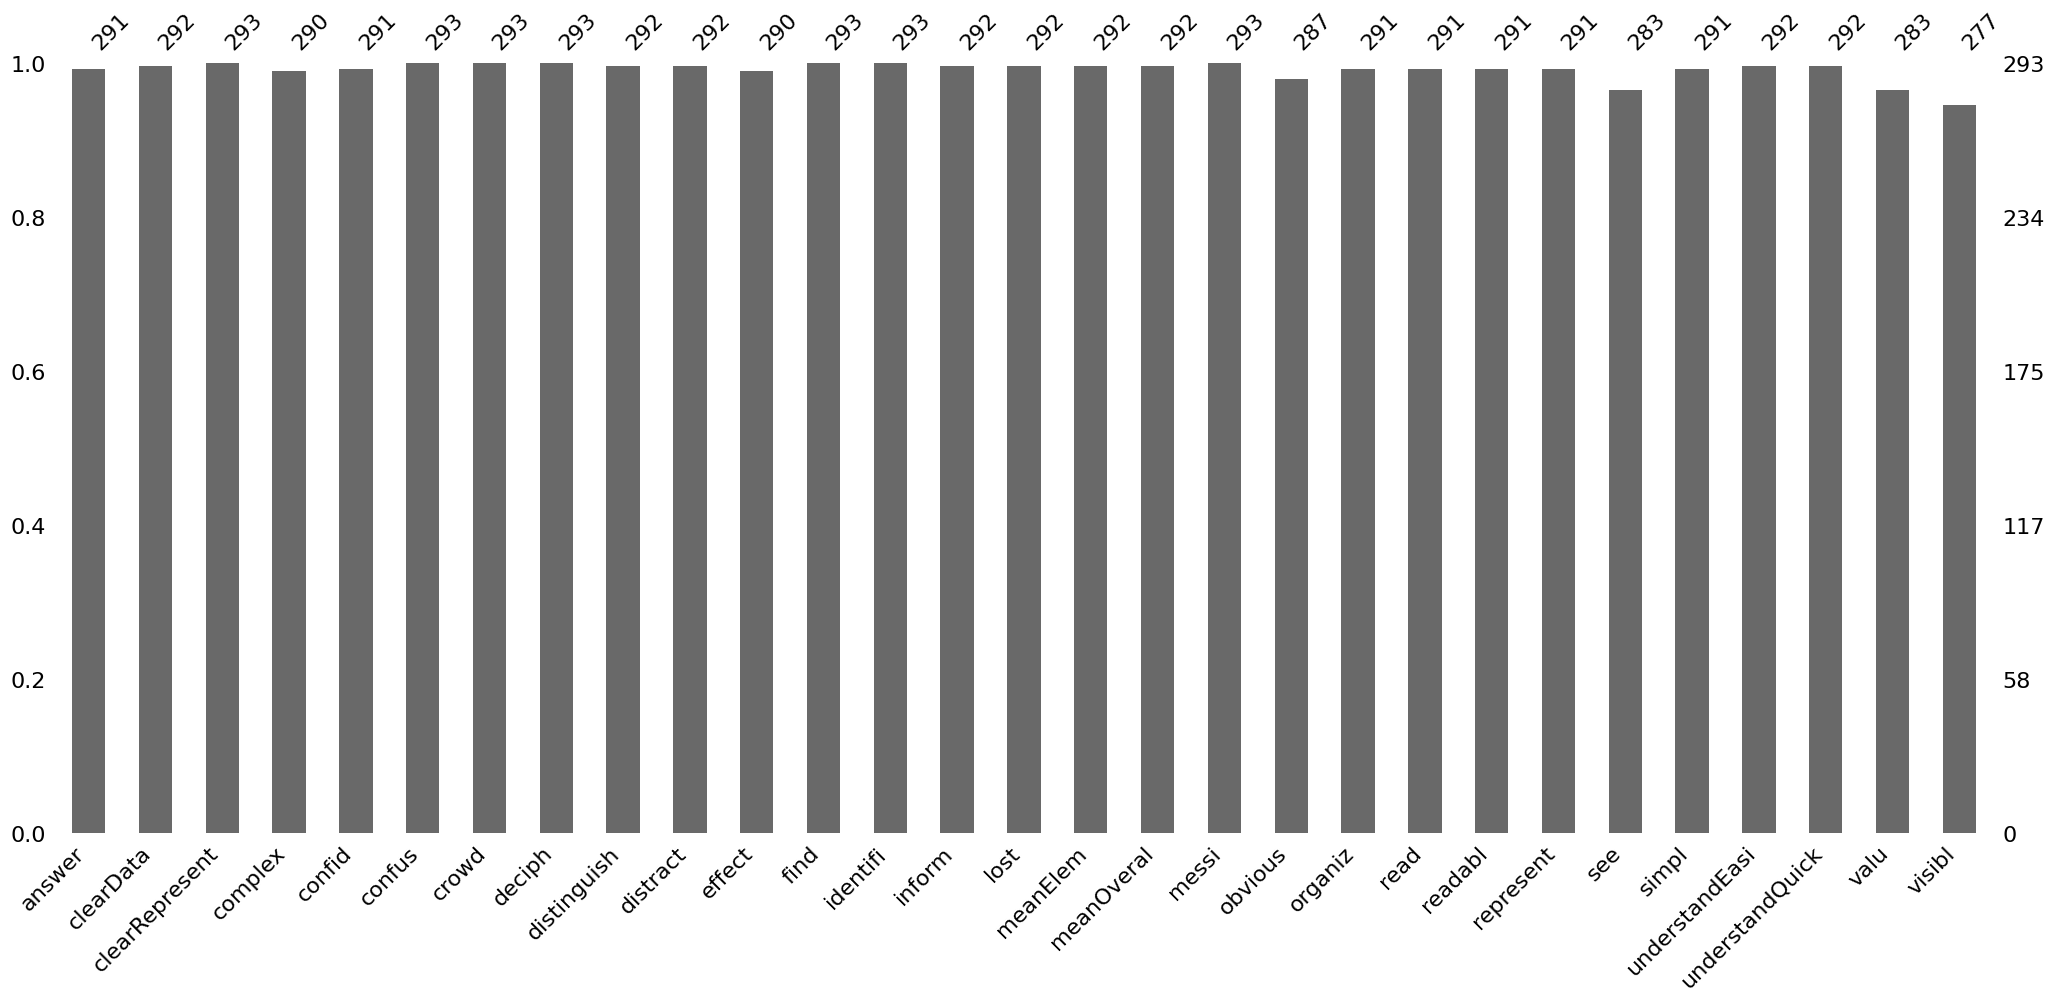

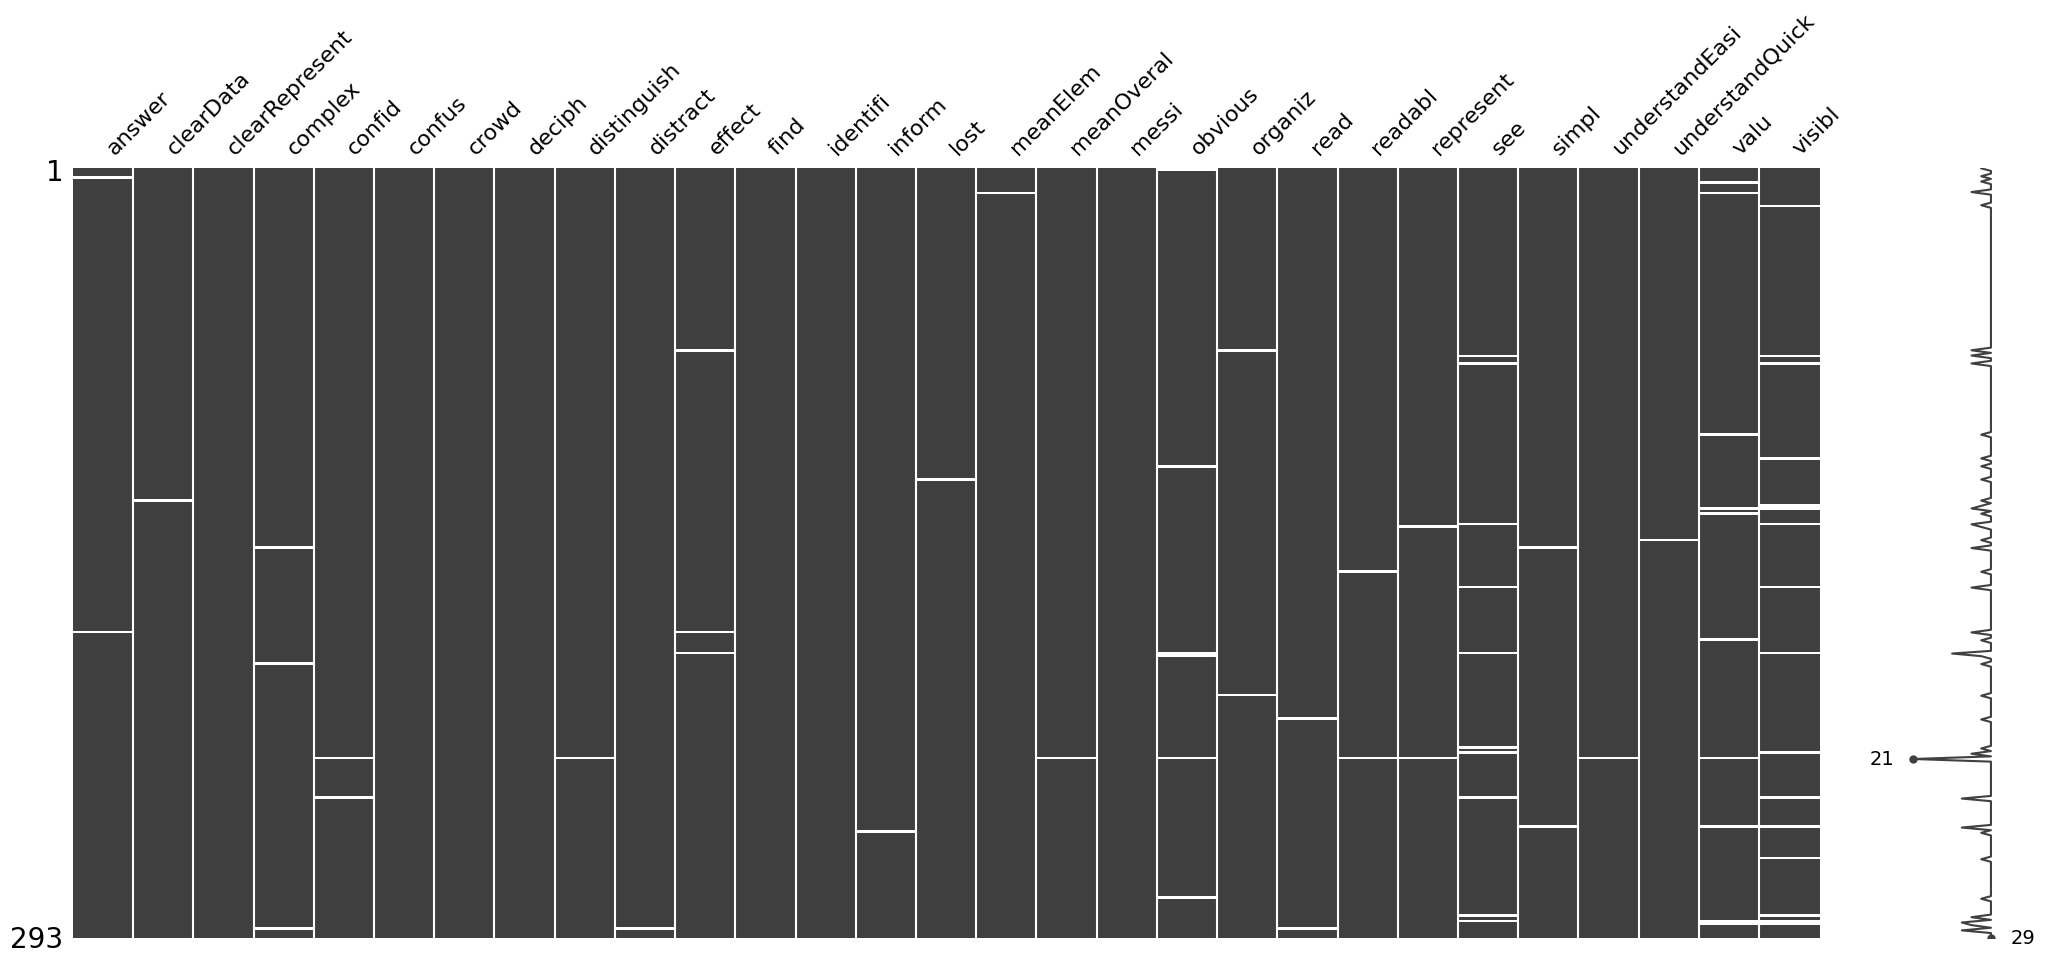

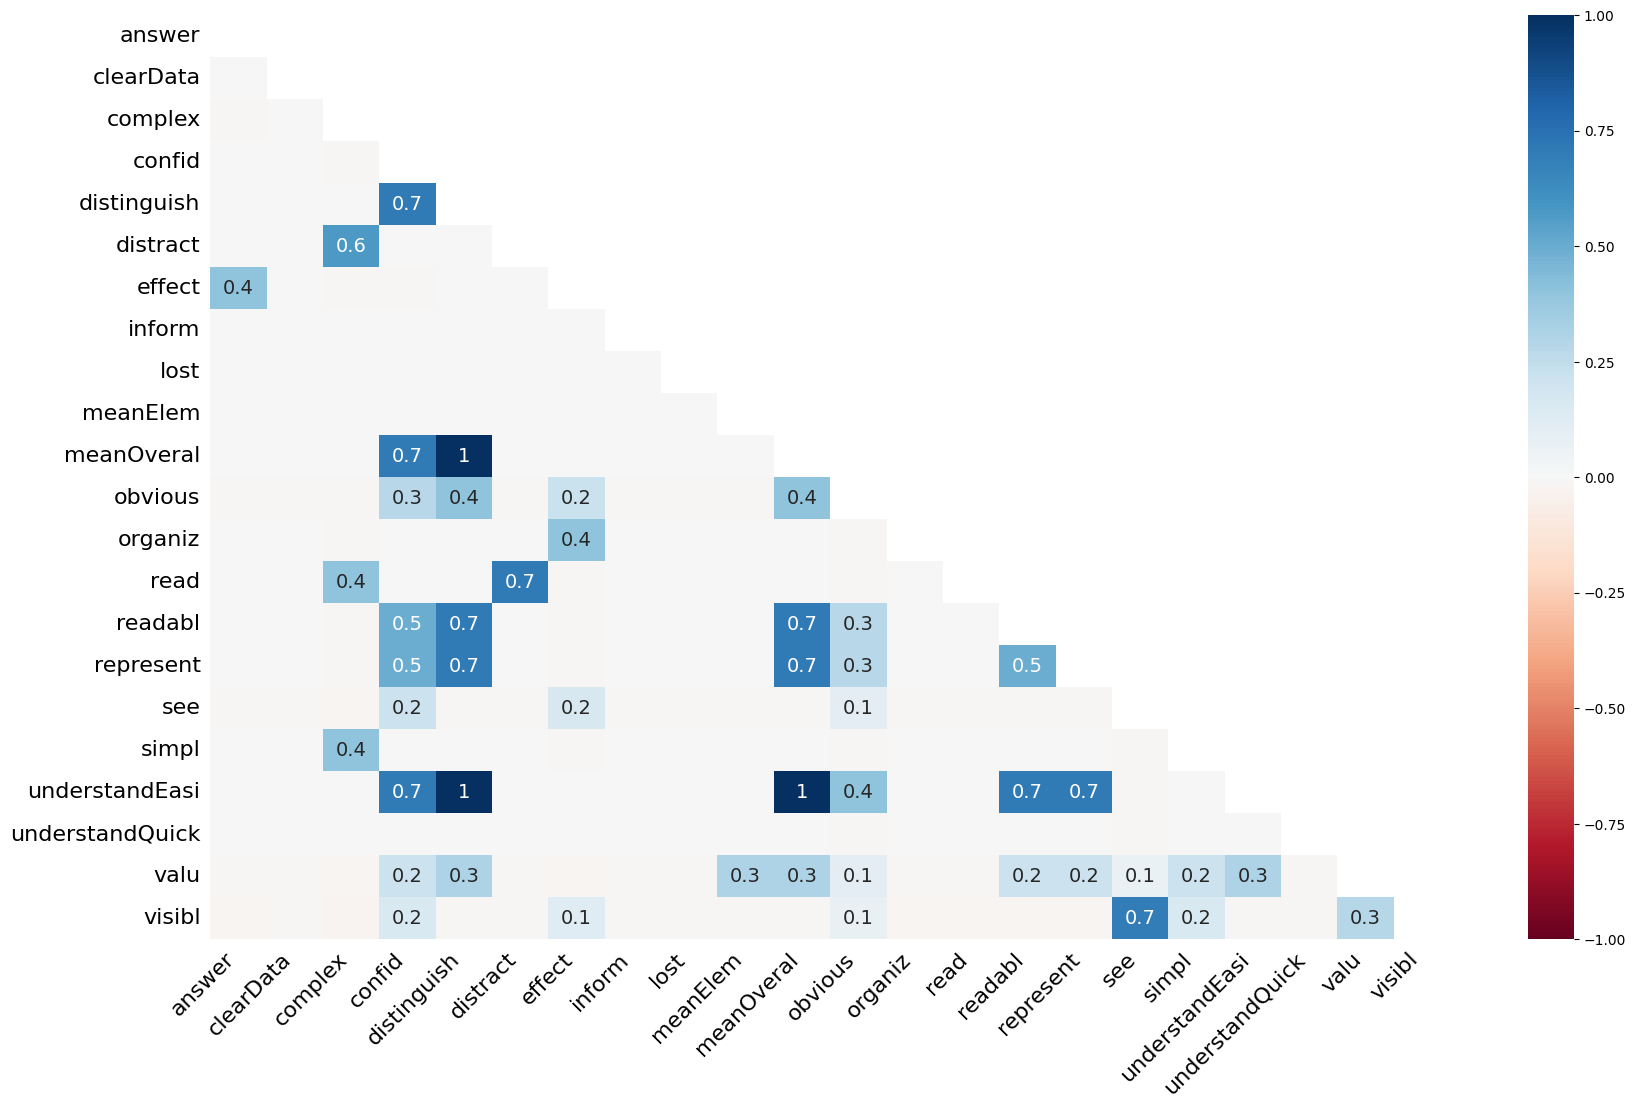

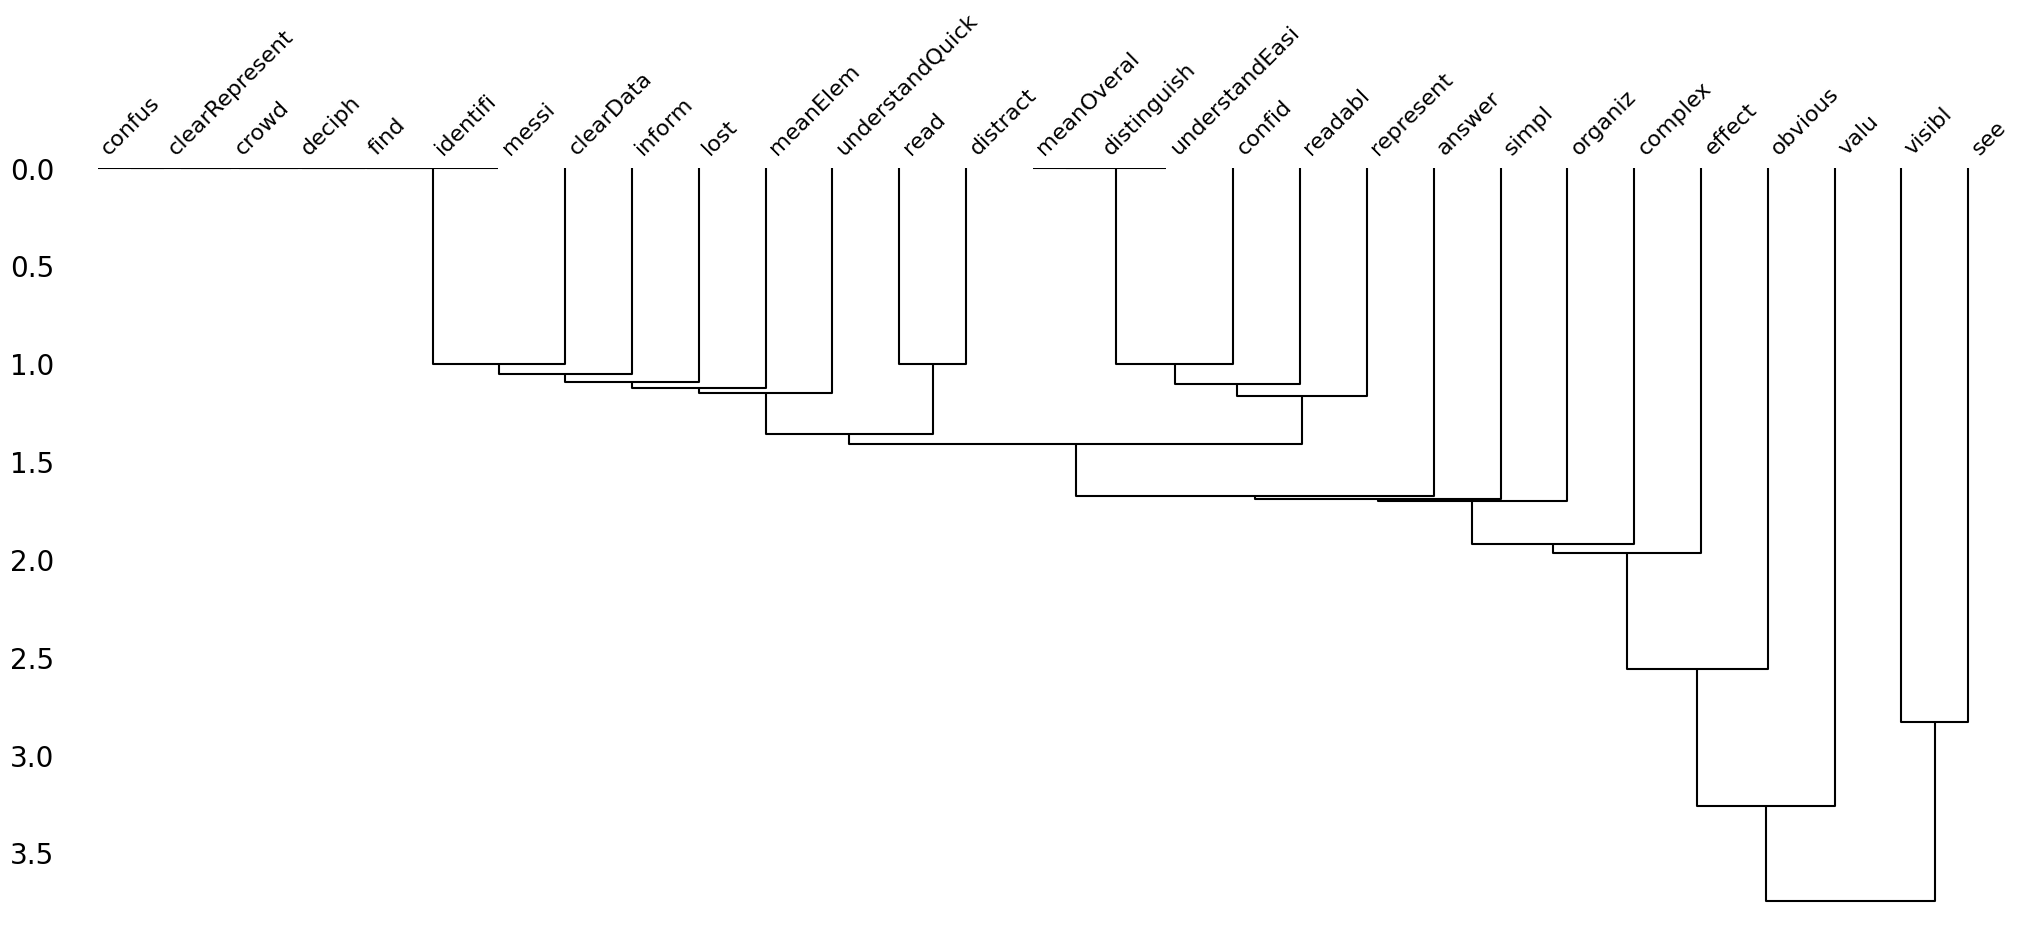

In [78]:
show_missing(stimuli_dfs['E']['ratings'])

### Missing in F

{'bar': [<Figure size 2500x1000 with 3 Axes>],
 'matrix': <Figure size 2500x1000 with 2 Axes>,
 'heatmap': <Figure size 2000x1200 with 2 Axes>,
 'dendrogram': <Figure size 2500x1000 with 1 Axes>}

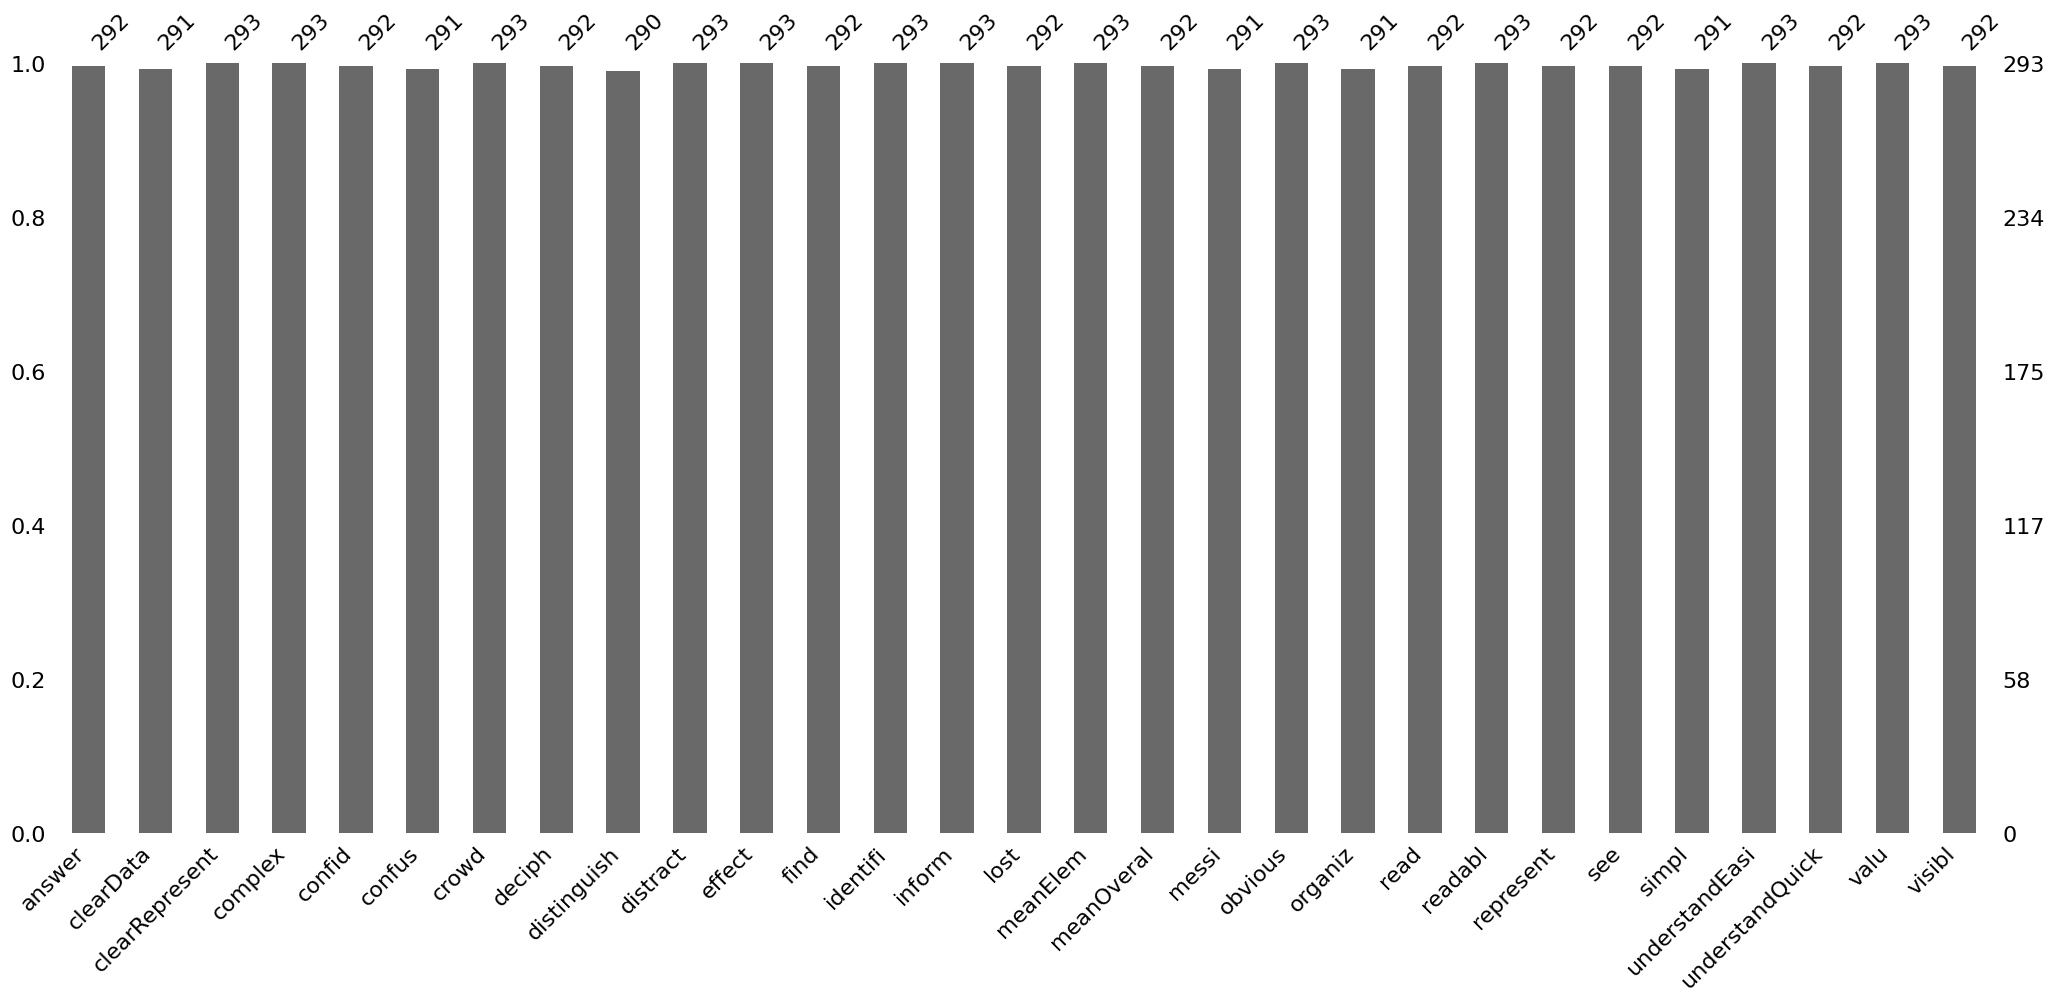

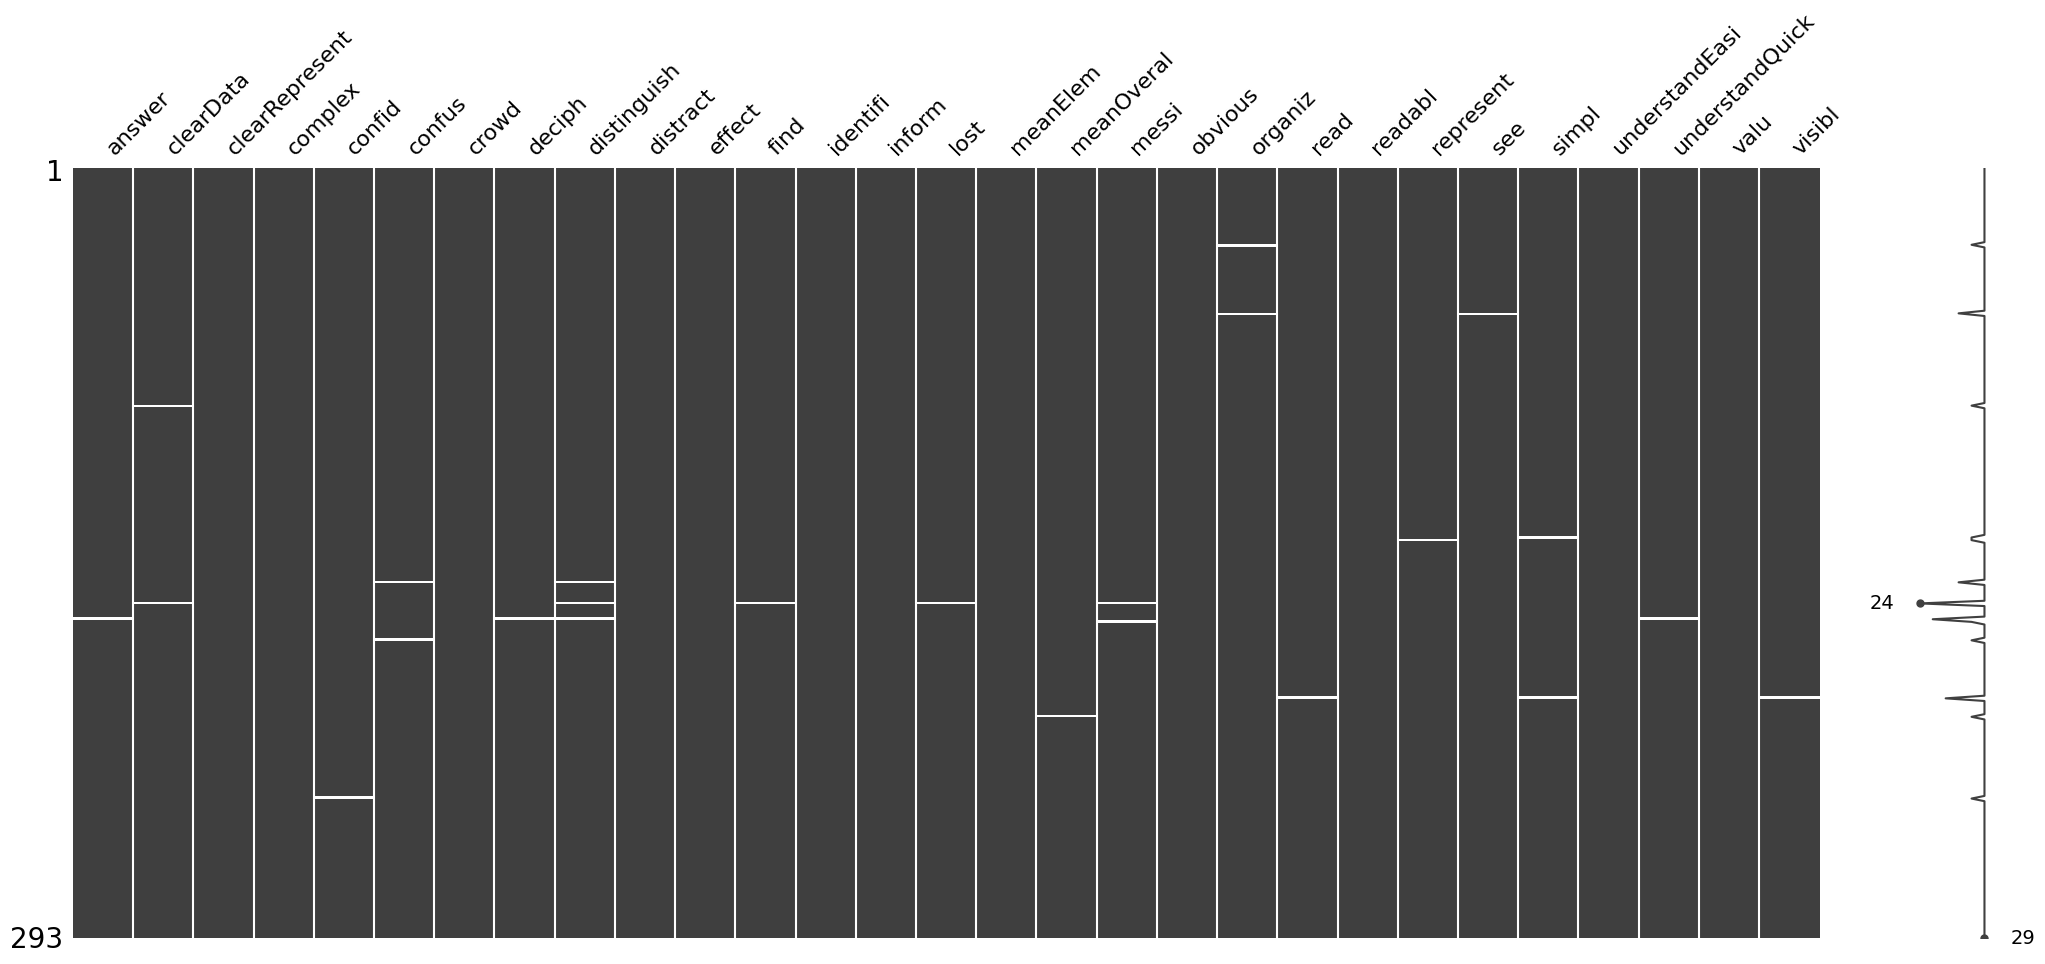

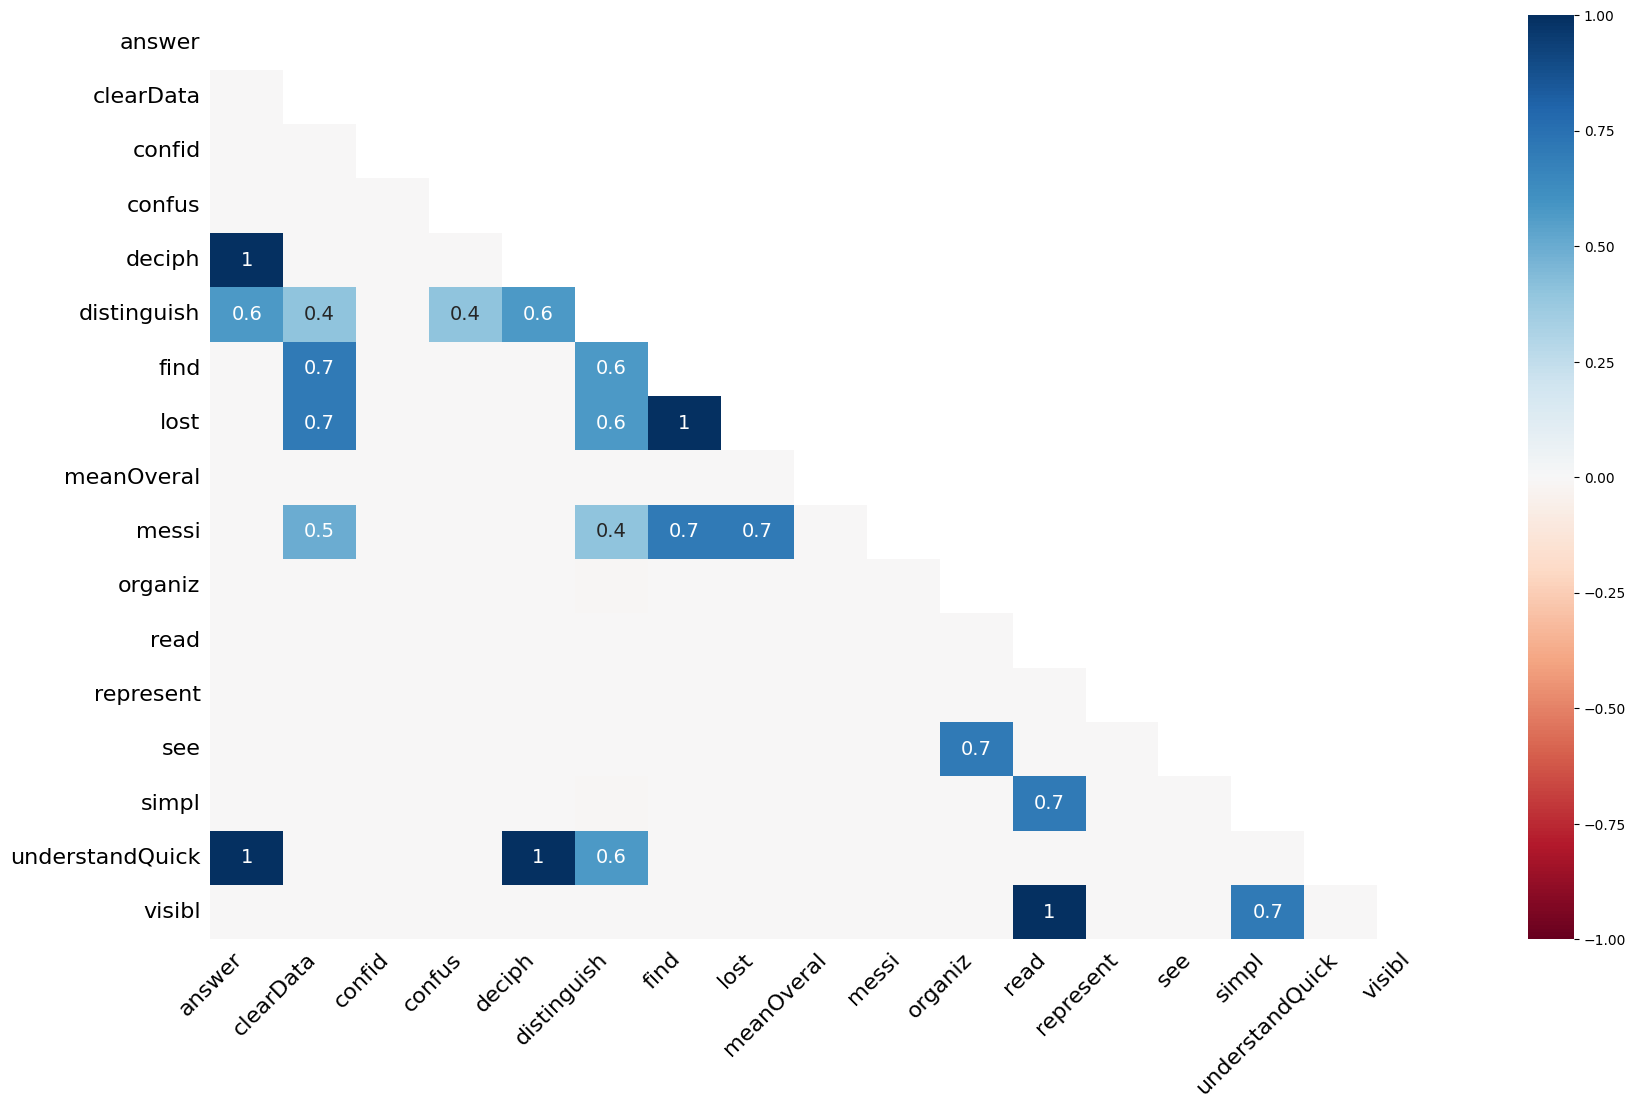

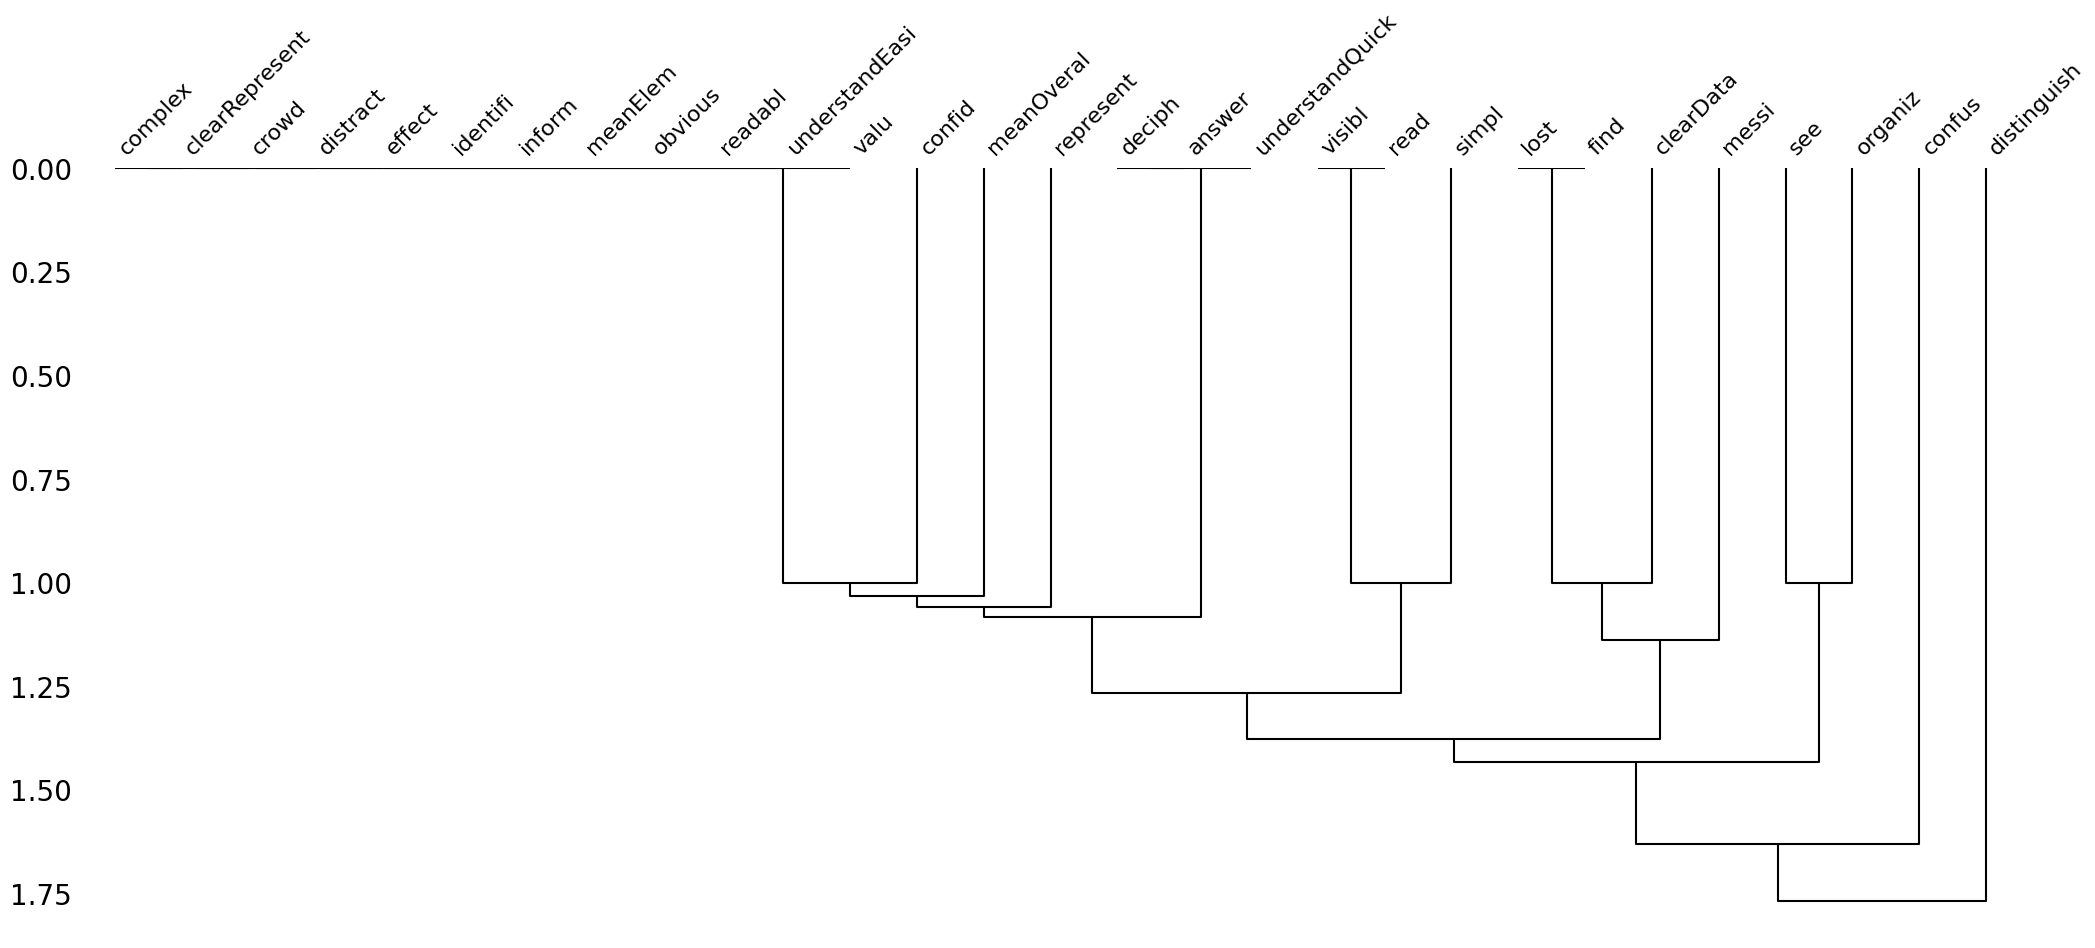

In [79]:
show_missing(stimuli_dfs['F']['ratings'])